In [43]:
from sudoku import Sudoku, SudokuGenerator
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
import os
import time
from matplotlib.patches import Patch

In [36]:
# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")



Using CUDA: NVIDIA RTX A4000
Device: cuda


In [37]:

# HYPERPARAMETERS
N_EPOCHS = 100
LEARNING_RATE = 0.001
ATTENTION_DIM = 9
N_HEADS = 1
EMBEDDING_DIM = 10
TRAIN_PUZZLES = 20000
VAL_PUZZLES = 1024
BATCH_SIZE = 512
VALIDATE_PERIOD = 10  # Run validation every N epochs
CHECKPOINT_PERIOD = 10  # Save checkpoint every N epochs
CHECKPOINT_DIR = "./sudoku_checkpoints"  # Directory to save checkpoints
LOAD_CHECKPOINT = None  # Path to checkpoint to load, or None to start fresh
SAVE_CHECKPOINT = False
SAMPLES_PER_PUZZLE = 3
NEGATIVE_SAMPLES_SIZE = 1
USE_NEGATIVE_SAMPLES = False


assert ATTENTION_DIM % N_HEADS == 0

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def get_checkpoint_filename(epoch=None):
    """Generate checkpoint filename with hyperparameters"""
    filename = f"sudoku_emb{EMBEDDING_DIM}_att{ATTENTION_DIM}_h{N_HEADS}_bs{BATCH_SIZE}_lr{LEARNING_RATE}"
    if epoch is not None:
        filename += f"_epoch{epoch}"
    else:
        filename += "_final"
    filename += ".pt"
    return os.path.join(CHECKPOINT_DIR, filename)


In [38]:

class PositionalEncoding(nn.Module):
    # for a 9 by 9 sudoku grid
    # subdivide a unit circle into 81 sections
    # and return x, y coordinates of that output
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        # Create a grid of positions (0-8 for both x and y)
        x_coords = torch.arange(0, 9).unsqueeze(0).repeat(9, 1)
        y_coords = torch.arange(0, 9).unsqueeze(1).repeat(1, 9)
        
        # Convert grid positions to linear indices (0-80)
        linear_indices = y_coords * 9 + x_coords  # shape: (9, 9)
        
        # Convert linear indices to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (9, 9)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles)
        y_circle = torch.sin(angles)
        
        # Stack and add batch dimension
        pos_encoding = torch.stack([x_circle, y_circle], dim=-1).unsqueeze(0)  # shape: (1, 9, 9, 2)
        self.register_buffer('pos_encoding', pos_encoding)
    
    def get_embedding_for_position(self, pos):
        # input (batch, 2) where pos[:, 0] is x and pos[:, 1] is y
        # Convert to linear indices
        linear_indices = pos[:, 1] * 9 + pos[:, 0]  # shape: (batch,)
        
        # Convert to angles on unit circle
        angles = 2 * math.pi * linear_indices / 81  # shape: (batch,)
        
        # Compute x, y coordinates on unit circle
        x_circle = torch.cos(angles).unsqueeze(1)  # shape: (batch, 1)
        y_circle = torch.sin(angles).unsqueeze(1)  # shape: (batch, 1)
        
        return torch.cat([x_circle, y_circle], dim=1)  # shape: (batch, 2)
    
    def forward(self, x):
        # x is a (batch, 9, 9, embedding_dim) grid
        # output (batch, 9, 9, embedding_dim + 2) grid by adding pos_encoding to x
        batch_size = x.shape[0]
        pos_expanded = self.pos_encoding.repeat(batch_size, 1, 1, 1)
        # Concatenate along the last dimension: (batch, 9, 9, embedding_dim + 2)
        return torch.cat([x, pos_expanded], dim=-1)
    
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # seperate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0,2,1,3) # [batch, head, seqlen, dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0,2,1,3) # [batch, seqlen, head, dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values) # [batch, seq_length, 81]

        if return_attention:
            return o, attention
        else:
            return o

class Sudoku2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, attention_dim=ATTENTION_DIM, num_heads=N_HEADS, device='cpu'):
        super(Sudoku2Vec, self).__init__()
        self.device = device
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        self.pe = PositionalEncoding()
        self.embed = nn.Embedding(vocab_size, embedding_dim) # this will provide the key queries and values
        self.total_dim = self.embedding_dim + 2

        self.mha = MultiheadAttention(
            input_dim=self.total_dim,
            embed_dim=attention_dim,
            num_heads=num_heads
        )
        
        # Move model to device
        self.to(device)
    
    def get_embeddings(self):
        """
        Returns the learned token embeddings.
        
        Returns:
            torch.Tensor: Embedding weight matrix of shape [vocab_size, embedding_dim]
        """
        return self.embed.weight.detach()
    
    def get_embedding_for_token(self, token):
        """
        Get the embedding vector for a specific token.
        
        Args:
            token: Integer token ID or tensor of token IDs
            
        Returns:
            torch.Tensor: Embedding vector(s) for the given token(s)
        """
        if isinstance(token, int):
            token = torch.tensor([token], device=self.device)
        elif not isinstance(token, torch.Tensor):
            token = torch.tensor(token, device=self.device)
        return self.embed(token).detach()
    
    def save_model(self, filepath):
        """
        Save the model in a portable format that can be easily loaded.
        This saves the model architecture and weights in a single file.
        
        Args:
            filepath: Path where to save the model (should end with .pt or .pth)
        """
        save_dict = {
            'model_state_dict': self.state_dict(),
            'model_config': {
                'vocab_size': self.embed.num_embeddings,
                'embedding_dim': self.embedding_dim,
                'attention_dim': self.mha.embed_dim,
                'num_heads': self.num_heads,
            },
            'model_class': 'Sudoku2Vec',
        }
        torch.save(save_dict, filepath)
        print(f"Model saved to {filepath}")
    
    @classmethod
    def load_model(cls, filepath, device='cpu'):
        """
        Load a saved Sudoku2Vec model from file.
        
        Args:
            filepath: Path to the saved model file
            device: Device to load the model on ('cpu', 'cuda', 'mps')
            
        Returns:
            Sudoku2Vec: Loaded model instance
        """
        checkpoint = torch.load(filepath, map_location=device)
        
        # Extract configuration
        config = checkpoint['model_config']
        
        # Create model instance
        model = cls(
            vocab_size=config['vocab_size'],
            embedding_dim=config['embedding_dim'],
            attention_dim=config['attention_dim'],
            num_heads=config['num_heads'],
            device=device
        )
        
        # Load weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()  # Set to evaluation mode by default
        
        print(f"Model loaded from {filepath}")
        print(f"Configuration: vocab_size={config['vocab_size']}, "
              f"embedding_dim={config['embedding_dim']}, "
              f"attention_dim={config['attention_dim']}, "
              f"num_heads={config['num_heads']}")
        
        return model
    
    def forward(self, target, position, sudoku_grid, mask=True):
        # target - the token in the target blank space we try to predict shape [batch] i.e [0, 3, 3, 5, 1, ...]
        # position - the (x, y) position of the target shape [batch, 2] - [[1, 1], [0, 3], [7,7], ...]
        # sudoku_grid - the sudoku grid for the problem with target we want to predict shape [batch, 9, 9]
        batch_size = target.shape[0]
        
        target_token_embeddings = self.embed(target) # shape [batch, embedding_dim]
        target_position_vectors = self.pe.get_embedding_for_position(position) # [batch, 2]
        target_token_with_position = torch.cat([target_token_embeddings, target_position_vectors], dim=-1)  # shape [batch, total_dim]

        # mask the target in the grid
        sudoku_grid_masked = sudoku_grid
        if mask:
            batch_indices = torch.arange(sudoku_grid.shape[0], device=self.device)
            sudoku_grid_masked = sudoku_grid.clone()
            sudoku_grid_masked[batch_indices, position[:, 1], position[:, 0]] = 0 # 0 is a mask token aka blank
        
        masked_sudoku_grid_embeddings = self.embed(sudoku_grid_masked)
        masked_sudoku_grid_with_position = self.pe(masked_sudoku_grid_embeddings) # shape [batch, 9, 9, total_dim]
        # Reshape grid to sequence: [batch, 81, total_dim]
        masked_grid_seq = masked_sudoku_grid_with_position.view(batch_size, 81, self.total_dim)

        grid_seq_embeddings = self.embed(sudoku_grid)
        grid_seq_embeddings = grid_seq_embeddings.view(batch_size, 81, self.embedding_dim) 
        
        # Query from target token: [batch, 1, total_dim]
        # query = target_token_with_position.unsqueeze(1)

        output, attention = self.mha(masked_grid_seq, return_attention=True)
        # output is shape [batch, 81, total_dim]
        
        return output, attention, target_token_with_position, grid_seq_embeddings
    
    def loss(self, target, position, sudoku_grid, negative_samples=NEGATIVE_SAMPLES_SIZE, use_negative_samples=USE_NEGATIVE_SAMPLES, debug=False):
        """
        Compute contrastive loss for the model.
        
        The loss combines two components:
        1. Margin-based Contrastive Loss: Encourages the model to distinguish between correct (positive) 
           and incorrect (negative) token predictions by maximizing positive scores and minimizing negative scores.
           (Optional - controlled by use_negative_samples parameter)
        2. Cosine Similarity Loss: Directly maximizes the cosine similarity between predicted and 
           ground truth embeddings.
        
        Mathematical formulation:
        
        For a batch of examples, let:
        - z_i = output embedding at target position i (from attention output)
        - p_i = ground truth embedding at target position i (from target token embedding)
        - n_{i,j} = j-th negative sample embedding for example i
        
        Cosine Similarity (computed ONLY at target position):
            cos_sim(z_i, p_i) = (z_i · p_i) / (||z_i|| ||p_i||)
        
        Margin-based Contrastive Loss (per example i) - OPTIONAL:
            L_contrastive = max(0, margin - cos_sim(z_i, p_i)) + Σ_j max(0, cos_sim(z_i, n_{i,j}))
        
        This loss:
        - Penalizes positive scores below the margin (encourages positive scores to be high)
        - Penalizes positive negative scores (encourages negative scores to be low/negative)
        
        Cosine Loss:
            L_cosine = 1 - mean(cos_sim(z_i, p_i))
        
        Total Loss:
            If use_negative_samples is True:
                L_total = L_contrastive + L_cosine
            If use_negative_samples is False:
                L_total = L_cosine
        
        Relationship between the two losses:
        - Both losses encourage high cosine similarity between predicted and ground truth embeddings
        - L_contrastive uses a margin-based objective: it ensures positive similarity is high (above margin)
          and negative similarities are low (below 0)
        - L_cosine provides a direct gradient signal to maximize positive similarity without 
          considering negatives
        - Together, they provide both relative ranking (contrastive) and absolute alignment (cosine)
        
        Args:
            target: Ground truth tokens [batch]
            position: Target positions [batch, 2]
            sudoku_grid: Sudoku grids [batch, 9, 9]
            negative_samples: Number of negative samples per positive example (only used if use_negative_samples=True)
            use_negative_samples: Whether to use negative samples for contrastive loss
            debug: If True, visualize embeddings, cosine similarity, sudoku grids, and attention maps
        
        Returns:
            total_loss: Combined loss value
            contrastive_loss: Margin-based contrastive loss component (0 if use_negative_samples=False)
            cosine_loss: Cosine similarity loss component
            accuracy: Prediction accuracy based on closest cosine similarity to vocab embeddings
        """
        batch_size = target.shape[0]
        
        # Forward pass to get output and target embeddings
        output, attention, target_token_with_position, grid_embeddings_flat = self.forward(target, position, sudoku_grid, mask=True)
        # output is shape [batch, seq_length, total_dim]
        
        # Extract only the embedding portion (without position vectors) from output
        # output is [batch, 81, total_dim] where total_dim = embedding_dim + 2
        # We want only the first embedding_dim dimensions
        output_embeddings = output[:, :, :self.embedding_dim]  # shape [batch, 81, embedding_dim]
        
        # Normalize embeddings for cosine similarity computation
        output_norm = F.normalize(output_embeddings, p=2, dim=-1)  # [batch, 81, embedding_dim]
        grid_norm = F.normalize(grid_embeddings_flat, p=2, dim=-1)  # [batch, 81, embedding_dim]
        
        # === Extract embeddings at target positions ===
        batch_indices = torch.arange(batch_size, device=self.device)
        # Convert 2D positions to linear indices
        linear_indices = position[:, 1] * 9 + position[:, 0]  # [batch]
        
        # Get output embeddings at target positions (z_i)
        output_at_target = output_embeddings[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        output_at_target_norm = F.normalize(output_at_target, p=2, dim=-1)  # [batch, embedding_dim]
        
        # Get ground truth embeddings at target positions (p_i)
        ground_truth_at_target = grid_embeddings_flat[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        ground_truth_at_target_norm = F.normalize(ground_truth_at_target, p=2, dim=-1)  # [batch, embedding_dim]
        
        # Compute positive cosine similarity ONLY at target position
        # This is cos_sim(z_i, p_i) where i is the target position
        positive_scores = (output_at_target_norm * ground_truth_at_target_norm).sum(dim=-1)  # [batch]
        
        # Compute positive scores for all positions (for debugging/visualization)
        positive_scores_per_position = (output_norm * grid_norm).sum(dim=-1)  # [batch, 81]
        
        # === Margin-based Contrastive Loss (Optional) ===
        margin = 1.0  # Target margin for positive scores
        
        # Loss for positive scores: penalize if below margin
        # max(0, margin - positive_score) encourages positive_score >= margin
        positive_loss = torch.clamp(margin - positive_scores, min=0).mean()
        vocab_size = self.embed.num_embeddings
        
        if use_negative_samples:
            # === Negative sampling for contrastive loss ===
            # Generate negative samples (n_{i,j})
            # Sample random tokens that are not the target
            negative_targets = []
            for i in range(batch_size):
                # Sample negative_samples tokens different from target[i]
                neg_samples = []
                while len(neg_samples) < negative_samples:
                    neg_token = torch.randint(0, vocab_size, (1,), device=self.device)
                    if neg_token.item() != target[i].item():
                        neg_samples.append(neg_token)
                negative_targets.append(torch.cat(neg_samples))
            negative_targets = torch.stack(negative_targets)  # [batch, negative_samples]
            
            # Get embeddings for negative samples (only the embedding part, no position)
            negative_embeddings = self.embed(negative_targets)  # [batch, negative_samples, embedding_dim]
            
            # Compute cosine similarity between output at target position and negative samples
            # This is cos_sim(z_i, n_{i,j})
            output_at_target_norm_expanded = output_at_target_norm.unsqueeze(1)  # [batch, 1, embedding_dim]
            negative_norm = F.normalize(negative_embeddings, p=2, dim=-1)  # [batch, negative_samples, embedding_dim]
            negative_scores = (output_at_target_norm_expanded * negative_norm).sum(dim=-1)  # [batch, negative_samples]
            
            # Loss for negative scores: penalize if above 0
            # max(0, negative_score) encourages negative_score <= 0
            negative_loss = torch.clamp(negative_scores, min=-1).mean()
            
            # Combine positive and negative losses
            contrastive_loss = negative_loss
        else:
            # No negative sampling - set negative loss to 0
            negative_loss = torch.tensor(0.0, device=self.device, dtype=output.dtype)
            contrastive_loss = negative_loss
        
        # === Cosine Similarity Loss ===
        # Simple loss: 1 - cosine similarity (encourages similarity to approach 1)
        cosine_loss = positive_loss
        
        # === Combine both losses ===
        # The contrastive loss ensures positive scores are high and negative scores are low (if enabled)
        # The cosine loss ensures absolute alignment (positive → 1)
        total_loss = contrastive_loss + cosine_loss
        
        # === Compute Accuracy ===
        # For each example in the batch, find which token embedding has highest cosine similarity
        # with the output embedding at the target position
        
        # Get all token embeddings from the embedding layer [vocab_size, embedding_dim]
        all_token_embeddings = self.embed.weight  # [vocab_size, embedding_dim]
        all_token_embeddings_norm = F.normalize(all_token_embeddings, p=2, dim=-1)  # [vocab_size, embedding_dim]
        
        # Compute cosine similarity between output at target and all vocab tokens
        # output_at_target_norm: [batch, embedding_dim]
        # all_token_embeddings_norm: [vocab_size, embedding_dim]
        # We want: [batch, vocab_size]
        similarity_to_all_tokens = torch.matmul(output_at_target_norm, all_token_embeddings_norm.T)  # [batch, vocab_size]
        
        # Get the predicted token (argmax of cosine similarities)
        predicted_tokens = torch.argmax(similarity_to_all_tokens, dim=-1)  # [batch]
        
        # Compute accuracy
        correct_predictions = (predicted_tokens == target).float()
        accuracy = correct_predictions.mean()
        
        # === Debug Visualization ===
        if debug:
            
            # We'll visualize the first sample in the batch
            sample_idx = 0
            
            # Number colors for sudoku visualization
            number_colors = {
                1: '#FFB3BA',  # Light red
                2: '#FFDFBA',  # Light orange
                3: '#FFFFBA',  # Light yellow
                4: '#BAFFC9',  # Light green
                5: '#BAE1FF',  # Light blue
                6: '#D4BAFF',  # Light purple
                7: '#FFB3E6',  # Light pink
                8: '#C9C9C9',  # Light gray
                9: '#FFD4BA',  # Light peach
            }
            
            print("\n" + "="*80)
            print("DEBUG MODE: Visualizing Model Internals")
            print("="*80)
            
            # 1. SUDOKU GRID AND TARGET VISUALIZATION
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Original grid
            ax = axes[0]
            puzzle = sudoku_grid[sample_idx].cpu().numpy()
            pos = position[sample_idx].cpu().numpy()
            tgt = target[sample_idx].item()
            
            for i in range(9):
                for j in range(9):
                    if puzzle[i, j] != 0:
                        color = number_colors[puzzle[i, j]]
                        rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                                 edgecolor='none', facecolor=color, alpha=0.6)
                        ax.add_patch(rect)
            
            for i in range(10):
                linewidth = 2 if i % 3 == 0 else 0.5
                ax.axhline(i, color='black', linewidth=linewidth)
                ax.axvline(i, color='black', linewidth=linewidth)
            
            for i in range(9):
                for j in range(9):
                    if puzzle[i, j] != 0:
                        ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                               ha='center', va='center', fontsize=12, fontweight='bold')
            
            # Mark target position
            ax.plot(pos[0] + 0.5, pos[1] + 0.5, 'r*', markersize=20, markeredgecolor='darkred', markeredgewidth=2)
            
            ax.set_xlim(0, 9)
            ax.set_ylim(0, 9)
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Original Sudoku Grid\nTarget: {tgt} at Position ({pos[0]}, {pos[1]})', fontweight='bold')
            
            # Masked grid
            ax = axes[1]
            masked_puzzle = sudoku_grid.clone()
            masked_puzzle[sample_idx, pos[1], pos[0]] = 0
            masked_puzzle = masked_puzzle[sample_idx].cpu().numpy()
            
            for i in range(9):
                for j in range(9):
                    if masked_puzzle[i, j] != 0:
                        color = number_colors[masked_puzzle[i, j]]
                        rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                                 edgecolor='none', facecolor=color, alpha=0.6)
                        ax.add_patch(rect)
            
            for i in range(10):
                linewidth = 2 if i % 3 == 0 else 0.5
                ax.axhline(i, color='black', linewidth=linewidth)
                ax.axvline(i, color='black', linewidth=linewidth)
            
            for i in range(9):
                for j in range(9):
                    if masked_puzzle[i, j] != 0:
                        ax.text(j + 0.5, i + 0.5, str(masked_puzzle[i, j]), 
                               ha='center', va='center', fontsize=12, fontweight='bold')
            
            # Mark target position (empty)
            ax.plot(pos[0] + 0.5, pos[1] + 0.5, 'r*', markersize=20, markeredgecolor='darkred', markeredgewidth=2)
            
            ax.set_xlim(0, 9)
            ax.set_ylim(0, 9)
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Masked Sudoku Grid (Input to Model)\nPosition ({pos[0]}, {pos[1]}) is Masked', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # 2. EMBEDDINGS VISUALIZATION
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Output embeddings at all positions (reshaped to 9x9 grid)
            ax = axes[0, 0]
            output_emb_2d = output_embeddings[sample_idx].cpu().detach().float().numpy()  # [81, embedding_dim]
            output_emb_grid = output_emb_2d.reshape(9, 9, -1)  # [9, 9, embedding_dim]
            # Visualize L2 norm of embeddings
            output_norms = np.linalg.norm(output_emb_grid, axis=-1)  # [9, 9]
            im = ax.imshow(output_norms, cmap='viridis', aspect='auto')
            ax.set_title('Output Embedding Norms (9x9 Grid) - attention output', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Grid embeddings (ground truth)
            ax = axes[0, 1]
            grid_emb_2d = grid_embeddings_flat[sample_idx].cpu().detach().float().numpy()  # [81, embedding_dim]
            grid_emb_grid = grid_emb_2d.reshape(9, 9, -1)  # [9, 9, embedding_dim]
            grid_norms = np.linalg.norm(grid_emb_grid, axis=-1)  # [9, 9]
            im = ax.imshow(grid_norms, cmap='viridis', aspect='auto')
            ax.set_title('Grid Embedding Norms (Ground Truth) - embedding of the grid not masked', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Output embedding at target position
            ax = axes[1, 0]
            output_at_target_vec = output_at_target[sample_idx].cpu().detach().float().numpy()
            ax.bar(range(len(output_at_target_vec)), output_at_target_vec)
            ax.set_title(f'Output Embedding at Target Position\n(Dimension: {len(output_at_target_vec)})', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Value')
            ax.grid(alpha=0.3)
            
            # Ground truth embedding at target position
            ax = axes[1, 1]
            linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            gt_at_target_vec = grid_embeddings_flat[sample_idx, linear_idx].cpu().detach().float().numpy()
            ax.bar(range(len(gt_at_target_vec)), gt_at_target_vec)
            ax.set_title(f'Ground Truth Embedding at Target Position\n(Token: {tgt})', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Value')
            ax.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # 3. ALL TOKEN EMBEDDINGS VISUALIZATION (NORMALIZED)
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Visualize all token embeddings as a heatmap
            ax = axes[0]
            all_token_emb_np = all_token_embeddings.cpu().detach().float().numpy()  # [vocab_size, embedding_dim]
            im = ax.imshow(all_token_emb_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
            ax.set_title('All Token Embeddings (Raw)', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Token ID')
            ax.set_yticks(range(vocab_size))
            plt.colorbar(im, ax=ax)
            
            # Visualize normalized token embeddings
            ax = axes[1]
            all_token_emb_norm_np = all_token_embeddings_norm.cpu().detach().float().numpy()  # [vocab_size, embedding_dim]
            im = ax.imshow(all_token_emb_norm_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
            ax.set_title('All Token Embeddings (Normalized)', fontweight='bold')
            ax.set_xlabel('Embedding Dimension')
            ax.set_ylabel('Token ID')
            ax.set_yticks(range(vocab_size))
            plt.colorbar(im, ax=ax)
            
            plt.tight_layout()
            plt.show()
            
            # 4. COSINE SIMILARITY VISUALIZATION
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Cosine similarity across all positions (reshaped to 9x9 grid)
            ax = axes[0]
            positive_scores_grid = positive_scores_per_position[sample_idx].view(9, 9).cpu().detach().float().numpy()
            im = ax.imshow(positive_scores_grid, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
            ax.set_title('Cosine Similarity (Output vs Ground Truth) - All Positions and normed', fontweight='bold')
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            
            # Add text annotations
            for i in range(9):
                for j in range(9):
                    text = ax.text(j, i, f'{positive_scores_grid[i, j]:.2f}', 
                                  ha='center', va='center', fontsize=8,
                                  color='black' if abs(positive_scores_grid[i, j]) < 0.5 else 'white')
            
            plt.colorbar(im, ax=ax)
            
            # Mark target position
            ax.plot(pos[0], pos[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
            
            # Cosine similarity between output at target and all vocab tokens
            ax = axes[1]
            vocab_similarities = similarity_to_all_tokens[sample_idx].cpu().detach().float().numpy()
            colors = ['green' if i == tgt else 'blue' if i == predicted_tokens[sample_idx].item() else 'gray' 
                     for i in range(len(vocab_similarities))]
            ax.bar(range(len(vocab_similarities)), vocab_similarities, color=colors, alpha=0.7)
            ax.set_title(f'Cosine Similarity: Output @ Target vs All Vocab Tokens\nGreen=GT({tgt}), Blue=Pred({predicted_tokens[sample_idx].item()})', 
                        fontweight='bold')
            ax.set_xlabel('Token ID')
            ax.set_ylabel('Cosine Similarity')
            ax.set_xticks(range(len(vocab_similarities)))
            ax.grid(alpha=0.3, axis='y')
            
            # Add legend
            legend_elements = [
                Patch(facecolor='green', alpha=0.7, label=f'Ground Truth (Token {tgt})'),
                Patch(facecolor='blue', alpha=0.7, label=f'Predicted (Token {predicted_tokens[sample_idx].item()})'),
                Patch(facecolor='gray', alpha=0.7, label='Other Tokens')
            ]
            ax.legend(handles=legend_elements, loc='best')
            
            plt.tight_layout()
            plt.show()
            
            # 5. ATTENTION MAPS VISUALIZATION
            fig, axes = plt.subplots(2, (self.num_heads + 1) // 2, figsize=(16, 8))
            if self.num_heads == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            # Get attention weights from the forward pass
            attention_weights = attention[sample_idx]  # [num_heads, seq_len, seq_len]
            linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            attention_at_target = attention_weights[:, linear_idx, :]  # [num_heads, 81]
            attention_grids = attention_at_target.view(self.num_heads, 9, 9).cpu().detach().float().numpy()
            
            for head_idx in range(self.num_heads):
                ax = axes[head_idx]
                im = ax.imshow(attention_grids[head_idx], cmap='hot', interpolation='nearest', vmin=0, vmax=attention_grids.max())
                ax.set_title(f'Attention Head {head_idx + 1}', fontweight='bold')
                ax.set_xlabel('Column')
                ax.set_ylabel('Row')
                
                # Add grid values as text
                for i in range(9):
                    for j in range(9):
                        text_color = 'white' if attention_grids[head_idx, i, j] > attention_grids.max() * 0.5 else 'black'
                        ax.text(j, i, f'{puzzle[i, j]}', ha='center', va='center', 
                               color=text_color, fontsize=8, weight='bold')
                
                # Mark target position
                ax.plot(pos[0], pos[1], 'b*', markersize=15, markeredgecolor='cyan', markeredgewidth=2)
                
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            plt.suptitle(f'Attention Maps: Query at Position ({pos[0]}, {pos[1]}) attending to all positions', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\nDEBUG SUMMARY:")
            print(f"  Sample Index: {sample_idx}")
            print(f"  Target Token: {tgt} at Position ({pos[0]}, {pos[1]})")
            print(f"  Predicted Token: {predicted_tokens[sample_idx].item()}")
            print(f"  Correct: {predicted_tokens[sample_idx].item() == tgt}")
            
            # Get cosine similarity at target position (used in loss)
            cos_sim_at_target_loss = positive_scores[sample_idx].item()
            
            # Get cosine similarity from the per-position computation (for verification)
            target_linear_idx = position[sample_idx, 1] * 9 + position[sample_idx, 0]
            cos_sim_at_target_viz = positive_scores_per_position[sample_idx, target_linear_idx].item()
            
            print(f"  Cosine Similarity (Output @ Target vs GT - used in loss): {float(cos_sim_at_target_loss):.4f}")
            print(f"  Cosine Similarity (Output @ Target vs GT - from viz): {float(cos_sim_at_target_viz):.4f}")
            print(f"  Cosine Similarity (Output @ Target vs Predicted): {vocab_similarities[predicted_tokens[sample_idx].item()]:.4f}")
            print(f"  Contrastive Loss: {float(contrastive_loss.item()):.4f}")
            print(f"  Cosine Loss: {float(cosine_loss.item()):.4f}")
            print(f"  Total Loss: {float(total_loss.item()):.4f}")
            print("="*80 + "\n")
        
        return total_loss, contrastive_loss, cosine_loss, accuracy


In [39]:

# TRAIN

model = Sudoku2Vec(vocab_size=10, embedding_dim=EMBEDDING_DIM, device=device)

# Convert model to bfloat16 if supported for better performance and memory efficiency
if device.type == 'cuda' and torch.cuda.is_bf16_supported():
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16")
elif device.type == 'cpu':
    # Modern CPUs support bfloat16
    model = model.to(dtype=torch.bfloat16)
    print("✓ Model converted to bfloat16 (CPU)")
else:
    print("✓ Model kept in float32 (bfloat16 not supported)")

# Enable cuDNN benchmarking for CUDA (auto-tunes convolution algorithms)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmarking enabled")

# Create optimizer with fused option if on CUDA for better performance
try:
    if device.type == 'cuda':
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, fused=True)
        print("✓ Using fused Adam optimizer for CUDA")
    else:
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        print("✓ Using standard Adam optimizer")
except:
    # Fallback if fused is not supported
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    print("✓ Using standard Adam optimizer (fused not available)")
# Torch compilation removed - was causing issues
print("✓ Using uncompiled model")

# Setup Mixed Precision Training with bfloat16
# bfloat16 is better than float16 for training stability and is supported on modern hardware
USE_AMP = True

if USE_AMP:
    # Determine the best dtype based on device
    if device.type == 'cuda':
        # CUDA supports both bfloat16 and float16, bfloat16 is preferred for better numerical stability
        amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on CUDA")
    elif device.type == 'mps':
        # MPS has limited support for mixed precision, use float16
        amp_dtype = torch.float16
        print(f"Mixed precision training enabled with {amp_dtype} on MPS")
    else:
        # CPU - bfloat16 is supported on modern CPUs
        amp_dtype = torch.bfloat16
        print(f"Mixed precision training enabled with {amp_dtype} on CPU")
    
    # Create GradScaler for automatic loss scaling (helps prevent underflow with float16)
    # Note: bfloat16 doesn't need scaling as much, but it doesn't hurt
    scaler = torch.amp.GradScaler(device.type, enabled=(amp_dtype == torch.float16))
    
    print(f"✓ Mixed precision training configured")
    print(f"  - dtype: {amp_dtype}")
    print(f"  - gradient scaling: {'enabled' if scaler.is_enabled() else 'disabled (not needed for bfloat16)'}")
else:
    # Even with AMP disabled, use bfloat16 if supported for efficiency
    if device.type == 'cuda' and torch.cuda.is_bf16_supported():
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16")
    elif device.type == 'cpu':
        amp_dtype = torch.bfloat16
        print("Mixed precision training disabled, using bfloat16 (CPU)")
    else:
        amp_dtype = torch.float32
        print("Mixed precision training disabled, using float32")
    scaler = None



✓ Model converted to bfloat16
✓ cuDNN benchmarking enabled
✓ Using fused Adam optimizer for CUDA
✓ Using uncompiled model
Mixed precision training enabled with torch.bfloat16 on CUDA
✓ Mixed precision training configured
  - dtype: torch.bfloat16
  - gradient scaling: disabled (not needed for bfloat16)


Generating new dataset (this may take a few minutes)...


/workspace/svi.on.mnist/sudoku.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([torch.tensor(p, dtype=torch.int8 if self.bit_width == '4bit' else torch.int32, device=self.device) for p in puzzles])


Saving dataset to cache: sudoku_dataset_cache.pt
✓ Dataset saved to cache
Training data shapes:
  target: torch.Size([60000]), dtype: torch.int8
  position: torch.Size([60000, 2]), dtype: torch.int64
  puzzles: torch.Size([60000, 9, 9]), dtype: torch.int8
  original_puzzle: torch.Size([20000, 9, 9]), dtype: torch.int8

Validation data shapes:
  val_target: torch.Size([3072]), dtype: torch.int8
  val_position: torch.Size([3072, 2]), dtype: torch.int64
  val_puzzles: torch.Size([3072, 9, 9]), dtype: torch.int8
  val_original_puzzle: torch.Size([1024, 9, 9]), dtype: torch.int8


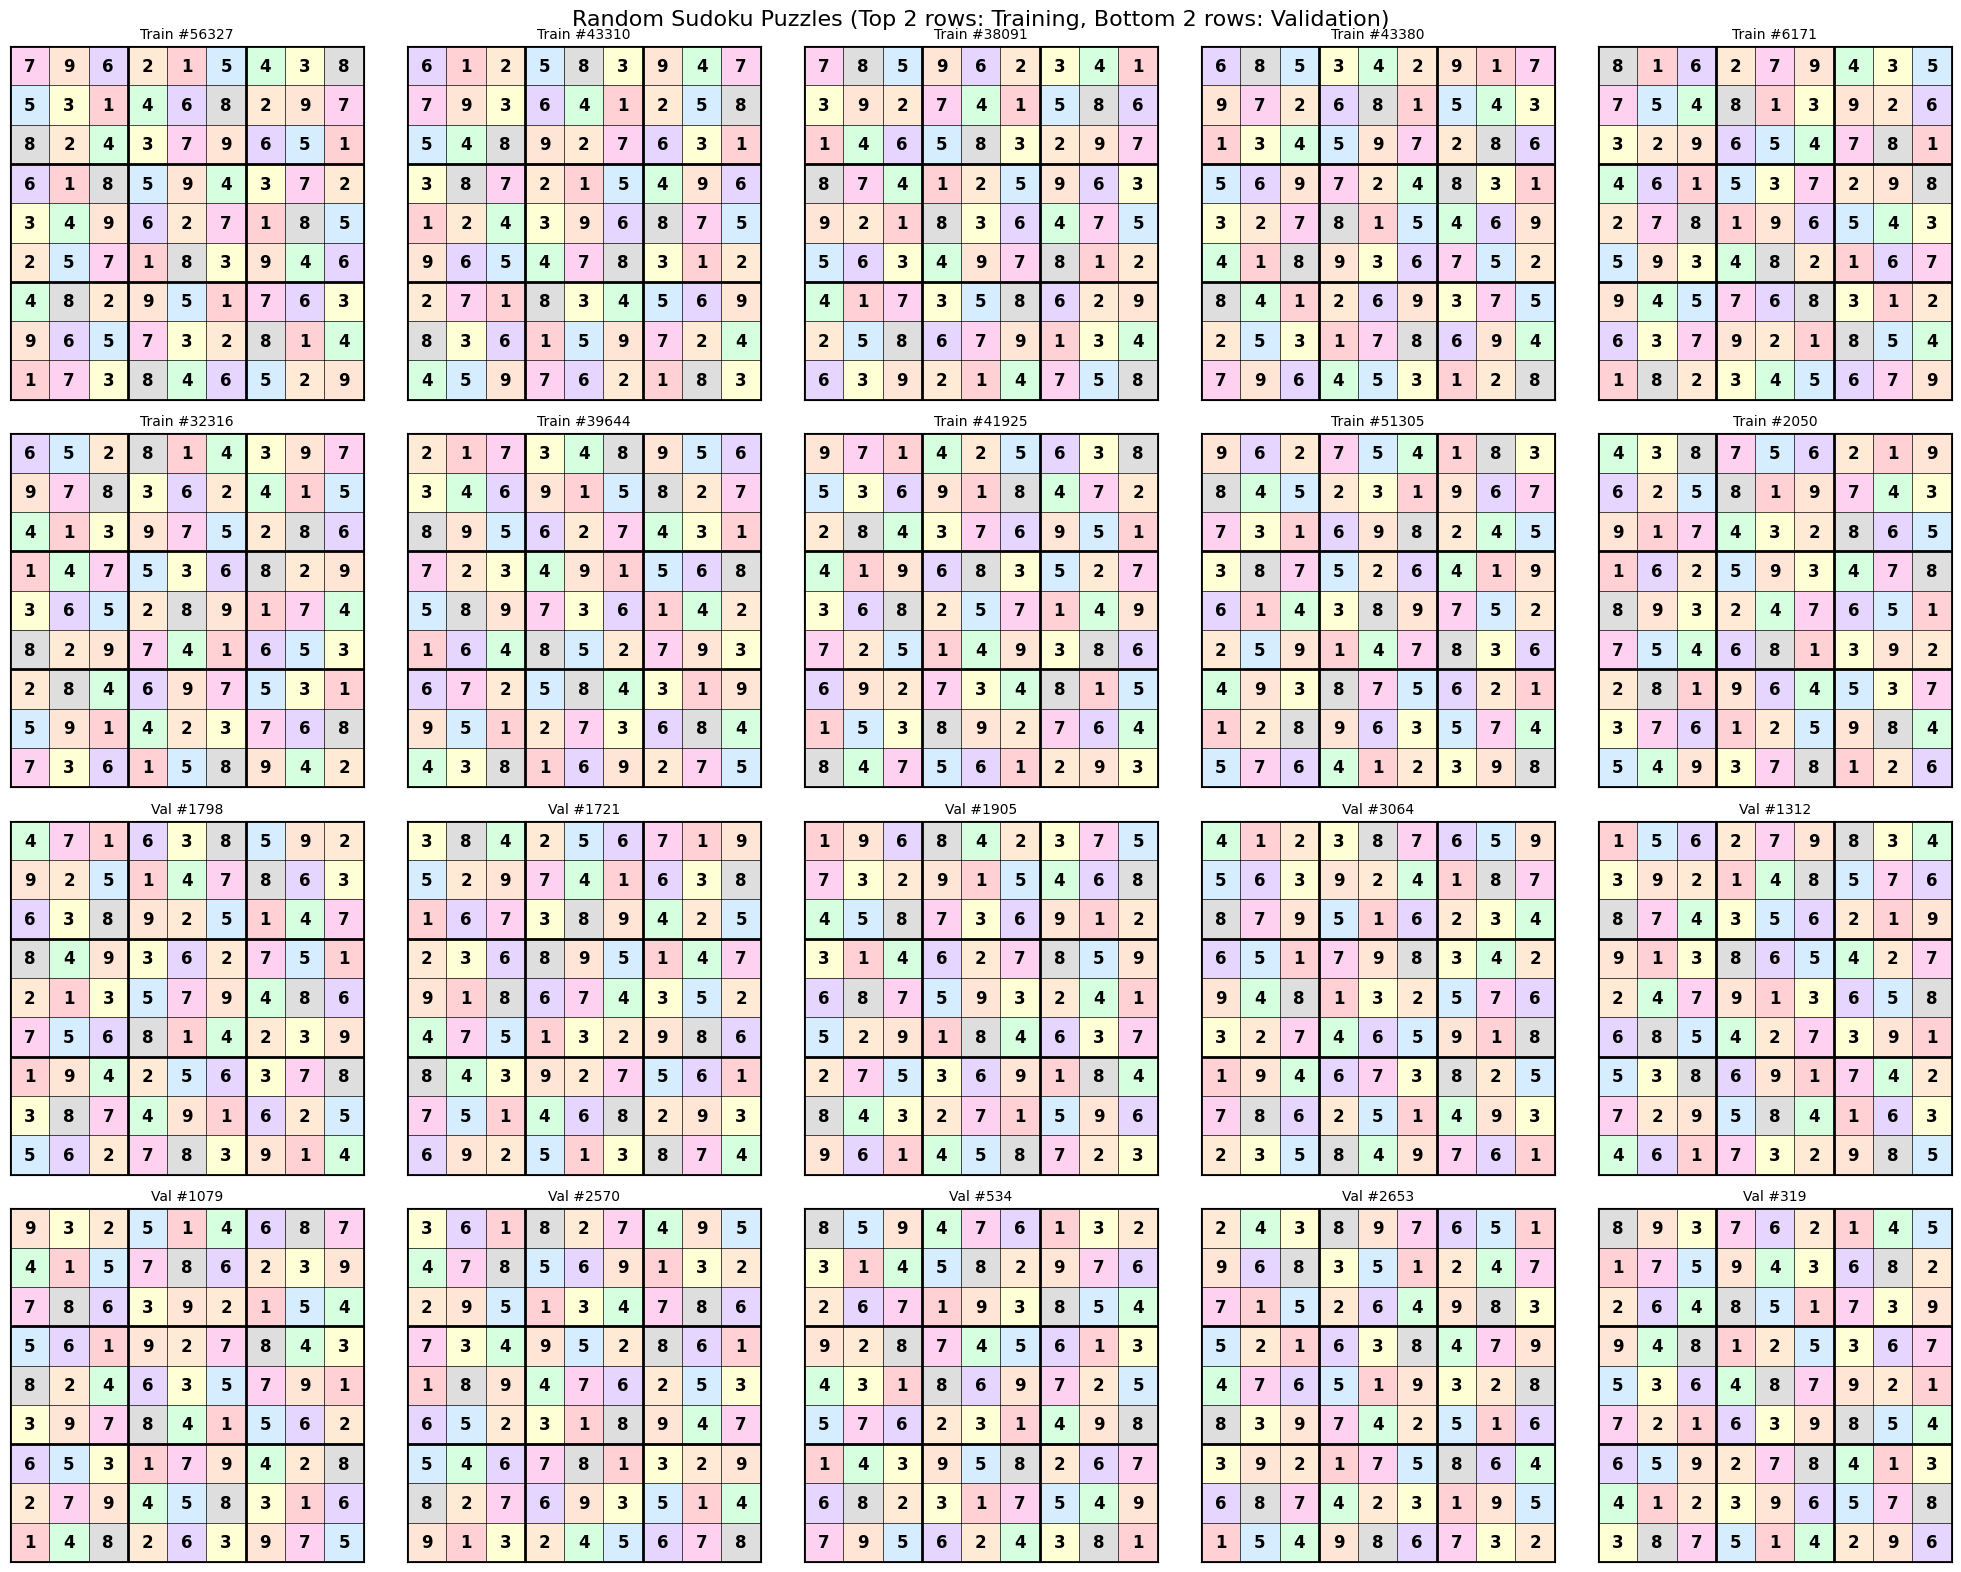

In [40]:
# Check if we have a cached dataset
DATASET_CACHE_PATH = 'sudoku_dataset_cache.pt'

if os.path.exists(DATASET_CACHE_PATH):
    print(f"Loading cached dataset from {DATASET_CACHE_PATH}")
    cache = torch.load(DATASET_CACHE_PATH, map_location=device)
    target = cache['target']
    position = cache['position']
    puzzles = cache['puzzles']
    original_puzzle = cache['original_puzzle']
    val_target = cache['val_target']
    val_position = cache['val_position']
    val_puzzles = cache['val_puzzles']
    val_original_puzzle = cache['val_original_puzzle']
    print("✓ Dataset loaded from cache")
else:
    print("Generating new dataset (this may take a few minutes)...")
    generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
    target, position, puzzles, original_puzzle = generator.generate_target_context_pairs(size=TRAIN_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)
    val_target, val_position, val_puzzles, val_original_puzzle = generator.generate_target_context_pairs(size=VAL_PUZZLES, k=SAMPLES_PER_PUZZLE, shuffle=True)
    
    # Save the generated dataset to cache
    print(f"Saving dataset to cache: {DATASET_CACHE_PATH}")
    torch.save({
        'target': target,
        'position': position,
        'puzzles': puzzles,
        'original_puzzle': original_puzzle,
        'val_target': val_target,
        'val_position': val_position,
        'val_puzzles': val_puzzles,
        'val_original_puzzle': val_original_puzzle,
    }, DATASET_CACHE_PATH)
    print("✓ Dataset saved to cache")

print(f"Training data shapes:")
print(f"  target: {target.shape}, dtype: {target.dtype}")
print(f"  position: {position.shape}, dtype: {position.dtype}")
print(f"  puzzles: {puzzles.shape}, dtype: {puzzles.dtype}")
print(f"  original_puzzle: {original_puzzle.shape}, dtype: {original_puzzle.dtype}")
print(f"\nValidation data shapes:")
print(f"  val_target: {val_target.shape}, dtype: {val_target.dtype}")
print(f"  val_position: {val_position.shape}, dtype: {val_position.dtype}")
print(f"  val_puzzles: {val_puzzles.shape}, dtype: {val_puzzles.dtype}")
print(f"  val_original_puzzle: {val_original_puzzle.shape}, dtype: {val_original_puzzle.dtype}")

# Visualize some random sudoku puzzles from training and validation sets
def visualize_sudoku(puzzle, title="Sudoku Puzzle"):
    """Visualize a single sudoku puzzle"""
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Convert to numpy if tensor
    if torch.is_tensor(puzzle):
        puzzle = puzzle.cpu().numpy()
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
    return fig, ax

# Define colors for each number (1-9)
number_colors = {
    1: '#FFB3BA',  # Light red
    2: '#FFDFBA',  # Light orange
    3: '#FFFFBA',  # Light yellow
    4: '#BAFFC9',  # Light green
    5: '#BAE1FF',  # Light blue
    6: '#D4BAFF',  # Light purple
    7: '#FFB3E6',  # Light pink
    8: '#C9C9C9',  # Light gray
    9: '#FFD4BA',  # Light peach
}

# Select 10 random indices from training set
train_indices = np.random.choice(len(puzzles), size=min(10, len(puzzles)), replace=False)

# Select 10 random indices from validation set
val_indices = np.random.choice(len(val_puzzles), size=min(10, len(val_puzzles)), replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Random Sudoku Puzzles (Top 2 rows: Training, Bottom 2 rows: Validation)', fontsize=16)

# Plot training puzzles
for idx, train_idx in enumerate(train_indices):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = puzzles[train_idx].cpu().numpy() if torch.is_tensor(puzzles[train_idx]) else puzzles[train_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Train #{train_idx}', fontsize=10)

# Plot validation puzzles
for idx, val_idx in enumerate(val_indices):
    row = (idx // 5) + 2  # Start from row 2
    col = idx % 5
    ax = axes[row, col]
    
    puzzle = val_puzzles[val_idx].cpu().numpy() if torch.is_tensor(val_puzzles[val_idx]) else val_puzzles[val_idx]
    
    # Fill cells with colors based on numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                color = number_colors[puzzle[i, j]]
                rect = mpatches.Rectangle((j, i), 1, 1, linewidth=0, 
                                         edgecolor='none', facecolor=color, alpha=0.6)
                ax.add_patch(rect)
    
    # Draw the grid
    for i in range(10):
        linewidth = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=linewidth)
        ax.axvline(i, color='black', linewidth=linewidth)
    
    # Fill in the numbers
    for i in range(9):
        for j in range(9):
            if puzzle[i, j] != 0:
                ax.text(j + 0.5, i + 0.5, str(puzzle[i, j]), 
                       ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Val #{val_idx}', fontsize=10)

plt.tight_layout()
plt.show()



✓ Learning rate scheduler initialized: CosineAnnealingLR
  - Initial LR: 0.001
  - Min LR: 1e-6
  - T_max: 100 epochs
Starting training from scratch
	Epoch 1/100, LR: 0.001000, Average Loss: 0.764458 Positive Loss:0.764458 Negative Loss:0.000000 Train Accuracy: 0.074867 (7.49%) Time: 1.08s
	Epoch 2/100, LR: 0.001000, Average Loss: 0.631249 Positive Loss:0.631249 Negative Loss:0.000000 Train Accuracy: 0.110867 (11.09%) Time: 1.27s
	Epoch 3/100, LR: 0.000999, Average Loss: 0.572642 Positive Loss:0.572642 Negative Loss:0.000000 Train Accuracy: 0.133667 (13.37%) Time: 1.29s
	Epoch 4/100, LR: 0.000998, Average Loss: 0.347541 Positive Loss:0.347541 Negative Loss:0.000000 Train Accuracy: 0.614550 (61.46%) Time: 1.23s
	Epoch 5/100, LR: 0.000996, Average Loss: 0.249441 Positive Loss:0.249441 Negative Loss:0.000000 Train Accuracy: 0.808500 (80.85%) Time: 1.28s
	Epoch 6/100, LR: 0.000994, Average Loss: 0.216589 Positive Loss:0.216589 Negative Loss:0.000000 Train Accuracy: 0.846767 (84.68%) Time: 

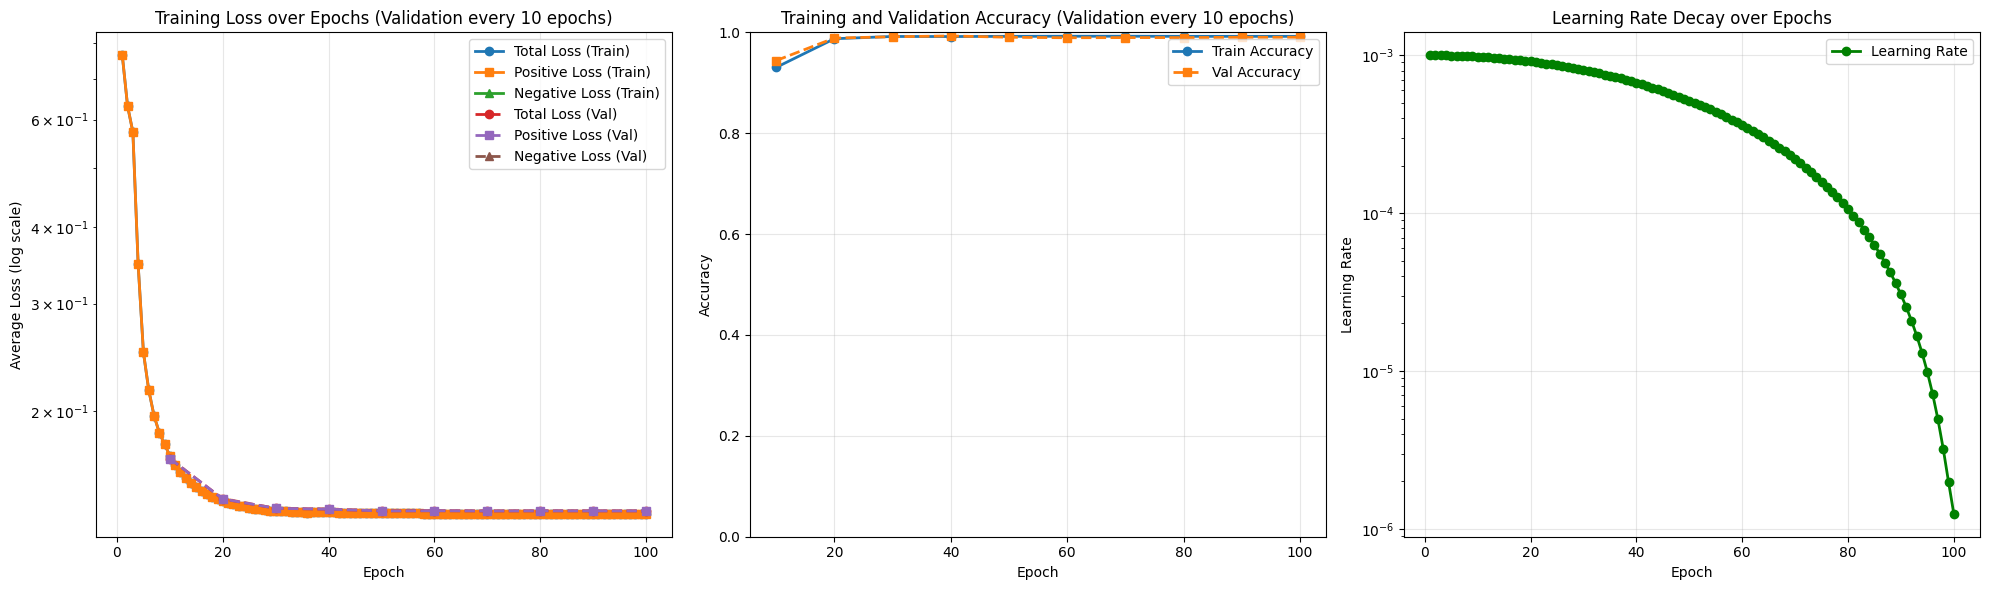

In [41]:
epoch_losses = []
epoch_positive_losses = []
epoch_negative_losses = []
val_epoch_losses = []
val_epoch_positive_losses = []
val_epoch_negative_losses = []
validation_epochs = []  # Track which epochs we validated on
train_accuracies = []  # Track training accuracies
val_accuracies = []  # Track validation accuracies
learning_rates = []  # Track learning rate over epochs

# Learning Rate Scheduler Setup
# Using CosineAnnealingLR for smooth decay from initial LR to min_lr
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-6)
print(f"✓ Learning rate scheduler initialized: CosineAnnealingLR")
print(f"  - Initial LR: {LEARNING_RATE}")
print(f"  - Min LR: 1e-6")
print(f"  - T_max: {N_EPOCHS} epochs")

# Checkpoint loading
start_epoch = 0
if LOAD_CHECKPOINT and os.path.exists(LOAD_CHECKPOINT):
    print(f"Loading checkpoint from {LOAD_CHECKPOINT}")
    checkpoint = torch.load(LOAD_CHECKPOINT, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    epoch_losses = checkpoint.get('epoch_losses', [])
    epoch_positive_losses = checkpoint.get('epoch_positive_losses', [])
    epoch_negative_losses = checkpoint.get('epoch_negative_losses', [])
    val_epoch_losses = checkpoint.get('val_epoch_losses', [])
    val_epoch_positive_losses = checkpoint.get('val_epoch_positive_losses', [])
    val_epoch_negative_losses = checkpoint.get('val_epoch_negative_losses', [])
    validation_epochs = checkpoint.get('validation_epochs', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    learning_rates = checkpoint.get('learning_rates', [])
    if USE_AMP and scaler is not None:
        scaler.load_state_dict(checkpoint.get('scaler_state_dict', {}))
    
    # Load scheduler state if available
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"✓ Scheduler state loaded")
    
    # Load hyperparameters from checkpoint
    loaded_hp = checkpoint.get('hyperparameters', {})
    print(f"Resuming from epoch {start_epoch}")
    print(f"Loaded hyperparameters: {loaded_hp}")
else:
    print("Starting training from scratch")

for epoch in range(start_epoch, N_EPOCHS):
    epoch_start_time = time.time()
    model.train()  # Set model to training mode
    epoch_loss = 0.0
    epoch_positive_loss = 0.0
    epoch_negative_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = 0
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Loop over batches
    for i in range(0, len(target), BATCH_SIZE):
        # Get batch and ensure it's on the correct device
        batch_target = target[i:i+BATCH_SIZE].long().to(device)
        batch_position = position[i:i+BATCH_SIZE].long().to(device)
        batch_puzzles = puzzles[i:i+BATCH_SIZE].long().to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Mixed precision training with autocast
        if USE_AMP:
            with torch.autocast(device_type=device.type, dtype=amp_dtype):
                # Compute loss
                loss, negative_loss, positive_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Update weights with gradient unscaling
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training without mixed precision
            loss, negative_loss, positive_loss, accuracy = model.loss(batch_target, batch_position, batch_puzzles)
            loss.backward()
            optimizer.step()
        
        # Track loss and accuracy
        batch_size = batch_puzzles.shape[0]
        epoch_loss += loss.item()
        epoch_positive_loss += positive_loss.item()
        epoch_negative_loss += negative_loss.item()
        epoch_correct += (accuracy * batch_size).item()
        epoch_total += batch_size
        num_batches += 1
    
    # Step the learning rate scheduler after each epoch
    scheduler.step()
    
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch statistics
    avg_loss = epoch_loss / num_batches
    avg_positive_loss = epoch_positive_loss / num_batches
    avg_negative_loss = epoch_negative_loss / num_batches
    train_accuracy = epoch_correct / epoch_total
    epoch_losses.append(avg_loss)
    epoch_positive_losses.append(avg_positive_loss)
    epoch_negative_losses.append(avg_negative_loss)
    print(f"\tEpoch {epoch+1}/{N_EPOCHS}, LR: {current_lr:.6f}, Average Loss: {avg_loss:.6f} Positive Loss:{avg_positive_loss:.6f} Negative Loss:{avg_negative_loss:.6f} Train Accuracy: {train_accuracy:.6f} ({train_accuracy*100:.2f}%) Time: {epoch_time:.2f}s")
    
    # Evaluate on validation set every VALIDATE_PERIOD epochs
    if (epoch + 1) % VALIDATE_PERIOD == 0 or (epoch + 1) == N_EPOCHS:
        val_start_time = time.time()
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_positive_loss = 0.0
        val_negative_loss = 0.0
        val_num_batches = 0
        
        # Store training accuracy for this validation epoch
        train_accuracies.append(train_accuracy)
        
        # Calculate validation accuracy and loss
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            # Also use autocast for validation for consistency
            with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
                for i in range(0, len(val_target), BATCH_SIZE):
                    # Get validation batch and ensure it's on the correct device
                    val_batch_target = val_target[i:i+BATCH_SIZE].long().to(device)
                    val_batch_position = val_position[i:i+BATCH_SIZE].long().to(device)
                    val_batch_puzzles = val_puzzles[i:i+BATCH_SIZE].long().to(device)
                    
                    # Compute validation loss and accuracy
                    loss, negative_loss, positive_loss, accuracy = model.loss(val_batch_target, val_batch_position, val_batch_puzzles)
                    
                    # Track validation loss
                    val_loss += loss.item()
                    val_positive_loss += positive_loss.item()
                    val_negative_loss += negative_loss.item()
                    val_num_batches += 1
                    
                    # Track accuracy
                    batch_size = val_batch_puzzles.shape[0]
                    val_correct += (accuracy * batch_size).item()
                    val_total += batch_size
        
        val_time = time.time() - val_start_time
        
        # Print validation statistics
        avg_val_loss = val_loss / val_num_batches
        avg_val_positive_loss = val_positive_loss / val_num_batches
        avg_val_negative_loss = val_negative_loss / val_num_batches
        val_accuracy = val_correct / val_total
        val_epoch_losses.append(avg_val_loss)
        val_epoch_positive_losses.append(avg_val_positive_loss)
        val_epoch_negative_losses.append(avg_val_negative_loss)
        val_accuracies.append(val_accuracy)
        validation_epochs.append(epoch + 1)
        print(f"\t✓ Validation Loss: {avg_val_loss:.6f} Positive Loss:{avg_val_positive_loss:.6f} Negative Loss:{avg_val_negative_loss:.6f}")
        print(f"\t✓ Val Accuracy: {val_accuracy:.6f} ({val_accuracy*100:.2f}%) Inference Time: {val_time:.2f}s")
    
    # Save checkpoint every CHECKPOINT_PERIOD epochs
    if SAVE_CHECKPOINT and (epoch + 1) % CHECKPOINT_PERIOD == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch_losses': epoch_losses,
            'epoch_positive_losses': epoch_positive_losses,
            'epoch_negative_losses': epoch_negative_losses,
            'val_epoch_losses': val_epoch_losses,
            'val_epoch_positive_losses': val_epoch_positive_losses,
            'val_epoch_negative_losses': val_epoch_negative_losses,
            'validation_epochs': validation_epochs,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'learning_rates': learning_rates,
            'hyperparameters': {
                'N_EPOCHS': N_EPOCHS,
                'LEARNING_RATE': LEARNING_RATE,
                'ATTENTION_DIM': ATTENTION_DIM,
                'N_HEADS': N_HEADS,
                'EMBEDDING_DIM': EMBEDDING_DIM,
                'TRAIN_PUZZLES': TRAIN_PUZZLES,
                'VAL_PUZZLES': VAL_PUZZLES,
                'BATCH_SIZE': BATCH_SIZE,
                'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
                'NEGATIVE_SAMPLES_SIZE': NEGATIVE_SAMPLES_SIZE,
                'USE_NEGATIVE_SAMPLES': USE_NEGATIVE_SAMPLES,
            }
        }
        if USE_AMP and scaler is not None:
            checkpoint['scaler_state_dict'] = scaler.state_dict()
        
        checkpoint_path = get_checkpoint_filename(epoch + 1)
        torch.save(checkpoint, checkpoint_path)
        print(f"\t💾 Checkpoint saved at {checkpoint_path}")

# Save final checkpoint
if SAVE_CHECKPOINT:
    checkpoint = {
        'epoch': N_EPOCHS - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch_losses': epoch_losses,
        'epoch_positive_losses': epoch_positive_losses,
        'epoch_negative_losses': epoch_negative_losses,
        'val_epoch_losses': val_epoch_losses,
        'val_epoch_positive_losses': val_epoch_positive_losses,
        'val_epoch_negative_losses': val_epoch_negative_losses,
        'validation_epochs': validation_epochs,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'hyperparameters': {
            'N_EPOCHS': N_EPOCHS,
            'LEARNING_RATE': LEARNING_RATE,
            'ATTENTION_DIM': ATTENTION_DIM,
            'N_HEADS': N_HEADS,
            'EMBEDDING_DIM': EMBEDDING_DIM,
            'TRAIN_PUZZLES': TRAIN_PUZZLES,
            'VAL_PUZZLES': VAL_PUZZLES,
            'BATCH_SIZE': BATCH_SIZE,
            'SAMPLES_PER_PUZZLE': SAMPLES_PER_PUZZLE,
            'NEGATIVE_SAMPLES_SIZE': NEGATIVE_SAMPLES_SIZE,
            'USE_NEGATIVE_SAMPLES': USE_NEGATIVE_SAMPLES,
        }
    }
    if USE_AMP and scaler is not None:
        checkpoint['scaler_state_dict'] = scaler.state_dict()
    
    checkpoint_path = get_checkpoint_filename()
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Final checkpoint saved at {checkpoint_path}")
    
    # Also save the model in a portable format for easy loading
    model_path = os.path.join(CHECKPOINT_DIR, f"sudoku2vec_final_emb{EMBEDDING_DIM}.pt")
    model.save_model(model_path)
    print(f"💾 Portable model saved at {model_path}")

# Plot the loss curves, accuracy, and learning rate
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Loss plot
ax1.plot(range(1, N_EPOCHS + 1), epoch_losses, marker='o', linestyle='-', linewidth=2, label='Total Loss (Train)')
ax1.plot(range(1, N_EPOCHS + 1), epoch_positive_losses, marker='s', linestyle='-', linewidth=2, label='Positive Loss (Train)')
ax1.plot(range(1, N_EPOCHS + 1), epoch_negative_losses, marker='^', linestyle='-', linewidth=2, label='Negative Loss (Train)')

# Plot validation at the epochs where it was actually run
ax1.plot(validation_epochs, val_epoch_losses, marker='o', linestyle='--', linewidth=2, label='Total Loss (Val)')
ax1.plot(validation_epochs, val_epoch_positive_losses, marker='s', linestyle='--', linewidth=2, label='Positive Loss (Val)')
ax1.plot(validation_epochs, val_epoch_negative_losses, marker='^', linestyle='--', linewidth=2, label='Negative Loss (Val)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss (log scale)')
ax1.set_title(f'Training Loss over Epochs (Validation every {VALIDATE_PERIOD} epochs)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(validation_epochs, train_accuracies, marker='o', linestyle='-', linewidth=2, label='Train Accuracy')
ax2.plot(validation_epochs, val_accuracies, marker='s', linestyle='--', linewidth=2, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title(f'Training and Validation Accuracy (Validation every {VALIDATE_PERIOD} epochs)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# Learning rate plot
ax3.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o', linestyle='-', linewidth=2, color='green', label='Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Decay over Epochs')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generating 100 sudoku grids for t-SNE visualization...
Generated 100 puzzles
Target tokens shape: torch.Size([100])
Positions shape: torch.Size([100, 2])
Puzzles shape: torch.Size([100, 9, 9])

Extracted embeddings at masked positions: (100, 10)
Embedding dimension: 10

Applying t-SNE (this may take a moment)...
t-SNE completed. Reduced to shape: (100, 2)


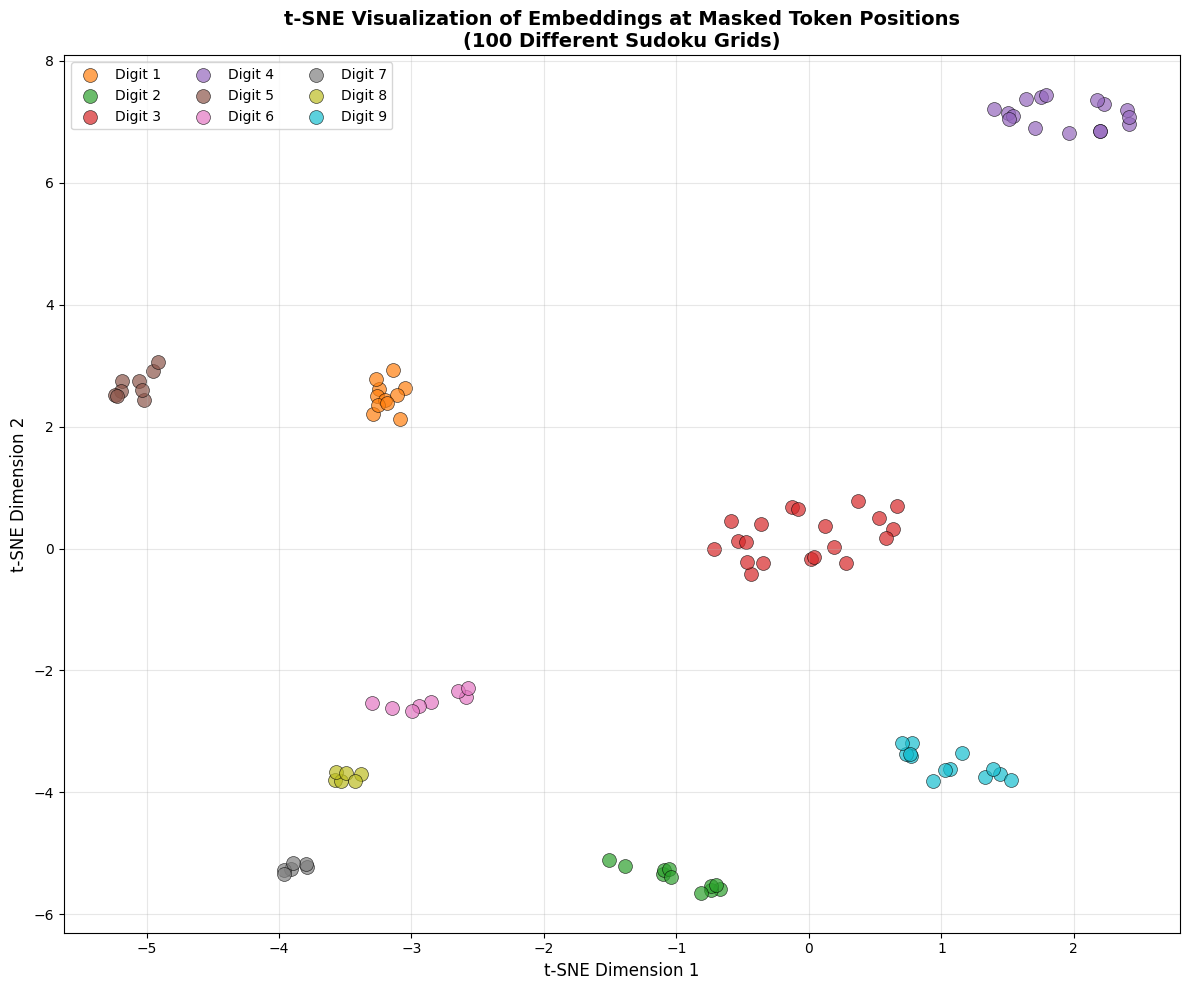


Statistics:
Total samples: 100
Digit distribution:
  Digit 1: 11 samples (11.0%)
  Digit 2: 11 samples (11.0%)
  Digit 3: 20 samples (20.0%)
  Digit 4: 16 samples (16.0%)
  Digit 5: 9 samples (9.0%)
  Digit 6: 8 samples (8.0%)
  Digit 7: 6 samples (6.0%)
  Digit 8: 6 samples (6.0%)
  Digit 9: 13 samples (13.0%)

Embedding statistics:
  Mean: 0.0001
  Std: 0.0094
  Min: -0.0374
  Max: 0.0283


In [42]:
# t-SNE Visualization of Embeddings at Masked Positions

from sklearn.manifold import TSNE

print("Generating 100 sudoku grids for t-SNE visualization...")

# Generate 100 different sudoku grids with 1 sample per puzzle (100 masked positions total)
tsne_target, tsne_position, tsne_puzzles, tsne_original = generator.generate_target_context_pairs(
    size=100, k=1, shuffle=True
)

print(f"Generated {len(tsne_target)} puzzles")
print(f"Target tokens shape: {tsne_target.shape}")
print(f"Positions shape: {tsne_position.shape}")
print(f"Puzzles shape: {tsne_puzzles.shape}")

# Set model to evaluation mode
model.eval()

# Get embeddings at masked positions
all_embeddings = []
all_targets = []
all_positions = []

with torch.no_grad():
    # Use autocast for consistency
    with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
        # Process all samples at once (they're only 100)
        batch_target = tsne_target.long().to(device)
        batch_position = tsne_position.long().to(device)
        batch_puzzles = tsne_puzzles.long().to(device)
        
        # Forward pass
        output, attention, target_token_with_position, grid_embeddings_flat = model.forward(
            batch_target, batch_position, batch_puzzles, mask=True
        )
        
        # Extract only the embedding portion (without position vectors) from output
        # output is [batch, 81, total_dim] where total_dim = embedding_dim + 2
        output_embeddings = output[:, :, :model.embedding_dim]  # shape [batch, 81, embedding_dim]
        
        # Extract embeddings at masked positions
        batch_indices = torch.arange(len(batch_target), device=device)
        linear_indices = batch_position[:, 1] * 9 + batch_position[:, 0]  # [batch]
        
        # Get output embeddings at target positions
        embeddings_at_masked = output_embeddings[batch_indices, linear_indices, :]  # [batch, embedding_dim]
        
        # Convert to numpy for t-SNE
        embeddings_np = embeddings_at_masked.cpu().float().numpy()
        targets_np = batch_target.cpu().numpy()
        positions_np = batch_position.cpu().numpy()

print(f"\nExtracted embeddings at masked positions: {embeddings_np.shape}")
print(f"Embedding dimension: {embeddings_np.shape[1]}")

# Apply t-SNE to reduce to 2D
print("\nApplying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_np)

print(f"t-SNE completed. Reduced to shape: {embeddings_2d.shape}")

# Visualize the t-SNE embeddings
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Color by target digit (1-9)
# Create a colormap for digits 1-9
colors = plt.cm.tab10(np.linspace(0, 1, 10))
digit_colors = {i: colors[i] for i in range(10)}

# Plot each point colored by its target digit
for digit in range(1, 10):  # Digits 1-9
    mask = targets_np == digit
    if mask.any():
        ax.scatter(
            embeddings_2d[mask, 0], 
            embeddings_2d[mask, 1], 
            c=[digit_colors[digit]], 
            label=f'Digit {digit}',
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('t-SNE Visualization of Embeddings at Masked Token Positions\n(100 Different Sudoku Grids)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, ncol=3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics:")
print(f"Total samples: {len(embeddings_2d)}")
print(f"Digit distribution:")
for digit in range(1, 10):
    count = (targets_np == digit).sum()
    print(f"  Digit {digit}: {count} samples ({count/len(targets_np)*100:.1f}%)")

print("\nEmbedding statistics:")
print(f"  Mean: {embeddings_np.mean():.4f}")
print(f"  Std: {embeddings_np.std():.4f}")
print(f"  Min: {embeddings_np.min():.4f}")
print(f"  Max: {embeddings_np.max():.4f}")


# Weights & Biases (wandb) Tutorial

This section introduces **Weights & Biases (wandb)** for hyperparameter sweeps and experiment tracking.

## What is wandb?

Weights & Biases is a platform for:
- **Experiment Tracking**: Automatically log metrics, hyperparameters, and system info
- **Visualization**: Create real-time plots and compare experiments
- **Hyperparameter Optimization**: Run sweeps with grid search, random search, or Bayesian optimization
- **Collaboration**: Share results with your team via a web dashboard

## Setup Instructions

1. **Install wandb**:
   ```bash
   pip install wandb
   ```

2. **Create an account**: Go to [https://wandb.ai](https://wandb.ai) and sign up (free)

3. **Login**: Run in a terminal or notebook cell:
   ```python
   import wandb
   wandb.login()
   ```
   Copy your API key when prompted.

## Key Concepts

### 1. **wandb.init()** - Start a run
Initializes a new experiment run. This sets up tracking and creates a unique run ID.

```python
run = wandb.init(project="my-project", config={"lr": 0.001, "epochs": 10})
```

### 2. **wandb.config** - Access hyperparameters
Access the configuration for the current run (useful in sweeps).

```python
lr = wandb.config.learning_rate
```

### 3. **wandb.log()** - Log metrics
Log metrics at each training step/epoch. These appear as plots in the dashboard.

```python
wandb.log({"loss": 0.5, "accuracy": 0.9}, step=epoch)
```

### 4. **wandb.finish()** - End a run
Finishes the current run and uploads all data to the wandb servers.

```python
wandb.finish()
```

### 5. **wandb.sweep()** - Create a sweep
Creates a hyperparameter sweep with a configuration dictionary.

```python
sweep_id = wandb.sweep(sweep_config, project="my-project")
```

### 6. **wandb.agent()** - Run a sweep
Runs multiple training runs with different hyperparameter configurations.

```python
wandb.agent(sweep_id, function=train_function, count=10)
```

## Sweep Methods

- **Grid Search** (`method: 'grid'`): Try all combinations (exhaustive)
- **Random Search** (`method: 'random'`): Random sampling (faster)
- **Bayesian Optimization** (`method: 'bayes'`): Intelligent search based on previous results

## Next Steps

The following cells demonstrate:
1. A simple single-run example (for learning)
2. A full hyperparameter sweep over learning_rate, embedding_dim, attention_dim, and n_heads


In [27]:
################################################################################
# SIMPLE WANDB EXAMPLE - Single Training Run
################################################################################
# This is a simplified example to help you understand wandb basics before
# running the full hyperparameter sweep.
#
# This cell demonstrates:
# 1. How to initialize a wandb run
# 2. How to log metrics during training
# 3. How to finish a run
#
# Run this cell first to familiarize yourself with wandb!
################################################################################

import wandb

print("="*80)
print("SIMPLE WANDB EXAMPLE - Single Training Run")
print("="*80)
print("\nThis is a simple example to help you learn wandb basics.")
print("We'll train one model and log metrics to wandb.\n")

# ============================================================================
# STEP 1: Initialize a wandb run
# ============================================================================
# wandb.init() starts a new run and returns a run object
# - project: Name of your project (will be created if it doesn't exist)
# - name: Optional name for this specific run
# - config: Dictionary of hyperparameters to track

print("Initializing wandb run...")

run = wandb.init(
    project='sudoku-llm-simple-example',  # Project name
    name='example-run-lr-0.001',          # Run name (optional)
    config={                              # Hyperparameters to track
        'learning_rate': 0.001,
        'embedding_dim': 15,
        'attention_dim': 9,
        'n_heads': 9,
        'epochs': 20,
        'batch_size': 512,
    }
)

print(f"✓ wandb run initialized: {run.name}")
print(f"  Run ID: {run.id}")
print(f"  Project: {run.project}")
print(f"  View at: {run.url}\n")

# ============================================================================
# STEP 2: Access hyperparameters from wandb.config
# ============================================================================
# wandb.config contains the hyperparameters we set in wandb.init()

config = wandb.config
print("Hyperparameters from wandb.config:")
print(f"  learning_rate: {config.learning_rate}")
print(f"  embedding_dim: {config.embedding_dim}")
print(f"  attention_dim: {config.attention_dim}")
print(f"  n_heads: {config.n_heads}")
print(f"  epochs: {config.epochs}\n")

# ============================================================================
# STEP 3: Generate dataset (reuse if already cached)
# ============================================================================

# Check if we already have the dataset from the main training (Cell 5)
# If not, generate a smaller dataset for this example
try:
    # Try to use the main training dataset if it exists
    exp_target = target[:20000]
    exp_position = position[:20000]
    exp_puzzles = puzzles[:20000]
    exp_val_target = val_target[:1024]
    exp_val_position = val_position[:1024]
    exp_val_puzzles = val_puzzles[:1024]
    print("✓ Using existing dataset from Cell 5\n")
except NameError:
    # If the main dataset doesn't exist, generate a new one
    print("Generating dataset for this example...")
    experiment_generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
    
    exp_target, exp_position, exp_puzzles, _ = \
        experiment_generator.generate_target_context_pairs(size=10000, k=2, shuffle=True)
    
    exp_val_target, exp_val_position, exp_val_puzzles, _ = \
        experiment_generator.generate_target_context_pairs(size=512, k=2, shuffle=True)
    
    print("✓ Dataset generated\n")

# ============================================================================
# STEP 4: Create and train model
# ============================================================================

print("Creating model...")
exp_model = Sudoku2Vec(
    vocab_size=10,
    embedding_dim=config.embedding_dim,
    attention_dim=config.attention_dim,
    num_heads=config.n_heads,
    device=device
)

# Convert to bfloat16 if supported
if device.type == 'cuda' and torch.cuda.is_bf16_supported():
    exp_model = exp_model.to(dtype=torch.bfloat16)
elif device.type == 'cpu':
    exp_model = exp_model.to(dtype=torch.bfloat16)

# Create optimizer
if device.type == 'cuda':
    try:
        exp_optimizer = optim.Adam(exp_model.parameters(), lr=config.learning_rate, fused=True)
    except:
        exp_optimizer = optim.Adam(exp_model.parameters(), lr=config.learning_rate)
else:
    exp_optimizer = optim.Adam(exp_model.parameters(), lr=config.learning_rate)

# Create scheduler
exp_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    exp_optimizer, T_max=config.epochs, eta_min=1e-6
)

print("✓ Model created")
print(f"  Parameters: {sum(p.numel() for p in exp_model.parameters()):,}\n")

print("Starting training...")
print("="*80)

# ============================================================================
# STEP 5: Training loop with wandb logging
# ============================================================================

global_step = 0  # Track global step across all epochs

for epoch in range(config.epochs):
    # Training phase
    exp_model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = 0
    
    for i in range(0, len(exp_target), config.batch_size):
        batch_target = exp_target[i:i+config.batch_size].long().to(device)
        batch_position = exp_position[i:i+config.batch_size].long().to(device)
        batch_puzzles = exp_puzzles[i:i+config.batch_size].long().to(device)
        
        exp_optimizer.zero_grad()
        
        if USE_AMP:
            with torch.autocast(device_type=device.type, dtype=amp_dtype):
                loss, _, _, accuracy = exp_model.loss(batch_target, batch_position, batch_puzzles)
            scaler.scale(loss).backward()
            scaler.step(exp_optimizer)
            scaler.update()
        else:
            loss, _, _, accuracy = exp_model.loss(batch_target, batch_position, batch_puzzles)
            loss.backward()
            exp_optimizer.step()
        
        batch_size_actual = batch_puzzles.shape[0]
        epoch_loss += loss.item()
        epoch_correct += (accuracy * batch_size_actual).item()
        epoch_total += batch_size_actual
        num_batches += 1
        
        # ====================================================================
        # WANDB LOGGING: Log batch metrics
        # ====================================================================
        # Log every batch's loss and accuracy
        current_lr = exp_optimizer.param_groups[0]['lr']
        
        wandb.log({
            'batch_loss': loss.item(),
            'batch_accuracy': accuracy,
            'learning_rate': current_lr,
            'epoch': epoch,
        }, step=global_step)
        
        global_step += 1
    
    # Step scheduler
    exp_scheduler.step()
    
    # Calculate epoch-level training metrics for printing
    avg_train_loss = epoch_loss / num_batches
    train_accuracy = epoch_correct / epoch_total
    
    # Log epoch-level aggregated metrics
    wandb.log({
        'epoch_train_loss': avg_train_loss,
        'epoch_train_accuracy': train_accuracy,
    }, step=global_step)
    
    # Validation phase (every 5 epochs)
    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == config.epochs - 1:
        exp_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_num_batches = 0
        
        with torch.no_grad():
            with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
                for i in range(0, len(exp_val_target), config.batch_size):
                    val_batch_target = exp_val_target[i:i+config.batch_size].long().to(device)
                    val_batch_position = exp_val_position[i:i+config.batch_size].long().to(device)
                    val_batch_puzzles = exp_val_puzzles[i:i+config.batch_size].long().to(device)
                    
                    loss, _, _, accuracy = exp_model.loss(val_batch_target, val_batch_position, val_batch_puzzles)
                    
                    batch_size_actual = val_batch_puzzles.shape[0]
                    val_loss += loss.item()
                    val_correct += (accuracy * batch_size_actual).item()
                    val_total += batch_size_actual
                    val_num_batches += 1
                    
                    # ========================================================
                    # WANDB LOGGING: Log validation batch metrics
                    # ========================================================
                    wandb.log({
                        'val_batch_loss': loss.item(),
                        'val_batch_accuracy': accuracy,
                    }, step=global_step)
                    
                    global_step += 1
        
        # Calculate validation metrics
        avg_val_loss = val_loss / val_num_batches
        val_accuracy = val_correct / val_total
        
        # ====================================================================
        # WANDB LOGGING: Log epoch-level validation metrics
        # ====================================================================
        
        wandb.log({
            'epoch_val_loss': avg_val_loss,
            'epoch_val_accuracy': val_accuracy,
        }, step=global_step)
        
        print(f"Epoch {epoch+1:3d}/{config.epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# ============================================================================
# STEP 6: Log final summary statistics
# ============================================================================
# wandb.summary is a dictionary that stores final metrics
# These appear in the runs table for easy comparison

wandb.summary['final_train_loss'] = avg_train_loss
wandb.summary['final_train_accuracy'] = train_accuracy
wandb.summary['final_val_loss'] = avg_val_loss
wandb.summary['final_val_accuracy'] = val_accuracy

print("="*80)
print(f"\n✓ Training complete!")
print(f"  Final Train Accuracy: {train_accuracy:.4f}")
print(f"  Final Val Accuracy: {val_accuracy:.4f}")
print(f"\n  View results at: {run.url}\n")

# ============================================================================
# STEP 7: Finish the wandb run
# ============================================================================
# This uploads all data and marks the run as complete

wandb.finish()

print("✓ wandb run finished and data uploaded")
print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("\n1. Go to the URL above to view your run in the wandb dashboard")
print("2. Explore the charts (loss, accuracy over time)")
print("3. Check the system metrics (GPU usage, memory, etc.)")
print("4. View the hyperparameters in the Overview tab")
print("\n5. Once you're comfortable, run the next cell for a full hyperparameter sweep!")
print("="*80)


SIMPLE WANDB EXAMPLE - Single Training Run

This is a simple example to help you learn wandb basics.
We'll train one model and log metrics to wandb.

Initializing wandb run...


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


✓ wandb run initialized: example-run-lr-0.001
  Run ID: iu8799ey
  Project: sudoku-llm-simple-example
  View at: https://wandb.ai/srafiz/sudoku-llm-simple-example/runs/iu8799ey

Hyperparameters from wandb.config:
  learning_rate: 0.001
  embedding_dim: 15
  attention_dim: 9
  n_heads: 9
  epochs: 20

✓ Using existing dataset from Cell 5

Creating model...
✓ Model created
  Parameters: 806

Starting training...
Epoch   1/20 | Train Loss: 0.8078 | Train Acc: 0.1095 | Val Loss: 0.6444 | Val Acc: 0.1221
Epoch   5/20 | Train Loss: 0.5644 | Train Acc: 0.1103 | Val Loss: 0.5591 | Val Acc: 0.1221
Epoch  10/20 | Train Loss: 0.5451 | Train Acc: 0.1077 | Val Loss: 0.5427 | Val Acc: 0.1006
Epoch  15/20 | Train Loss: 0.5396 | Train Acc: 0.1070 | Val Loss: 0.5386 | Val Acc: 0.0977
Epoch  20/20 | Train Loss: 0.5391 | Train Acc: 0.1080 | Val Loss: 0.5384 | Val Acc: 0.1006

✓ Training complete!
  Final Train Accuracy: 0.1080
  Final Val Accuracy: 0.1006

  View results at: https://wandb.ai/srafiz/sudok

batch_accuracy,▅█▆▃▄▅▄▅▅▅▅▆▂▅▄▅▄▅▅█▇▇▅▇▅▇▅▅▃▄▇▆▁▃▄▁▃▅▃▅
batch_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
epoch_train_accuracy,▇████▅▃▅▄▄▆▄▁▃▃▁▄▃▅▄
epoch_train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_accuracy,██▂▁▂
epoch_val_loss,█▂▁▁▁
learning_rate,█████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_batch_accuracy,▄█▄█▁▆▁▅▁▅
val_batch_loss,█▇▃▂▂▁▂▁▁▁
batch_accuracy,0.09375


✓ wandb run finished and data uploaded

NEXT STEPS

1. Go to the URL above to view your run in the wandb dashboard
2. Explore the charts (loss, accuracy over time)
3. Check the system metrics (GPU usage, memory, etc.)
4. View the hyperparameters in the Overview tab

5. Once you're comfortable, run the next cell for a full hyperparameter sweep!


In [28]:
################################################################################
# HYPERPARAMETER SWEEP WITH WEIGHTS & BIASES (wandb)
################################################################################
# 
# This cell demonstrates how to use Weights & Biases (wandb) for hyperparameter
# sweeps. wandb is a powerful tool for experiment tracking and hyperparameter
# optimization that provides:
#
# 1. **Automatic Logging**: Track metrics, hyperparameters, and system info
# 2. **Visualization**: Real-time plots and comparisons across runs
# 3. **Sweep Optimization**: Intelligent hyperparameter search (grid, random, Bayesian)
# 4. **Reproducibility**: Save code, config, and model artifacts
# 5. **Collaboration**: Share results with your team via web dashboard
#
# INSTALLATION:
# pip install wandb
#
# SETUP:
# 1. Create a free account at https://wandb.ai
# 2. Run: wandb login
# 3. Copy your API key when prompted
#
# DIDACTIC NOTES:
# - wandb.init(): Starts a new run and logs hyperparameters
# - wandb.log(): Logs metrics (loss, accuracy) at each step/epoch
# - wandb.config: Access hyperparameters for the current run
# - wandb.finish(): Ends the run and uploads data
# - wandb.sweep(): Creates a sweep with a configuration
# - wandb.agent(): Runs the sweep by executing multiple training runs
#
################################################################################

import wandb

print("="*80)
print("HYPERPARAMETER SWEEP WITH WEIGHTS & BIASES")
print("="*80)
print("\nThis experiment will sweep over:")
print("  - learning_rate: [1e-4, 5e-4, 1e-3, 2.5e-3, 5e-3]")
print("  - embedding_dim: [10, 15, 20, 30]")
print("  - attention_dim: [9, 18, 27, 36]")
print("  - n_heads: [1, 3, 9]")
print("\nNote: attention_dim must be divisible by n_heads")
print("="*80 + "\n")

# ============================================================================
# STEP 1: Define the Sweep Configuration
# ============================================================================
# The sweep configuration tells wandb:
# - Which hyperparameters to search over
# - What values/ranges to try
# - What optimization strategy to use (grid, random, bayes)
# - What metric to optimize (and whether to minimize or maximize it)

sweep_config = {
    'method': 'grid',  # Options: 'grid', 'random', 'bayes'
    # 'grid': Try all combinations (exhaustive but slow)
    # 'random': Random sampling (faster, good for large spaces)
    # 'bayes': Bayesian optimization (intelligent search, best for expensive runs)
    
    'metric': {
        'name': 'val_accuracy',  # Metric to optimize
        'goal': 'maximize'       # 'maximize' or 'minimize'
    },
    
    'parameters': {
        # Learning rate: Try different values
        'learning_rate': {
            'values': [1e-4, 5e-4, 1e-3, 2.5e-3, 5e-3]
        },
        
        # Embedding dimension: Size of token embeddings
        'embedding_dim': {
            'values': [10, 20, 30]
        },
        
        # Attention dimension: Size of attention mechanism
        'attention_dim': {
            'values': [9, 18, 36]
        },
        
        # Number of attention heads
        'n_heads': {
            'values': [1, 3, 9]
        },
        
        # Fixed hyperparameters (not swept)
        'epochs': {'value': 50},  # Reduced for faster sweeps
        'batch_size': {'value': 512},
        'train_samples': {'value': 20000},
        'val_samples': {'value': 1024},
        'samples_per_puzzle': {'value': 3},
    }
}

# ============================================================================
# STEP 2: Define the Training Function
# ============================================================================
# This function will be called by wandb.agent() for each hyperparameter
# configuration. It must:
# 1. Initialize a wandb run with wandb.init()
# 2. Get hyperparameters from wandb.config
# 3. Train the model
# 4. Log metrics with wandb.log()
# 5. Finish the run with wandb.finish()

def train_with_wandb():
    """
    Training function for a single wandb run.
    This function is called by the wandb agent for each hyperparameter configuration.
    """
    
    # Initialize wandb run - this starts tracking
    # wandb.init() returns a run object and sets up wandb.config with hyperparameters
    run = wandb.init()
    
    # Access hyperparameters from wandb.config
    # These are set by the sweep configuration
    config = wandb.config
    
    # Extract hyperparameters
    learning_rate = config.learning_rate
    embedding_dim = config.embedding_dim
    attention_dim = config.attention_dim
    n_heads = config.n_heads
    epochs = config.epochs
    batch_size = config.batch_size
    
    # Validate hyperparameters
    # attention_dim must be divisible by n_heads
    if attention_dim % n_heads != 0:
        print(f"⚠️  Skipping invalid config: attention_dim={attention_dim} not divisible by n_heads={n_heads}")
        wandb.finish()
        return
    
    print(f"\n{'='*80}")
    print(f"Starting wandb run: {run.name}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  embedding_dim: {embedding_dim}")
    print(f"  attention_dim: {attention_dim}")
    print(f"  n_heads: {n_heads}")
    print(f"  epochs: {epochs}")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # STEP 2.1: Generate Dataset (if not already cached)
    # ========================================================================
    # For efficiency, we generate the dataset once and reuse it
    # In a real sweep, you might want to generate fresh data for each run
    
    if not hasattr(train_with_wandb, 'dataset_cached'):
        print("Generating experiment dataset (this will be reused)...")
        experiment_generator = SudokuGenerator(backend='torch', bit_width='4bit', device=device)
        
        train_with_wandb.exp_target, train_with_wandb.exp_position, \
        train_with_wandb.exp_puzzles, train_with_wandb.exp_original = \
            experiment_generator.generate_target_context_pairs(
                size=config.train_samples, k=config.samples_per_puzzle, shuffle=True
            )
        
        train_with_wandb.exp_val_target, train_with_wandb.exp_val_position, \
        train_with_wandb.exp_val_puzzles, train_with_wandb.exp_val_original = \
            experiment_generator.generate_target_context_pairs(
                size=config.val_samples, k=config.samples_per_puzzle, shuffle=True
            )
        
        train_with_wandb.dataset_cached = True
        print(f"✓ Dataset generated and cached")
        print(f"  Training samples: {len(train_with_wandb.exp_target)}")
        print(f"  Validation samples: {len(train_with_wandb.exp_val_target)}\n")
    
    # Get cached dataset
    exp_target = train_with_wandb.exp_target
    exp_position = train_with_wandb.exp_position
    exp_puzzles = train_with_wandb.exp_puzzles
    exp_val_target = train_with_wandb.exp_val_target
    exp_val_position = train_with_wandb.exp_val_position
    exp_val_puzzles = train_with_wandb.exp_val_puzzles
    
    # ========================================================================
    # STEP 2.2: Create Model with Current Hyperparameters
    # ========================================================================
    
    exp_model = Sudoku2Vec(
        vocab_size=10, 
        embedding_dim=embedding_dim,
        attention_dim=attention_dim,
        num_heads=n_heads,
        device=device
    )
    
    # Convert model to bfloat16 if supported
    if device.type == 'cuda' and torch.cuda.is_bf16_supported():
        exp_model = exp_model.to(dtype=torch.bfloat16)
    elif device.type == 'cpu':
        exp_model = exp_model.to(dtype=torch.bfloat16)
    
    # ========================================================================
    # STEP 2.3: Create Optimizer and Scheduler
    # ========================================================================
    
    if device.type == 'cuda':
        try:
            exp_optimizer = optim.Adam(exp_model.parameters(), lr=learning_rate, fused=True)
        except:
            exp_optimizer = optim.Adam(exp_model.parameters(), lr=learning_rate)
    else:
        exp_optimizer = optim.Adam(exp_model.parameters(), lr=learning_rate)
    
    # Cosine annealing scheduler
    exp_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        exp_optimizer, T_max=epochs, eta_min=1e-6
    )
    
    # ========================================================================
    # STEP 2.4: Training Loop with wandb Logging
    # ========================================================================
    
    # Global step counter for batch-level logging
    global_step = 0
    
    for epoch in range(epochs):
        # Training phase
        exp_model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        num_batches = 0
        
        for i in range(0, len(exp_target), batch_size):
            batch_target = exp_target[i:i+batch_size].long().to(device)
            batch_position = exp_position[i:i+batch_size].long().to(device)
            batch_puzzles = exp_puzzles[i:i+batch_size].long().to(device)
            
            exp_optimizer.zero_grad()
            
            if USE_AMP:
                with torch.autocast(device_type=device.type, dtype=amp_dtype):
                    loss, _, _, accuracy = exp_model.loss(batch_target, batch_position, batch_puzzles)
                scaler.scale(loss).backward()
                scaler.step(exp_optimizer)
                scaler.update()
            else:
                loss, _, _, accuracy = exp_model.loss(batch_target, batch_position, batch_puzzles)
                loss.backward()
                exp_optimizer.step()
            
            batch_size_actual = batch_puzzles.shape[0]
            epoch_loss += loss.item()
            epoch_correct += (accuracy * batch_size_actual).item()
            epoch_total += batch_size_actual
            num_batches += 1
            
            # ================================================================
            # WANDB LOGGING: Log training metrics at every batch
            # ================================================================
            current_lr = exp_optimizer.param_groups[0]['lr']
            
            wandb.log({
                'batch_train_loss': loss.item(),
                'batch_train_accuracy': accuracy,
                'learning_rate': current_lr,
                'epoch': epoch + 1,
            }, step=global_step)
            
            global_step += 1
        
        # Step scheduler
        exp_scheduler.step()
        
        # Calculate training metrics for epoch summary
        avg_train_loss = epoch_loss / num_batches
        train_accuracy = epoch_correct / epoch_total
        
        # Validation phase (every 5 epochs)
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            exp_model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_num_batches = 0
            
            with torch.no_grad():
                with torch.autocast(device_type=device.type, dtype=amp_dtype, enabled=USE_AMP):
                    for i in range(0, len(exp_val_target), batch_size):
                        val_batch_target = exp_val_target[i:i+batch_size].long().to(device)
                        val_batch_position = exp_val_position[i:i+batch_size].long().to(device)
                        val_batch_puzzles = exp_val_puzzles[i:i+batch_size].long().to(device)
                        
                        loss, _, _, accuracy = exp_model.loss(val_batch_target, val_batch_position, val_batch_puzzles)
                        
                        batch_size_actual = val_batch_puzzles.shape[0]
                        val_loss += loss.item()
                        val_correct += (accuracy * batch_size_actual).item()
                        val_total += batch_size_actual
                        val_num_batches += 1
            
            # Calculate validation metrics
            avg_val_loss = val_loss / val_num_batches
            val_accuracy = val_correct / val_total
            
            # ================================================================
            # WANDB LOGGING: Log validation metrics (still at epoch level)
            # ================================================================
            
            wandb.log({
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy,
                'epoch_train_loss': avg_train_loss,
                'epoch_train_accuracy': train_accuracy,
            }, step=global_step)
            
            print(f"  Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    
    # ========================================================================
    # STEP 2.5: Log Final Summary Statistics
    # ========================================================================
    # Log summary metrics that will appear in the sweep comparison table
    
    wandb.summary['final_train_loss'] = avg_train_loss
    wandb.summary['final_train_accuracy'] = train_accuracy
    wandb.summary['final_val_loss'] = avg_val_loss
    wandb.summary['final_val_accuracy'] = val_accuracy
    
    print(f"\n✓ Run {run.name} completed!")
    print(f"  Final Val Accuracy: {val_accuracy:.4f}")
    print(f"  Final Val Loss: {avg_val_loss:.4f}\n")
    
    # Finish the wandb run - this uploads all data
    wandb.finish()

# ============================================================================
# STEP 3: Initialize the Sweep
# ============================================================================
# wandb.sweep() creates a sweep on the wandb server and returns a sweep_id
# The sweep_id is used to run agents that execute the training function

print("Initializing wandb sweep...")
print("\nSweep Configuration:")
print(f"  Method: {sweep_config['method']}")
print(f"  Metric: {sweep_config['metric']['name']} ({sweep_config['metric']['goal']})")
print(f"  Parameters:")
for param, config in sweep_config['parameters'].items():
    if 'values' in config:
        print(f"    {param}: {config['values']}")
    else:
        print(f"    {param}: {config['value']} (fixed)")

# Create the sweep
# project: Name of the wandb project (will be created if it doesn't exist)
# entity: Your wandb username or team name (optional)
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project='sudoku-llm-hyperparameter-sweep'  # Change this to your project name
)

print(f"\n✓ Sweep created with ID: {sweep_id}")
print(f"  View sweep at: https://wandb.ai/<your-username>/sudoku-llm-hyperparameter-sweep/sweeps/{sweep_id}")

# ============================================================================
# STEP 4: Run the Sweep Agent
# ============================================================================
# wandb.agent() runs the training function multiple times with different
# hyperparameter configurations from the sweep
#
# Parameters:
# - sweep_id: ID of the sweep to run
# - function: Training function to execute for each configuration
# - count: Number of runs to execute (None = run all configurations)

print("\nStarting sweep agent...")
print("This will train multiple models with different hyperparameter configurations.")
print("You can monitor progress at: https://wandb.ai\n")

# Run the sweep
# count=None means run all configurations in the sweep
# For a grid sweep with the above config, this will run:
# 5 (learning_rate) × 4 (embedding_dim) × 4 (attention_dim) × 3 (n_heads) = 240 runs
# But many will be skipped due to the attention_dim % n_heads constraint
# Valid combinations: ~60-80 runs

# IMPORTANT: For your first test, you might want to limit the count:
# wandb.agent(sweep_id, function=train_with_wandb, count=5)  # Run only 5 configurations

wandb.agent(
    sweep_id,
    function=train_with_wandb,
    count=None  # Run all configurations (change to a number for testing)
)

print("\n" + "="*80)
print("SWEEP COMPLETE!")
print("="*80)
print("\nNext steps:")
print("1. Go to https://wandb.ai to view your results")
print("2. Compare runs in the sweep dashboard")
print("3. Look at the parallel coordinates plot to understand hyperparameter effects")
print("4. Check the importance panel to see which hyperparameters matter most")
print("5. Select the best run and download the model if you saved it")
print("\nTips:")
print("- Use the table view to sort runs by validation accuracy")
print("- Use the parallel coordinates plot to visualize high-dimensional relationships")
print("- Use the parameter importance plot to focus on key hyperparameters")
print("- You can stop the sweep anytime and resume later with the same sweep_id")
print("="*80)


HYPERPARAMETER SWEEP WITH WEIGHTS & BIASES

This experiment will sweep over:
  - learning_rate: [1e-4, 5e-4, 1e-3, 2.5e-3, 5e-3]
  - embedding_dim: [10, 15, 20, 30]
  - attention_dim: [9, 18, 27, 36]
  - n_heads: [1, 3, 9]

Note: attention_dim must be divisible by n_heads

Initializing wandb sweep...

Sweep Configuration:
  Method: grid
  Metric: val_accuracy (maximize)
  Parameters:
    learning_rate: [0.0001, 0.0005, 0.001, 0.0025, 0.005]
    embedding_dim: [10, 20, 30]
    attention_dim: [9, 18, 36]
    n_heads: [1, 3, 9]
    epochs: 50 (fixed)
    batch_size: 512 (fixed)
    train_samples: 20000 (fixed)
    val_samples: 1024 (fixed)
    samples_per_puzzle: 3 (fixed)
Create sweep with ID: saj71t8r
Sweep URL: https://wandb.ai/srafiz/sudoku-llm-hyperparameter-sweep/sweeps/saj71t8r

✓ Sweep created with ID: saj71t8r
  View sweep at: https://wandb.ai/<your-username>/sudoku-llm-hyperparameter-sweep/sweeps/saj71t8r

Starting sweep agent...
This will train multiple models with different hy

wandb: Agent Starting Run: lq17r8ek with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fiery-sweep-1
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 1
  epochs: 50

Generating experiment dataset (this will be reused)...


/workspace/svi.on.mnist/sudoku.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack([torch.tensor(p, dtype=torch.int8 if self.bit_width == '4bit' else torch.int32, device=self.device) for p in puzzles])


✓ Dataset generated and cached
  Training samples: 60000
  Validation samples: 3072

  Epoch   1/50 | Train Loss: 1.0435 | Train Acc: 0.1144 | Val Loss: 1.0167 | Val Acc: 0.1494
  Epoch   5/50 | Train Loss: 0.8586 | Train Acc: 0.1107 | Val Loss: 0.8358 | Val Acc: 0.1250
  Epoch  10/50 | Train Loss: 0.8153 | Train Acc: 0.1110 | Val Loss: 0.7969 | Val Acc: 0.1335
  Epoch  15/50 | Train Loss: 0.8104 | Train Acc: 0.1157 | Val Loss: 0.7942 | Val Acc: 0.1400
  Epoch  20/50 | Train Loss: 0.8104 | Train Acc: 0.1154 | Val Loss: 0.7942 | Val Acc: 0.1387
  Epoch  25/50 | Train Loss: 0.8104 | Train Acc: 0.1158 | Val Loss: 0.7942 | Val Acc: 0.1383
  Epoch  30/50 | Train Loss: 0.8104 | Train Acc: 0.1157 | Val Loss: 0.7942 | Val Acc: 0.1393
  Epoch  35/50 | Train Loss: 0.8104 | Train Acc: 0.1156 | Val Loss: 0.7942 | Val Acc: 0.1393
  Epoch  40/50 | Train Loss: 0.8104 | Train Acc: 0.1157 | Val Loss: 0.7942 | Val Acc: 0.1390
  Epoch  45/50 | Train Loss: 0.8104 | Train Acc: 0.1157 | Val Loss: 0.7942 | V

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.8104 | Train Acc: 0.1157 | Val Loss: 0.7942 | Val Acc: 0.1390

✓ Run fiery-sweep-1 completed!
  Final Val Accuracy: 0.1390
  Final Val Loss: 0.7942



batch_train_accuracy,▆▆▅▅▅▁▅▅▄▇▇▇▅▄▅▆▄▆▄▂▄▆▆▆▆▁▂█▂▇▆▇▆▄▄▄▄▅▇█
batch_train_loss,██▇▆▄▃▃▃▂▂▂▁▂▂▃▂▂▂▂▁▂▃▂▂▁▂▂▂▃▂▂▃▂▂▁▂▃▂▃▂
epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▆▁▁█▇██████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,█▁▃▅▅▅▅▅▅▅▅
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.08333
batch_train_loss,0.83891
epoch,50


wandb: Agent Starting Run: y7o7s01i with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: legendary-sweep-2
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8579 | Train Acc: 0.1099 | Val Loss: 0.8216 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.7541 | Train Acc: 0.1063 | Val Loss: 0.7463 | Val Acc: 0.1006
  Epoch  10/50 | Train Loss: 0.7247 | Train Acc: 0.0906 | Val Loss: 0.7190 | Val Acc: 0.0820
  Epoch  15/50 | Train Loss: 0.7175 | Train Acc: 0.0998 | Val Loss: 0.7136 | Val Acc: 0.0941
  Epoch  20/50 | Train Loss: 0.7175 | Train Acc: 0.1002 | Val Loss: 0.7136 | Val Acc: 0.0944
  Epoch  25/50 | Train Loss: 0.7175 | Train Acc: 0.1000 | Val Loss: 0.7136 | Val Acc: 0.0944
  Epoch  30/50 | Train Loss: 0.7175 | Train Acc: 0.1001 | Val Loss: 0.7136 | Val Acc: 0.0944
  Epoch  35/50 | Train Loss: 0.7175 | Train Acc: 0.1000 | Val Loss: 0.7136 | Val Acc: 0.0944
  Epoch  40/50 | Train Loss: 0.7175 | Train Acc: 0.1000 | Val Loss: 0.7136 | Val Acc: 0.0944
  Epoch  45/50 | Train Loss: 0.717

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7175 | Train Acc: 0.1000 | Val Loss: 0.7136 | Val Acc: 0.0944

✓ Run legendary-sweep-2 completed!
  Final Val Accuracy: 0.0944
  Final Val Loss: 0.7136



batch_train_accuracy,▇▆▃▇▅▃▆▄▇▃▃▄▁▅▄▄█▄▆▅▁▆▅▃▅▄█▅▃▇▄▃█▆▄█▆▄▆▃
batch_train_loss,▅█▆▆▇▁▆▄▂▃▄▄▅▆▄▃▅▆▄▆▂▂▂▅▅▃▃▃▃▁▂▂▃▃▄▂▄▄▂▄
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
epoch_train_accuracy,█▇▁▄▄▄▄▄▄▄▄
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁
val_accuracy,█▅▁▃▃▃▃▃▃▃▃
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.0625
batch_train_loss,0.73412
epoch,50


wandb: Agent Starting Run: phhb5gqh with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: glowing-sweep-3
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8909 | Train Acc: 0.1117 | Val Loss: 0.8837 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.8432 | Train Acc: 0.1117 | Val Loss: 0.8462 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.8043 | Train Acc: 0.1294 | Val Loss: 0.8058 | Val Acc: 0.1257
  Epoch  15/50 | Train Loss: 0.7939 | Train Acc: 0.1073 | Val Loss: 0.7969 | Val Acc: 0.1009
  Epoch  20/50 | Train Loss: 0.7938 | Train Acc: 0.1070 | Val Loss: 0.7968 | Val Acc: 0.0993
  Epoch  25/50 | Train Loss: 0.7938 | Train Acc: 0.1072 | Val Loss: 0.7968 | Val Acc: 0.0993
  Epoch  30/50 | Train Loss: 0.7938 | Train Acc: 0.1073 | Val Loss: 0.7968 | Val Acc: 0.0993
  Epoch  35/50 | Train Loss: 0.7938 | Train Acc: 0.1073 | Val Loss: 0.7968 | Val Acc: 0.0993
  Epoch  40/50 | Train Loss: 0.7938 | Train Acc: 0.1073 | Val Loss: 0.7968 | Val Acc: 0.0993
  Epoch  45/50 | Train Loss: 0.7938 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7938 | Train Acc: 0.1073 | Val Loss: 0.7968 | Val Acc: 0.0993

✓ Run glowing-sweep-3 completed!
  Final Val Accuracy: 0.0993
  Final Val Loss: 0.7968



batch_train_accuracy,▄▆▄▃▃▅▆█▄▄▅▃▅▄▅▃▄▃▃▅▅▃▅▄▃▃▅▃▃▄▄▅▁▃▄▅▄▅▅▅
batch_train_loss,██▇▅▆▅▅▄▅▃▅▃▂▃▄▄▅▄▄▅▅▄▆▄▄▂▃▅▃▅▃▅▆▅▅▄▃▁▄▅
epoch,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▂▂█▁▁▁▁▁▁▁▁
epoch_train_loss,█▅▂▁▁▁▁▁▁▁▁
learning_rate,█████████▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▃▃█▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.07292
batch_train_loss,0.80331
epoch,50


wandb: Agent Starting Run: 407e5p0s with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: brisk-sweep-4
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7281 | Train Acc: 0.1111 | Val Loss: 0.5828 | Val Acc: 0.1045
  Epoch   5/50 | Train Loss: 0.5096 | Train Acc: 0.1057 | Val Loss: 0.5076 | Val Acc: 0.1077
  Epoch  10/50 | Train Loss: 0.4962 | Train Acc: 0.1070 | Val Loss: 0.4972 | Val Acc: 0.1061
  Epoch  15/50 | Train Loss: 0.4948 | Train Acc: 0.1069 | Val Loss: 0.4959 | Val Acc: 0.1084
  Epoch  20/50 | Train Loss: 0.4944 | Train Acc: 0.1065 | Val Loss: 0.4954 | Val Acc: 0.1084
  Epoch  25/50 | Train Loss: 0.4943 | Train Acc: 0.1062 | Val Loss: 0.4953 | Val Acc: 0.1084
  Epoch  30/50 | Train Loss: 0.4942 | Train Acc: 0.1067 | Val Loss: 0.4952 | Val Acc: 0.1058
  Epoch  35/50 | Train Loss: 0.4942 | Train Acc: 0.1066 | Val Loss: 0.4952 | Val Acc: 0.1064
  Epoch  40/50 | Train Loss: 0.4942 | Train Acc: 0.1063 | Val Loss: 0.4952 | Val Acc: 0.1064
  Epoch  45/50 | Train Loss: 0.4942 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.4942 | Train Acc: 0.1063 | Val Loss: 0.4952 | Val Acc: 0.1071

✓ Run brisk-sweep-4 completed!
  Final Val Accuracy: 0.1071
  Final Val Loss: 0.4952



batch_train_accuracy,▄▆▅▆▄▅▁▅▃▅▆▄▇▃▇▅▄▅▅▂▄▇▆▆▆▅▅█▄▅▃▁▂▂▅▃█▂▃▃
batch_train_loss,██▆▇▄▄▆▅▄▅▅▇▅▄▅▃▁▄▃▆▅▆▃▅▄▂▂▄▅▆▅▆▄▅▁▃▃▄▃▆
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
epoch_train_accuracy,█▁▃▂▂▂▂▂▂▂▂
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁
val_accuracy,▁▇▄███▃▅▅▆▆
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.125
batch_train_loss,0.48364
epoch,50


wandb: Agent Starting Run: 92upgmb1 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: neat-sweep-5
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7572 | Train Acc: 0.1108 | Val Loss: 0.6312 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.5631 | Train Acc: 0.1099 | Val Loss: 0.5549 | Val Acc: 0.1172
  Epoch  10/50 | Train Loss: 0.2855 | Train Acc: 0.5427 | Val Loss: 0.2783 | Val Acc: 0.5560
  Epoch  15/50 | Train Loss: 0.2639 | Train Acc: 0.5814 | Val Loss: 0.2599 | Val Acc: 0.6029
  Epoch  20/50 | Train Loss: 0.2591 | Train Acc: 0.5948 | Val Loss: 0.2556 | Val Acc: 0.6214
  Epoch  25/50 | Train Loss: 0.2582 | Train Acc: 0.5978 | Val Loss: 0.2545 | Val Acc: 0.6172
  Epoch  30/50 | Train Loss: 0.2581 | Train Acc: 0.5993 | Val Loss: 0.2545 | Val Acc: 0.6204
  Epoch  35/50 | Train Loss: 0.2580 | Train Acc: 0.5996 | Val Loss: 0.2545 | Val Acc: 0.6156
  Epoch  40/50 | Train Loss: 0.2579 | Train Acc: 0.6003 | Val Loss: 0.2543 | Val Acc: 0.6162
  Epoch  45/50 | Train Loss: 0.2579 | T

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2579 | Train Acc: 0.6004 | Val Loss: 0.2543 | Val Acc: 0.6165

✓ Run neat-sweep-5 completed!
  Final Val Accuracy: 0.6165
  Final Val Loss: 0.2543



batch_train_accuracy,▂▂▂▂▁▆▇▆▇█▇█▇▇▇██▇▇████▇▇██▇█▇█▇███▇█▇█▇
batch_train_loss,█▇▇▆▆▆▆▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█████
epoch_train_accuracy,▁▁▇████████
epoch_train_loss,█▅▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▇████████
val_loss,█▇▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.63542
batch_train_loss,0.25065
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qxcbip3d with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dazzling-sweep-6
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7288 | Train Acc: 0.1123 | Val Loss: 0.7037 | Val Acc: 0.1071
  Epoch   5/50 | Train Loss: 0.5598 | Train Acc: 0.2160 | Val Loss: 0.3874 | Val Acc: 0.4945
  Epoch  10/50 | Train Loss: 0.2005 | Train Acc: 0.8576 | Val Loss: 0.1991 | Val Acc: 0.8760
  Epoch  15/50 | Train Loss: 0.1890 | Train Acc: 0.8571 | Val Loss: 0.1899 | Val Acc: 0.8551
  Epoch  20/50 | Train Loss: 0.1874 | Train Acc: 0.8593 | Val Loss: 0.1889 | Val Acc: 0.8551
  Epoch  25/50 | Train Loss: 0.1867 | Train Acc: 0.8627 | Val Loss: 0.1882 | Val Acc: 0.8698
  Epoch  30/50 | Train Loss: 0.1866 | Train Acc: 0.8642 | Val Loss: 0.1879 | Val Acc: 0.8607
  Epoch  35/50 | Train Loss: 0.1865 | Train Acc: 0.8648 | Val Loss: 0.1877 | Val Acc: 0.8597
  Epoch  40/50 | Train Loss: 0.1864 | Train Acc: 0.8657 | Val Loss: 0.1876 | Val Acc: 0.8646
  Epoch  45/50 | Train Loss: 0.1864

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1864 | Train Acc: 0.8657 | Val Loss: 0.1876 | Val Acc: 0.8633

✓ Run dazzling-sweep-6 completed!
  Final Val Accuracy: 0.8633
  Final Val Loss: 0.1876



batch_train_accuracy,▁▁▁▁▄▇███████████▇█▇████████████████████
batch_train_loss,█████▇▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▁▂█████████
epoch_train_loss,█▆▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▅█████████
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.875
batch_train_loss,0.19319
epoch,50


wandb: Agent Starting Run: a2j83885 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: scarlet-sweep-7
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6626 | Train Acc: 0.1089 | Val Loss: 0.6174 | Val Acc: 0.1006
  Epoch   5/50 | Train Loss: 0.1814 | Train Acc: 0.8460 | Val Loss: 0.1663 | Val Acc: 0.8532
  Epoch  10/50 | Train Loss: 0.1172 | Train Acc: 0.9340 | Val Loss: 0.1168 | Val Acc: 0.9844
  Epoch  15/50 | Train Loss: 0.1068 | Train Acc: 0.9540 | Val Loss: 0.1063 | Val Acc: 0.9609
  Epoch  20/50 | Train Loss: 0.1041 | Train Acc: 0.9564 | Val Loss: 0.1044 | Val Acc: 0.9769
  Epoch  25/50 | Train Loss: 0.1035 | Train Acc: 0.9574 | Val Loss: 0.1037 | Val Acc: 0.9782
  Epoch  30/50 | Train Loss: 0.1032 | Train Acc: 0.9571 | Val Loss: 0.1033 | Val Acc: 0.9736
  Epoch  35/50 | Train Loss: 0.1031 | Train Acc: 0.9547 | Val Loss: 0.1032 | Val Acc: 0.9626
  Epoch  40/50 | Train Loss: 0.1031 | Train Acc: 0.9559 | Val Loss: 0.1032 | Val Acc: 0.9622
  Epoch  45/50 | Train Loss: 0.1031 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1031 | Train Acc: 0.9576 | Val Loss: 0.1031 | Val Acc: 0.9583

✓ Run scarlet-sweep-7 completed!
  Final Val Accuracy: 0.9583
  Final Val Loss: 0.1031



batch_train_accuracy,▁▁▁▇▇▆▇▇▇▇▇█▇▇██████████████████████████
batch_train_loss,████▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.9375
batch_train_loss,0.09983
epoch,50


wandb: Agent Starting Run: 0tnvnr1s with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: decent-sweep-8
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6873 | Train Acc: 0.1095 | Val Loss: 0.6189 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.4438 | Train Acc: 0.2120 | Val Loss: 0.3118 | Val Acc: 0.4766
  Epoch  10/50 | Train Loss: 0.1707 | Train Acc: 0.8541 | Val Loss: 0.1713 | Val Acc: 0.8451
  Epoch  15/50 | Train Loss: 0.1544 | Train Acc: 0.9285 | Val Loss: 0.1553 | Val Acc: 0.9290
  Epoch  20/50 | Train Loss: 0.1498 | Train Acc: 0.9576 | Val Loss: 0.1513 | Val Acc: 0.9574
  Epoch  25/50 | Train Loss: 0.1493 | Train Acc: 0.9616 | Val Loss: 0.1511 | Val Acc: 0.9619
  Epoch  30/50 | Train Loss: 0.1492 | Train Acc: 0.9627 | Val Loss: 0.1507 | Val Acc: 0.9668
  Epoch  35/50 | Train Loss: 0.1489 | Train Acc: 0.9631 | Val Loss: 0.1501 | Val Acc: 0.9658
  Epoch  40/50 | Train Loss: 0.1491 | Train Acc: 0.9629 | Val Loss: 0.1504 | Val Acc: 0.9632
  Epoch  45/50 | Train Loss: 0.1490 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1490 | Train Acc: 0.9636 | Val Loss: 0.1502 | Val Acc: 0.9632

✓ Run decent-sweep-8 completed!
  Final Val Accuracy: 0.9632
  Final Val Loss: 0.1502



batch_train_accuracy,▁▁▁▅▆▇▇▇▇▇██████████████████████████████
batch_train_loss,█▇▇▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇██
epoch_train_accuracy,▁▂▇████████
epoch_train_loss,█▅▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▆▆▆▆▆▆▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▇████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.97917
batch_train_loss,0.14311
epoch,50


wandb: Agent Starting Run: 51gmiwtq with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: effortless-sweep-9
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7922 | Train Acc: 0.1157 | Val Loss: 0.6403 | Val Acc: 0.1165
  Epoch   5/50 | Train Loss: 0.4074 | Train Acc: 0.3080 | Val Loss: 0.2424 | Val Acc: 0.7614
  Epoch  10/50 | Train Loss: 0.1080 | Train Acc: 0.9985 | Val Loss: 0.1055 | Val Acc: 0.9993
  Epoch  15/50 | Train Loss: 0.0970 | Train Acc: 0.9998 | Val Loss: 0.0968 | Val Acc: 0.9997
  Epoch  20/50 | Train Loss: 0.0940 | Train Acc: 0.9999 | Val Loss: 0.0945 | Val Acc: 0.9997
  Epoch  25/50 | Train Loss: 0.0927 | Train Acc: 0.9999 | Val Loss: 0.0925 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0921 | Train Acc: 0.9999 | Val Loss: 0.0918 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0920 | Train Acc: 1.0000 | Val Loss: 0.0917 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0920 | Train Acc: 1.0000 | Val Loss: 0.0917 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.092

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0921 | Train Acc: 1.0000 | Val Loss: 0.0917 | Val Acc: 1.0000

✓ Run effortless-sweep-9 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0917



batch_train_accuracy,▁▁▁▁████████████████████████████████████
batch_train_loss,██▅▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
epoch_train_accuracy,▁▃█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.09333
epoch,50


wandb: Agent Starting Run: md5rkuk0 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: zany-sweep-10
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6487 | Train Acc: 0.1121 | Val Loss: 0.5532 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.1039 | Train Acc: 0.9886 | Val Loss: 0.0937 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0756 | Train Acc: 1.0000 | Val Loss: 0.0749 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0696 | Train Acc: 1.0000 | Val Loss: 0.0691 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0668 | Train Acc: 1.0000 | Val Loss: 0.0663 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0655 | Train Acc: 1.0000 | Val Loss: 0.0654 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0652 | Train Acc: 1.0000 | Val Loss: 0.0650 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0651 | Train Acc: 1.0000 | Val Loss: 0.0649 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0651 | Train Acc: 1.0000 | Val Loss: 0.0650 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0650 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0650 | Train Acc: 1.0000 | Val Loss: 0.0650 | Val Acc: 1.0000

✓ Run zany-sweep-10 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0650



batch_train_accuracy,▁▅▃█████████████████████████████████████
batch_train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.06039
epoch,50


wandb: Agent Starting Run: 779s6vvh with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sweepy-sweep-11
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7144 | Train Acc: 0.1106 | Val Loss: 0.5882 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.1185 | Train Acc: 0.7595 | Val Loss: 0.0949 | Val Acc: 0.8408
  Epoch  10/50 | Train Loss: 0.0423 | Train Acc: 0.9966 | Val Loss: 0.0413 | Val Acc: 0.9977
  Epoch  15/50 | Train Loss: 0.0459 | Train Acc: 0.9819 | Val Loss: 0.0363 | Val Acc: 0.9954
  Epoch  20/50 | Train Loss: 0.0343 | Train Acc: 0.9994 | Val Loss: 0.0339 | Val Acc: 0.9997
  Epoch  25/50 | Train Loss: 0.0335 | Train Acc: 0.9997 | Val Loss: 0.0336 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0331 | Train Acc: 0.9998 | Val Loss: 0.0330 | Val Acc: 0.9993
  Epoch  35/50 | Train Loss: 0.0332 | Train Acc: 0.9997 | Val Loss: 0.0331 | Val Acc: 0.9997
  Epoch  40/50 | Train Loss: 0.0332 | Train Acc: 0.9997 | Val Loss: 0.0330 | Val Acc: 0.9997
  Epoch  45/50 | Train Loss: 0.0332 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0332 | Train Acc: 0.9998 | Val Loss: 0.0332 | Val Acc: 0.9993

✓ Run sweepy-sweep-11 completed!
  Final Val Accuracy: 0.9993
  Final Val Loss: 0.0332



batch_train_accuracy,▁▂▃▅▆██▇█▇██████████████████████████████
batch_train_loss,█▇▅▅▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇███
epoch_train_accuracy,▁▆█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.03422
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ctsdoovk with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: royal-sweep-12
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5306 | Train Acc: 0.1118 | Val Loss: 0.4202 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.1151 | Train Acc: 0.7687 | Val Loss: 0.1692 | Val Acc: 0.5026
  Epoch  10/50 | Train Loss: 0.0771 | Train Acc: 0.8883 | Val Loss: 0.0738 | Val Acc: 0.8936
  Epoch  15/50 | Train Loss: 0.0540 | Train Acc: 0.9167 | Val Loss: 0.0557 | Val Acc: 0.9928
  Epoch  20/50 | Train Loss: 0.0403 | Train Acc: 0.9987 | Val Loss: 0.0393 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0377 | Train Acc: 0.9999 | Val Loss: 0.0376 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0373 | Train Acc: 0.9999 | Val Loss: 0.0375 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0372 | Train Acc: 1.0000 | Val Loss: 0.0373 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0371 | Train Acc: 0.9999 | Val Loss: 0.0372 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0371 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0371 | Train Acc: 0.9999 | Val Loss: 0.0373 | Val Acc: 1.0000

✓ Run royal-sweep-12 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0373



batch_train_accuracy,▁▁▁▁▃▆▆▇▇▇▇▇▇█▇█████████████████████████
batch_train_loss,█▇▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▁▆▇▇███████
epoch_train_loss,█▂▂▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▇████████
val_loss,█▃▂▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0368
epoch,50


wandb: Agent Starting Run: 5m7iz3ve with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: vivid-sweep-13
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5120 | Train Acc: 0.1120 | Val Loss: 0.3628 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0616 | Train Acc: 0.4678 | Val Loss: 0.0721 | Val Acc: 0.3343
  Epoch  10/50 | Train Loss: 0.0320 | Train Acc: 0.7475 | Val Loss: 0.0155 | Val Acc: 0.9313
  Epoch  15/50 | Train Loss: 0.0147 | Train Acc: 0.9341 | Val Loss: 0.0086 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0075 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0068 | Train Acc: 1.0000 | Val Loss: 0.0071 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0068 | Train Acc: 1.0000 | Val Loss: 0.0069 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0067 | Train Acc: 1.0000 | Val Loss: 0.0069 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0068 | Train Acc: 1.0000 | Val Loss: 0.0069 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0068 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0068 | Train Acc: 1.0000 | Val Loss: 0.0069 | Val Acc: 1.0000

✓ Run vivid-sweep-13 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0069



batch_train_accuracy,▁▃▃▃▄▄▅▆▆▅▆█████████████████████████████
batch_train_loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
epoch_train_accuracy,▁▄▆▇███████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▇████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00602
epoch,50


wandb: Agent Starting Run: hk2j9xhb with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: firm-sweep-14
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5099 | Train Acc: 0.1456 | Val Loss: 0.3742 | Val Acc: 0.2230
  Epoch   5/50 | Train Loss: 0.1025 | Train Acc: 0.8177 | Val Loss: 0.1502 | Val Acc: 0.4889
  Epoch  10/50 | Train Loss: 0.0442 | Train Acc: 0.9938 | Val Loss: 0.0432 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0314 | Train Acc: 1.0000 | Val Loss: 0.0309 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0295 | Train Acc: 1.0000 | Val Loss: 0.0296 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0291 | Train Acc: 1.0000 | Val Loss: 0.0293 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0288 | Train Acc: 1.0000 | Val Loss: 0.0291 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0288 | Train Acc: 1.0000 | Val Loss: 0.0290 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0288 | Train Acc: 1.0000 | Val Loss: 0.0290 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0288 | T

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0288 | Train Acc: 1.0000 | Val Loss: 0.0290 | Val Acc: 1.0000

✓ Run firm-sweep-14 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0290



batch_train_accuracy,▄▄▅██████▇▁▅▁▂██████████████████████████
batch_train_loss,█▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02793
epoch,50


wandb: Agent Starting Run: 6o97rg8g with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fallen-sweep-15
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4763 | Train Acc: 0.1100 | Val Loss: 0.2926 | Val Acc: 0.1123
  Epoch   5/50 | Train Loss: 0.0608 | Train Acc: 0.1115 | Val Loss: 0.0571 | Val Acc: 0.1100
  Epoch  10/50 | Train Loss: 0.0500 | Train Acc: 0.1096 | Val Loss: 0.0497 | Val Acc: 0.1061
  Epoch  15/50 | Train Loss: 0.0409 | Train Acc: 0.1380 | Val Loss: 0.0339 | Val Acc: 0.1865
  Epoch  20/50 | Train Loss: 0.0457 | Train Acc: 0.1132 | Val Loss: 0.0462 | Val Acc: 0.1146
  Epoch  25/50 | Train Loss: 0.0455 | Train Acc: 0.1149 | Val Loss: 0.0460 | Val Acc: 0.1169
  Epoch  30/50 | Train Loss: 0.0454 | Train Acc: 0.1142 | Val Loss: 0.0459 | Val Acc: 0.1126
  Epoch  35/50 | Train Loss: 0.0454 | Train Acc: 0.1138 | Val Loss: 0.0459 | Val Acc: 0.1169
  Epoch  40/50 | Train Loss: 0.0454 | Train Acc: 0.1136 | Val Loss: 0.0459 | Val Acc: 0.1185
  Epoch  45/50 | Train Loss: 0.0454 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0454 | Train Acc: 0.1131 | Val Loss: 0.0459 | Val Acc: 0.1113

✓ Run fallen-sweep-15 completed!
  Final Val Accuracy: 0.1113
  Final Val Loss: 0.0459



batch_train_accuracy,▂▃▂▄▂▂▁▂▂▃▄▄█▂▃▂▂▃▁▂▂▂▁▂▂▂▅▃▁▂▃▂▂▃▁▃▃▂▂▂
batch_train_loss,██▇▄▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
epoch_train_accuracy,▁▁▁█▂▂▂▂▂▂▂
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▂▁▁█▂▂▂▂▂▂▁
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.125
batch_train_loss,0.04122
epoch,50


wandb: Agent Starting Run: 5ea02y3o with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: distinctive-sweep-16
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9835 | Train Acc: 0.1117 | Val Loss: 0.9594 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.7582 | Train Acc: 0.1218 | Val Loss: 0.7510 | Val Acc: 0.1133
  Epoch  10/50 | Train Loss: 0.7026 | Train Acc: 0.1236 | Val Loss: 0.7051 | Val Acc: 0.1175
  Epoch  15/50 | Train Loss: 0.6994 | Train Acc: 0.1233 | Val Loss: 0.7027 | Val Acc: 0.1175
  Epoch  20/50 | Train Loss: 0.6994 | Train Acc: 0.1236 | Val Loss: 0.7027 | Val Acc: 0.1178
  Epoch  25/50 | Train Loss: 0.6994 | Train Acc: 0.1234 | Val Loss: 0.7026 | Val Acc: 0.1178
  Epoch  30/50 | Train Loss: 0.6994 | Train Acc: 0.1233 | Val Loss: 0.7026 | Val Acc: 0.1178
  Epoch  35/50 | Train Loss: 0.6994 | Train Acc: 0.1233 | Val Loss: 0.7026 | Val Acc: 0.1178
  Epoch  40/50 | Train Loss: 0.6994 | Train Acc: 0.1233 | Val Loss: 0.7026 | Val Acc: 0.1178
  Epoch  45/50 | Train Loss: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6994 | Train Acc: 0.1233 | Val Loss: 0.7026 | Val Acc: 0.1178

✓ Run distinctive-sweep-16 completed!
  Final Val Accuracy: 0.1178
  Final Val Loss: 0.7026



batch_train_accuracy,▅▁▁▅▅▄▄▅▂▄▄▅▅▇▇▃▃▄▆▄▁▅▇▄█▅▅▆▃▅▄▆▁▄▇▆▄▄▇▅
batch_train_loss,██▇▇▃▃▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁▂▁▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇██████
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▅█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.1875
batch_train_loss,0.713
epoch,50


wandb: Agent Starting Run: sc9m4u94 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: twilight-sweep-17
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0229 | Train Acc: 0.1133 | Val Loss: 1.0133 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.9834 | Train Acc: 0.1133 | Val Loss: 0.9765 | Val Acc: 0.1126
  Epoch  10/50 | Train Loss: 0.9145 | Train Acc: 0.1133 | Val Loss: 0.9049 | Val Acc: 0.1126
  Epoch  15/50 | Train Loss: 0.8939 | Train Acc: 0.1133 | Val Loss: 0.8888 | Val Acc: 0.1126
  Epoch  20/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126
  Epoch  25/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126
  Epoch  30/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126
  Epoch  35/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126
  Epoch  40/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126
  Epoch  45/50 | Train Loss: 0.893

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.8931 | Train Acc: 0.1133 | Val Loss: 0.8884 | Val Acc: 0.1126

✓ Run twilight-sweep-17 completed!
  Final Val Accuracy: 0.1126
  Final Val Loss: 0.8884



batch_train_accuracy,▄▄▅▄▅▄▃▃▄▂▅▆▃▄▂▃▅▃▄▆▄▄▁▁▆▂▃▆▆▄▄▅▇▄▃▅▄▂█▅
batch_train_loss,█▆▅▆▅▃▂▄▂▂▂▁▂▃▂▃▁▂▂▂▃▁▃▁▂▃▂▂▂▂▃▂▂▂▂▃▁▃▂▂
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
epoch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁
epoch_train_loss,█▆▂▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▅▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.87697
epoch,50


wandb: Agent Starting Run: r2ym17bu with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: revived-sweep-18
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9832 | Train Acc: 0.1196 | Val Loss: 0.9711 | Val Acc: 0.1113
  Epoch   5/50 | Train Loss: 0.8366 | Train Acc: 0.1034 | Val Loss: 0.8258 | Val Acc: 0.1006
  Epoch  10/50 | Train Loss: 0.7986 | Train Acc: 0.1047 | Val Loss: 0.8017 | Val Acc: 0.0983
  Epoch  15/50 | Train Loss: 0.7976 | Train Acc: 0.1056 | Val Loss: 0.8011 | Val Acc: 0.0986
  Epoch  20/50 | Train Loss: 0.7975 | Train Acc: 0.1053 | Val Loss: 0.8010 | Val Acc: 0.0983
  Epoch  25/50 | Train Loss: 0.7975 | Train Acc: 0.1051 | Val Loss: 0.8011 | Val Acc: 0.0980
  Epoch  30/50 | Train Loss: 0.7975 | Train Acc: 0.1052 | Val Loss: 0.8010 | Val Acc: 0.0980
  Epoch  35/50 | Train Loss: 0.7975 | Train Acc: 0.1052 | Val Loss: 0.8011 | Val Acc: 0.0980
  Epoch  40/50 | Train Loss: 0.7975 | Train Acc: 0.1052 | Val Loss: 0.8011 | Val Acc: 0.0980
  Epoch  45/50 | Train Loss: 0.7975

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7975 | Train Acc: 0.1052 | Val Loss: 0.8011 | Val Acc: 0.0980

✓ Run revived-sweep-18 completed!
  Final Val Accuracy: 0.0980
  Final Val Loss: 0.8011



batch_train_accuracy,█▅▅▂▂▁▃▃▇▇▅▂▅▆▃▄▆▄▆▇▇▇▄▂▇▄▅▅▆▅▇▄▂▇▅▁▃▇▃▂
batch_train_loss,██▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▁▁▂▂▃▂▁▂▃▁▂▁▂▂▂▃▂
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
epoch_train_accuracy,█▁▂▂▂▂▂▂▂▂▂
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,█▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.79742
epoch,50


wandb: Agent Starting Run: j8249en1 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: autumn-sweep-19
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8104 | Train Acc: 0.1000 | Val Loss: 0.7393 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.5042 | Train Acc: 0.4929 | Val Loss: 0.3792 | Val Acc: 0.8079
  Epoch  10/50 | Train Loss: 0.2520 | Train Acc: 0.9008 | Val Loss: 0.2462 | Val Acc: 0.8981
  Epoch  15/50 | Train Loss: 0.2406 | Train Acc: 0.9068 | Val Loss: 0.2380 | Val Acc: 0.9098
  Epoch  20/50 | Train Loss: 0.2381 | Train Acc: 0.9115 | Val Loss: 0.2353 | Val Acc: 0.9121
  Epoch  25/50 | Train Loss: 0.2370 | Train Acc: 0.9139 | Val Loss: 0.2343 | Val Acc: 0.9150
  Epoch  30/50 | Train Loss: 0.2367 | Train Acc: 0.9126 | Val Loss: 0.2342 | Val Acc: 0.9163
  Epoch  35/50 | Train Loss: 0.2367 | Train Acc: 0.9149 | Val Loss: 0.2341 | Val Acc: 0.9167
  Epoch  40/50 | Train Loss: 0.2367 | Train Acc: 0.9150 | Val Loss: 0.2342 | Val Acc: 0.9144
  Epoch  45/50 | Train Loss: 0.2367 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2367 | Train Acc: 0.9150 | Val Loss: 0.2342 | Val Acc: 0.9160

✓ Run autumn-sweep-19 completed!
  Final Val Accuracy: 0.9160
  Final Val Loss: 0.2342



batch_train_accuracy,▁▁▁▇▇▇████████████████▇█████████████████
batch_train_loss,█████▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
epoch_train_accuracy,▁▄█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.91667
batch_train_loss,0.2401
epoch,50


wandb: Agent Starting Run: r2i3b1yr with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dulcet-sweep-20
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8092 | Train Acc: 0.1066 | Val Loss: 0.6987 | Val Acc: 0.1201
  Epoch   5/50 | Train Loss: 0.4500 | Train Acc: 0.5660 | Val Loss: 0.3651 | Val Acc: 0.7891
  Epoch  10/50 | Train Loss: 0.2312 | Train Acc: 0.9963 | Val Loss: 0.2299 | Val Acc: 0.9967
  Epoch  15/50 | Train Loss: 0.2187 | Train Acc: 0.9987 | Val Loss: 0.2187 | Val Acc: 0.9984
  Epoch  20/50 | Train Loss: 0.2155 | Train Acc: 0.9991 | Val Loss: 0.2156 | Val Acc: 0.9987
  Epoch  25/50 | Train Loss: 0.2147 | Train Acc: 0.9989 | Val Loss: 0.2147 | Val Acc: 0.9977
  Epoch  30/50 | Train Loss: 0.2145 | Train Acc: 0.9991 | Val Loss: 0.2146 | Val Acc: 0.9984
  Epoch  35/50 | Train Loss: 0.2143 | Train Acc: 0.9991 | Val Loss: 0.2146 | Val Acc: 0.9980
  Epoch  40/50 | Train Loss: 0.2143 | Train Acc: 0.9992 | Val Loss: 0.2147 | Val Acc: 0.9990
  Epoch  45/50 | Train Loss: 0.2144 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2144 | Train Acc: 0.9992 | Val Loss: 0.2148 | Val Acc: 0.9987

✓ Run dulcet-sweep-20 completed!
  Final Val Accuracy: 0.9987
  Final Val Loss: 0.2148



batch_train_accuracy,▁▁▁▁▁▆██████████████████████████████████
batch_train_loss,████▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇███
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,████████████▇▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.21908
epoch,50


wandb: Agent Starting Run: xi9wj6fe with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: stellar-sweep-21
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7254 | Train Acc: 0.1149 | Val Loss: 0.6688 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.3019 | Train Acc: 0.7549 | Val Loss: 0.2732 | Val Acc: 0.9059
  Epoch  10/50 | Train Loss: 0.2055 | Train Acc: 0.9796 | Val Loss: 0.2031 | Val Acc: 0.9801
  Epoch  15/50 | Train Loss: 0.1979 | Train Acc: 0.9900 | Val Loss: 0.1967 | Val Acc: 0.9893
  Epoch  20/50 | Train Loss: 0.1962 | Train Acc: 0.9926 | Val Loss: 0.1948 | Val Acc: 0.9912
  Epoch  25/50 | Train Loss: 0.1956 | Train Acc: 0.9931 | Val Loss: 0.1947 | Val Acc: 0.9912
  Epoch  30/50 | Train Loss: 0.1956 | Train Acc: 0.9930 | Val Loss: 0.1946 | Val Acc: 0.9925
  Epoch  35/50 | Train Loss: 0.1955 | Train Acc: 0.9931 | Val Loss: 0.1945 | Val Acc: 0.9912
  Epoch  40/50 | Train Loss: 0.1955 | Train Acc: 0.9932 | Val Loss: 0.1945 | Val Acc: 0.9915
  Epoch  45/50 | Train Loss: 0.1955

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1955 | Train Acc: 0.9930 | Val Loss: 0.1945 | Val Acc: 0.9915

✓ Run stellar-sweep-21 completed!
  Final Val Accuracy: 0.9915
  Final Val Loss: 0.1945



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▁▆█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▂▂▂▂▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.18861
epoch,50


wandb: Agent Starting Run: wq0x4nwg with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: autumn-sweep-22
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7861 | Train Acc: 0.1210 | Val Loss: 0.6995 | Val Acc: 0.1159
  Epoch   5/50 | Train Loss: 0.2333 | Train Acc: 0.8430 | Val Loss: 0.2181 | Val Acc: 0.8691
  Epoch  10/50 | Train Loss: 0.1532 | Train Acc: 0.9863 | Val Loss: 0.1501 | Val Acc: 0.9860
  Epoch  15/50 | Train Loss: 0.1375 | Train Acc: 0.9926 | Val Loss: 0.1379 | Val Acc: 0.9909
  Epoch  20/50 | Train Loss: 0.1311 | Train Acc: 0.9947 | Val Loss: 0.1315 | Val Acc: 0.9909
  Epoch  25/50 | Train Loss: 0.1295 | Train Acc: 0.9955 | Val Loss: 0.1300 | Val Acc: 0.9922
  Epoch  30/50 | Train Loss: 0.1291 | Train Acc: 0.9962 | Val Loss: 0.1298 | Val Acc: 0.9915
  Epoch  35/50 | Train Loss: 0.1291 | Train Acc: 0.9960 | Val Loss: 0.1295 | Val Acc: 0.9932
  Epoch  40/50 | Train Loss: 0.1291 | Train Acc: 0.9960 | Val Loss: 0.1296 | Val Acc: 0.9945
  Epoch  45/50 | Train Loss: 0.1291 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1290 | Train Acc: 0.9964 | Val Loss: 0.1294 | Val Acc: 0.9945

✓ Run autumn-sweep-22 completed!
  Final Val Accuracy: 0.9945
  Final Val Loss: 0.1294



batch_train_accuracy,▁▆▆▇▆▇▇█████████████████████████████████
batch_train_loss,███▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▆▆▆▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.1283
epoch,50


wandb: Agent Starting Run: 3wwptq58 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: happy-sweep-23
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7658 | Train Acc: 0.1091 | Val Loss: 0.6871 | Val Acc: 0.1113
  Epoch   5/50 | Train Loss: 0.1781 | Train Acc: 0.8508 | Val Loss: 0.1589 | Val Acc: 0.8900
  Epoch  10/50 | Train Loss: 0.1266 | Train Acc: 0.9012 | Val Loss: 0.1253 | Val Acc: 0.9222
  Epoch  15/50 | Train Loss: 0.1197 | Train Acc: 0.9045 | Val Loss: 0.1185 | Val Acc: 0.9232
  Epoch  20/50 | Train Loss: 0.1176 | Train Acc: 0.9075 | Val Loss: 0.1166 | Val Acc: 0.9219
  Epoch  25/50 | Train Loss: 0.1160 | Train Acc: 0.9081 | Val Loss: 0.1151 | Val Acc: 0.9180
  Epoch  30/50 | Train Loss: 0.1161 | Train Acc: 0.9077 | Val Loss: 0.1146 | Val Acc: 0.9150
  Epoch  35/50 | Train Loss: 0.1156 | Train Acc: 0.9086 | Val Loss: 0.1143 | Val Acc: 0.9079
  Epoch  40/50 | Train Loss: 0.1156 | Train Acc: 0.9074 | Val Loss: 0.1140 | Val Acc: 0.9062
  Epoch  45/50 | Train Loss: 0.1155 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1154 | Train Acc: 0.9073 | Val Loss: 0.1141 | Val Acc: 0.9072

✓ Run happy-sweep-23 completed!
  Final Val Accuracy: 0.9072
  Final Val Loss: 0.1141



batch_train_accuracy,▁▁▁▁▁▇▇█▇███████████████████████▇███████
batch_train_loss,████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.875
batch_train_loss,0.12778
epoch,50


wandb: Agent Starting Run: xqwfuhsr with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: northern-sweep-24
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7053 | Train Acc: 0.1086 | Val Loss: 0.6267 | Val Acc: 0.1090
  Epoch   5/50 | Train Loss: 0.1201 | Train Acc: 1.0000 | Val Loss: 0.1028 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0752 | Train Acc: 1.0000 | Val Loss: 0.0810 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0680 | Train Acc: 1.0000 | Val Loss: 0.0680 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0654 | Train Acc: 1.0000 | Val Loss: 0.0662 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0641 | Train Acc: 1.0000 | Val Loss: 0.0648 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0641 | Train Acc: 1.0000 | Val Loss: 0.0648 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0639 | Train Acc: 1.0000 | Val Loss: 0.0647 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0640 | Train Acc: 1.0000 | Val Loss: 0.0646 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0640

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0640 | Train Acc: 1.0000 | Val Loss: 0.0646 | Val Acc: 1.0000

✓ Run northern-sweep-24 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0646



batch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.05952
epoch,50


wandb: Agent Starting Run: mzvf5jxn with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fallen-sweep-25
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5780 | Train Acc: 0.1121 | Val Loss: 0.4795 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.1691 | Train Acc: 0.6640 | Val Loss: 0.1375 | Val Acc: 0.7764
  Epoch  10/50 | Train Loss: 0.0561 | Train Acc: 1.0000 | Val Loss: 0.0523 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0400 | Train Acc: 1.0000 | Val Loss: 0.0392 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0379 | Train Acc: 1.0000 | Val Loss: 0.0374 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0375 | Train Acc: 1.0000 | Val Loss: 0.0371 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0373 | Train Acc: 1.0000 | Val Loss: 0.0369 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0373 | Train Acc: 1.0000 | Val Loss: 0.0369 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0373 | Train Acc: 1.0000 | Val Loss: 0.0368 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0373 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0373 | Train Acc: 1.0000 | Val Loss: 0.0369 | Val Acc: 1.0000

✓ Run fallen-sweep-25 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0369



batch_train_accuracy,▁▁▂▁▂▅▆▆████████████████████████████████
batch_train_loss,█▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.03667
epoch,50


wandb: Agent Starting Run: fzdkdejt with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: rose-sweep-26
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6456 | Train Acc: 0.1128 | Val Loss: 0.5042 | Val Acc: 0.2005
  Epoch   5/50 | Train Loss: 0.0876 | Train Acc: 0.9930 | Val Loss: 0.0944 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0494 | Train Acc: 1.0000 | Val Loss: 0.0482 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0433 | Train Acc: 1.0000 | Val Loss: 0.0426 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0421 | Train Acc: 1.0000 | Val Loss: 0.0418 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0416 | Train Acc: 1.0000 | Val Loss: 0.0411 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0416 | Train Acc: 1.0000 | Val Loss: 0.0412 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0414 | Train Acc: 1.0000 | Val Loss: 0.0411 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0414 | Train Acc: 1.0000 | Val Loss: 0.0410 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0413 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0414 | Train Acc: 1.0000 | Val Loss: 0.0410 | Val Acc: 1.0000

✓ Run rose-sweep-26 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0410



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▄▃▄▄▃▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.04492
epoch,50


wandb: Agent Starting Run: hj6q9zz1 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: glamorous-sweep-27
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6625 | Train Acc: 0.1007 | Val Loss: 0.5360 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.0468 | Train Acc: 1.0000 | Val Loss: 0.0439 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0195 | Train Acc: 1.0000 | Val Loss: 0.0199 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0180 | Train Acc: 1.0000 | Val Loss: 0.0178 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0172 | Train Acc: 1.0000 | Val Loss: 0.0176 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0176 | Train Acc: 1.0000 | Val Loss: 0.0182 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0172 | Train Acc: 1.0000 | Val Loss: 0.0167 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0169 | Train Acc: 1.0000 | Val Loss: 0.0169 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.01

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0169 | Train Acc: 1.0000 | Val Loss: 0.0168 | Val Acc: 1.0000

✓ Run glamorous-sweep-27 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0168



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████████▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02
epoch,50


wandb: Agent Starting Run: 2si7rzcy with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: leafy-sweep-28
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5511 | Train Acc: 0.1108 | Val Loss: 0.3538 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.0823 | Train Acc: 0.1099 | Val Loss: 0.0779 | Val Acc: 0.1172
  Epoch  10/50 | Train Loss: 0.0403 | Train Acc: 0.3171 | Val Loss: 0.0391 | Val Acc: 0.2887
  Epoch  15/50 | Train Loss: 0.0695 | Train Acc: 0.1099 | Val Loss: 0.0669 | Val Acc: 0.1172
  Epoch  20/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172
  Epoch  25/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172
  Epoch  30/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172
  Epoch  35/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172
  Epoch  40/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172
  Epoch  45/50 | Train Loss: 0.0693 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0693 | Train Acc: 0.1099 | Val Loss: 0.0668 | Val Acc: 0.1172

✓ Run leafy-sweep-28 completed!
  Final Val Accuracy: 0.1172
  Final Val Loss: 0.0668



batch_train_accuracy,▃▂▂▂▂▇▇▂▃▃▂▃▂▇█▆▂▁▂▂▂▃▁▂▂▂▂▂▂▂▃▂▃▃▃▂▂▂▂▂
batch_train_loss,█▆▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁▁█▁▁▁▁▁▁▁▁
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁█▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▂▂▂▂▂▂▂
batch_train_accuracy,0.10417
batch_train_loss,0.06821
epoch,50


wandb: Agent Starting Run: 67609b7p with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: eternal-sweep-29
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6030 | Train Acc: 0.1127 | Val Loss: 0.4071 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0737 | Train Acc: 0.9677 | Val Loss: 0.0629 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0447 | Train Acc: 0.9879 | Val Loss: 0.0166 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0316 | Train Acc: 0.9990 | Val Loss: 0.0106 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0076 | Train Acc: 1.0000 | Val Loss: 0.0076 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0075 | Train Acc: 1.0000 | Val Loss: 0.0075 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0074 | Train Acc: 1.0000 | Val Loss: 0.0074 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0074 | Train Acc: 1.0000 | Val Loss: 0.0074 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0074 | Train Acc: 1.0000 | Val Loss: 0.0074 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0074 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0074 | Train Acc: 1.0000 | Val Loss: 0.0074 | Val Acc: 1.0000

✓ Run eternal-sweep-29 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0074



batch_train_accuracy,▂▁▁▁▆███████████████████████████████████
batch_train_loss,█▆▃▂▃▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00716
epoch,50


wandb: Agent Starting Run: yfjockqt with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: valiant-sweep-30
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5381 | Train Acc: 0.1940 | Val Loss: 0.2561 | Val Acc: 0.7021
  Epoch   5/50 | Train Loss: 0.0677 | Train Acc: 0.9848 | Val Loss: 0.0469 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0215 | Train Acc: 1.0000 | Val Loss: 0.0212 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0136 | Train Acc: 1.0000 | Val Loss: 0.0127 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0093 | Train Acc: 1.0000 | Val Loss: 0.0085 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0058 | Train Acc: 1.0000 | Val Loss: 0.0057 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0056 | Train Acc: 1.0000 | Val Loss: 0.0054 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0055 | Train Acc: 1.0000 | Val Loss: 0.0054 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0054 | Train Acc: 1.0000 | Val Loss: 0.0053 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0055 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0055 | Train Acc: 1.0000 | Val Loss: 0.0054 | Val Acc: 1.0000

✓ Run valiant-sweep-30 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0054



batch_train_accuracy,████▁███████████████████████████████████
batch_train_loss,█▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00532
epoch,50


wandb: Agent Starting Run: 0sgfn5zj with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: deep-sweep-31
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0466 | Train Acc: 0.1128 | Val Loss: 1.0343 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.8945 | Train Acc: 0.1108 | Val Loss: 0.8729 | Val Acc: 0.1090
  Epoch  10/50 | Train Loss: 0.7299 | Train Acc: 0.1199 | Val Loss: 0.7243 | Val Acc: 0.1198
  Epoch  15/50 | Train Loss: 0.7138 | Train Acc: 0.1201 | Val Loss: 0.7129 | Val Acc: 0.1224
  Epoch  20/50 | Train Loss: 0.7135 | Train Acc: 0.1213 | Val Loss: 0.7128 | Val Acc: 0.1240
  Epoch  25/50 | Train Loss: 0.7135 | Train Acc: 0.1218 | Val Loss: 0.7128 | Val Acc: 0.1230
  Epoch  30/50 | Train Loss: 0.7135 | Train Acc: 0.1216 | Val Loss: 0.7128 | Val Acc: 0.1253
  Epoch  35/50 | Train Loss: 0.7135 | Train Acc: 0.1220 | Val Loss: 0.7128 | Val Acc: 0.1237
  Epoch  40/50 | Train Loss: 0.7135 | Train Acc: 0.1222 | Val Loss: 0.7128 | Val Acc: 0.1250
  Epoch  45/50 | Train Loss: 0.7135 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7135 | Train Acc: 0.1222 | Val Loss: 0.7128 | Val Acc: 0.1250

✓ Run deep-sweep-31 completed!
  Final Val Accuracy: 0.1250
  Final Val Loss: 0.7128



batch_train_accuracy,▁▃▄▃▂▄▄▄▂▄▆▆█▂█▂▂▂▂▄▄▂▅▅▃▄▃▅▃▂▄▃▄▃▄▃▅▃▇▆
batch_train_loss,█▇▇▆▆▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
epoch_train_accuracy,▂▁▇▇▇██████
epoch_train_loss,█▅▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▇▇▇▇▇▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▂▁▆▇▇▇█▇███
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.0625
batch_train_loss,0.73855
epoch,50


wandb: Agent Starting Run: 51gpp2ev with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: leafy-sweep-32
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0319 | Train Acc: 0.0000 | Val Loss: 1.0146 | Val Acc: 0.0000
  Epoch   5/50 | Train Loss: 0.8121 | Train Acc: 0.1115 | Val Loss: 0.7818 | Val Acc: 0.1084
  Epoch  10/50 | Train Loss: 0.7274 | Train Acc: 0.1078 | Val Loss: 0.7229 | Val Acc: 0.1123
  Epoch  15/50 | Train Loss: 0.7252 | Train Acc: 0.1081 | Val Loss: 0.7214 | Val Acc: 0.1120
  Epoch  20/50 | Train Loss: 0.7252 | Train Acc: 0.1080 | Val Loss: 0.7214 | Val Acc: 0.1120
  Epoch  25/50 | Train Loss: 0.7252 | Train Acc: 0.1079 | Val Loss: 0.7214 | Val Acc: 0.1130
  Epoch  30/50 | Train Loss: 0.7252 | Train Acc: 0.1080 | Val Loss: 0.7214 | Val Acc: 0.1130
  Epoch  35/50 | Train Loss: 0.7252 | Train Acc: 0.1080 | Val Loss: 0.7214 | Val Acc: 0.1126
  Epoch  40/50 | Train Loss: 0.7252 | Train Acc: 0.1080 | Val Loss: 0.7214 | Val Acc: 0.1126
  Epoch  45/50 | Train Loss: 0.7252 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7252 | Train Acc: 0.1080 | Val Loss: 0.7214 | Val Acc: 0.1126

✓ Run leafy-sweep-32 completed!
  Final Val Accuracy: 0.1126
  Final Val Loss: 0.7214



batch_train_accuracy,█▅▄▅▅█▅▇▅▅▅▅▅▅▇▅▅▃▆▆▅▆▃▅▆▅▁█▅█▅▆▅▆▅▃▄▇▄▄
batch_train_loss,█▄▅▄▄▂▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▂▂▂▁▂▁▁▁▁▂▂▂▁▁▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.125
batch_train_loss,0.71983
epoch,50


wandb: Agent Starting Run: 8xtp2bgs with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: glorious-sweep-33
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0643 | Train Acc: 0.1109 | Val Loss: 1.0623 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 1.0135 | Train Acc: 0.1109 | Val Loss: 1.0120 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.9638 | Train Acc: 0.1109 | Val Loss: 0.9665 | Val Acc: 0.1064
  Epoch  15/50 | Train Loss: 0.9559 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  20/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  25/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  30/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  35/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  40/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064
  Epoch  45/50 | Train Loss: 0.955

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.9558 | Train Acc: 0.1109 | Val Loss: 0.9605 | Val Acc: 0.1064

✓ Run glorious-sweep-33 completed!
  Final Val Accuracy: 0.1064
  Final Val Loss: 0.9605



batch_train_accuracy,▄▄▃▄▆▆▄▅▂▃▂▅▁▃▃▆▅▆▅▃▁▄▂▆▃▂▅▃▅▄▇▃▄▃█▄▄▃▆▇
batch_train_loss,██▆▅▅▂▂▂▂▁▁▂▁▂▂▁▁▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▁▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇███
epoch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁
epoch_train_loss,█▅▂▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.95541
epoch,50


wandb: Agent Starting Run: sm3tsiyy with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fresh-sweep-34
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8219 | Train Acc: 0.1043 | Val Loss: 0.7204 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.4587 | Train Acc: 0.6058 | Val Loss: 0.4412 | Val Acc: 0.6208
  Epoch  10/50 | Train Loss: 0.3305 | Train Acc: 0.8941 | Val Loss: 0.3315 | Val Acc: 0.8958
  Epoch  15/50 | Train Loss: 0.3208 | Train Acc: 0.9038 | Val Loss: 0.3206 | Val Acc: 0.9010
  Epoch  20/50 | Train Loss: 0.3174 | Train Acc: 0.9084 | Val Loss: 0.3170 | Val Acc: 0.9043
  Epoch  25/50 | Train Loss: 0.3171 | Train Acc: 0.9058 | Val Loss: 0.3170 | Val Acc: 0.8994
  Epoch  30/50 | Train Loss: 0.3167 | Train Acc: 0.9061 | Val Loss: 0.3167 | Val Acc: 0.9033
  Epoch  35/50 | Train Loss: 0.3165 | Train Acc: 0.9067 | Val Loss: 0.3170 | Val Acc: 0.9014
  Epoch  40/50 | Train Loss: 0.3162 | Train Acc: 0.9074 | Val Loss: 0.3168 | Val Acc: 0.9030
  Epoch  45/50 | Train Loss: 0.3161 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.3160 | Train Acc: 0.9082 | Val Loss: 0.3165 | Val Acc: 0.9033

✓ Run fresh-sweep-34 completed!
  Final Val Accuracy: 0.9033
  Final Val Loss: 0.3165



batch_train_accuracy,▁▁▁▃▇█▇█████████████████████████████████
batch_train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇█████
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▆▆▆▆▆▆▆▆▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.92708
batch_train_loss,0.30717
epoch,50


wandb: Agent Starting Run: ze2wox6s with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: jumping-sweep-35
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8093 | Train Acc: 0.1100 | Val Loss: 0.7120 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.5802 | Train Acc: 0.1398 | Val Loss: 0.5304 | Val Acc: 0.2490
  Epoch  10/50 | Train Loss: 0.3270 | Train Acc: 0.6653 | Val Loss: 0.3243 | Val Acc: 0.6608
  Epoch  15/50 | Train Loss: 0.3113 | Train Acc: 0.6758 | Val Loss: 0.3132 | Val Acc: 0.6663
  Epoch  20/50 | Train Loss: 0.3068 | Train Acc: 0.6798 | Val Loss: 0.3082 | Val Acc: 0.6729
  Epoch  25/50 | Train Loss: 0.3061 | Train Acc: 0.6798 | Val Loss: 0.3078 | Val Acc: 0.6729
  Epoch  30/50 | Train Loss: 0.3057 | Train Acc: 0.6801 | Val Loss: 0.3078 | Val Acc: 0.6738
  Epoch  35/50 | Train Loss: 0.3052 | Train Acc: 0.6800 | Val Loss: 0.3072 | Val Acc: 0.6748
  Epoch  40/50 | Train Loss: 0.3052 | Train Acc: 0.6810 | Val Loss: 0.3069 | Val Acc: 0.6729
  Epoch  45/50 | Train Loss: 0.3051

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.3051 | Train Acc: 0.6805 | Val Loss: 0.3070 | Val Acc: 0.6742

✓ Run jumping-sweep-35 completed!
  Final Val Accuracy: 0.6742
  Final Val Loss: 0.3070



batch_train_accuracy,▁▁▃▆▆▇▇▇▇▇▇▇██▇▇▇▇▇▇▇█▇▇▇▇▇██▇▇▇▇▇█▇▇▇█▇
batch_train_loss,█▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇████
epoch_train_accuracy,▁▁█████████
epoch_train_loss,█▅▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃█████████
val_loss,█▅▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.70833
batch_train_loss,0.31241
epoch,50


wandb: Agent Starting Run: xce84svj with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: good-sweep-36
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7980 | Train Acc: 0.1165 | Val Loss: 0.6994 | Val Acc: 0.1055
  Epoch   5/50 | Train Loss: 0.3535 | Train Acc: 0.9206 | Val Loss: 0.3232 | Val Acc: 0.9323
  Epoch  10/50 | Train Loss: 0.2466 | Train Acc: 1.0000 | Val Loss: 0.2432 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.2384 | Train Acc: 1.0000 | Val Loss: 0.2374 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.2363 | Train Acc: 1.0000 | Val Loss: 0.2360 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.2363 | Train Acc: 1.0000 | Val Loss: 0.2360 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.2357 | Train Acc: 1.0000 | Val Loss: 0.2342 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.2353 | Train Acc: 1.0000 | Val Loss: 0.2340 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.2353 | Train Acc: 1.0000 | Val Loss: 0.2341 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.2353 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2352 | Train Acc: 1.0000 | Val Loss: 0.2339 | Val Acc: 1.0000

✓ Run good-sweep-36 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.2339



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▇▆▆▆▅▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.22931
epoch,50


wandb: Agent Starting Run: t7rfyjau with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: kind-sweep-37
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7852 | Train Acc: 0.1125 | Val Loss: 0.6928 | Val Acc: 0.1621
  Epoch   5/50 | Train Loss: 0.4147 | Train Acc: 0.5532 | Val Loss: 0.3713 | Val Acc: 0.6162
  Epoch  10/50 | Train Loss: 0.2358 | Train Acc: 0.8845 | Val Loss: 0.2149 | Val Acc: 0.9368
  Epoch  15/50 | Train Loss: 0.1993 | Train Acc: 0.9506 | Val Loss: 0.1894 | Val Acc: 0.9701
  Epoch  20/50 | Train Loss: 0.1849 | Train Acc: 0.9756 | Val Loss: 0.1849 | Val Acc: 0.9710
  Epoch  25/50 | Train Loss: 0.1827 | Train Acc: 0.9796 | Val Loss: 0.1836 | Val Acc: 0.9704
  Epoch  30/50 | Train Loss: 0.1822 | Train Acc: 0.9796 | Val Loss: 0.1837 | Val Acc: 0.9759
  Epoch  35/50 | Train Loss: 0.1819 | Train Acc: 0.9808 | Val Loss: 0.1818 | Val Acc: 0.9779
  Epoch  40/50 | Train Loss: 0.1810 | Train Acc: 0.9832 | Val Loss: 0.1814 | Val Acc: 0.9798
  Epoch  45/50 | Train Loss: 0.1812 | T

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1813 | Train Acc: 0.9826 | Val Loss: 0.1819 | Val Acc: 0.9785

✓ Run kind-sweep-37 completed!
  Final Val Accuracy: 0.9785
  Final Val Loss: 0.1819



batch_train_accuracy,▁▁▁▁▅▇▇▇▇▇██████████████████████████████
batch_train_loss,█▇▅▄▃▃▃▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁▅▇████████
epoch_train_loss,█▄▂▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅█████████
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.97917
batch_train_loss,0.19037
epoch,50


wandb: Agent Starting Run: s750n8zf with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: revived-sweep-38
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6780 | Train Acc: 0.1110 | Val Loss: 0.5966 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.1870 | Train Acc: 0.9641 | Val Loss: 0.2074 | Val Acc: 0.9840
  Epoch  10/50 | Train Loss: 0.1054 | Train Acc: 0.9991 | Val Loss: 0.1052 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0965 | Train Acc: 0.9998 | Val Loss: 0.0967 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0937 | Train Acc: 1.0000 | Val Loss: 0.0947 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0931 | Train Acc: 1.0000 | Val Loss: 0.0942 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0930 | Train Acc: 0.9999 | Val Loss: 0.0950 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0927 | Train Acc: 1.0000 | Val Loss: 0.0942 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0927 | Train Acc: 1.0000 | Val Loss: 0.0943 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0926 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0926 | Train Acc: 1.0000 | Val Loss: 0.0943 | Val Acc: 1.0000

✓ Run revived-sweep-38 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0943



batch_train_accuracy,▁▇▇█████████████████████████████████████
batch_train_loss,██▆▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.09451
epoch,50


wandb: Agent Starting Run: a3vjvbhj with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sunny-sweep-39
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7001 | Train Acc: 0.1179 | Val Loss: 0.6332 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.1310 | Train Acc: 1.0000 | Val Loss: 0.1172 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0747 | Train Acc: 1.0000 | Val Loss: 0.0735 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0696 | Train Acc: 1.0000 | Val Loss: 0.0688 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0684 | Train Acc: 1.0000 | Val Loss: 0.0676 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0679 | Train Acc: 1.0000 | Val Loss: 0.0673 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0680 | Train Acc: 1.0000 | Val Loss: 0.0675 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0680 | Train Acc: 1.0000 | Val Loss: 0.0675 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0679 | Train Acc: 1.0000 | Val Loss: 0.0674 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0679 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0679 | Train Acc: 1.0000 | Val Loss: 0.0674 | Val Acc: 1.0000

✓ Run sunny-sweep-39 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0674



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.06759
epoch,50


wandb: Agent Starting Run: uu0pwk8i with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: generous-sweep-40
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5856 | Train Acc: 0.1136 | Val Loss: 0.4846 | Val Acc: 0.1387
  Epoch   5/50 | Train Loss: 0.1903 | Train Acc: 0.7073 | Val Loss: 0.1485 | Val Acc: 0.7835
  Epoch  10/50 | Train Loss: 0.1496 | Train Acc: 0.8032 | Val Loss: 0.1034 | Val Acc: 0.9570
  Epoch  15/50 | Train Loss: 0.0596 | Train Acc: 0.9511 | Val Loss: 0.0583 | Val Acc: 0.9759
  Epoch  20/50 | Train Loss: 0.0524 | Train Acc: 0.9608 | Val Loss: 0.0512 | Val Acc: 0.9629
  Epoch  25/50 | Train Loss: 0.0515 | Train Acc: 0.9647 | Val Loss: 0.0507 | Val Acc: 0.9652
  Epoch  30/50 | Train Loss: 0.0511 | Train Acc: 0.9666 | Val Loss: 0.0503 | Val Acc: 0.9635
  Epoch  35/50 | Train Loss: 0.0510 | Train Acc: 0.9666 | Val Loss: 0.0502 | Val Acc: 0.9674
  Epoch  40/50 | Train Loss: 0.0510 | Train Acc: 0.9687 | Val Loss: 0.0502 | Val Acc: 0.9661
  Epoch  45/50 | Train Loss: 0.051

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0510 | Train Acc: 0.9679 | Val Loss: 0.0502 | Val Acc: 0.9668

✓ Run generous-sweep-40 completed!
  Final Val Accuracy: 0.9668
  Final Val Loss: 0.0502



batch_train_accuracy,▁▂▃▆▇▇▇▇▆███████████████████████████████
batch_train_loss,█▇▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
epoch_train_accuracy,▁▆▇████████
epoch_train_loss,█▃▂▁▁▁▁▁▁▁▁
learning_rate,███▇▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.97917
batch_train_loss,0.04969
epoch,50


wandb: Agent Starting Run: 630zypr8 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: glamorous-sweep-41
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6600 | Train Acc: 0.1174 | Val Loss: 0.5408 | Val Acc: 0.2367
  Epoch   5/50 | Train Loss: 0.0681 | Train Acc: 0.9803 | Val Loss: 0.0318 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0222 | Train Acc: 1.0000 | Val Loss: 0.0217 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0201 | Train Acc: 1.0000 | Val Loss: 0.0205 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0198 | Train Acc: 1.0000 | Val Loss: 0.0202 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0197 | Train Acc: 1.0000 | Val Loss: 0.0200 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0196 | Train Acc: 1.0000 | Val Loss: 0.0199 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0195 | Train Acc: 1.0000 | Val Loss: 0.0199 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0195 | Train Acc: 1.0000 | Val Loss: 0.0198 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.01

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0195 | Train Acc: 1.0000 | Val Loss: 0.0199 | Val Acc: 1.0000

✓ Run glamorous-sweep-41 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0199



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▇▆▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02294
epoch,50


wandb: Agent Starting Run: 0mtek7mn with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: trim-sweep-42
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6036 | Train Acc: 0.1096 | Val Loss: 0.5015 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.0920 | Train Acc: 0.9924 | Val Loss: 0.0855 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0408 | Train Acc: 1.0000 | Val Loss: 0.0397 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0348 | Train Acc: 1.0000 | Val Loss: 0.0348 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0329 | Train Acc: 1.0000 | Val Loss: 0.0332 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0324 | Train Acc: 1.0000 | Val Loss: 0.0326 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0323 | Train Acc: 1.0000 | Val Loss: 0.0326 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0322 | Train Acc: 1.0000 | Val Loss: 0.0325 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0322 | Train Acc: 1.0000 | Val Loss: 0.0324 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0322 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0322 | Train Acc: 1.0000 | Val Loss: 0.0324 | Val Acc: 1.0000

✓ Run trim-sweep-42 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0324



batch_train_accuracy,▁▁▁▇████████████████████████████████████
batch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.03266
epoch,50


wandb: Agent Starting Run: 4ugodnw8 with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sweepy-sweep-43
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5561 | Train Acc: 0.1093 | Val Loss: 0.3690 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0619 | Train Acc: 0.3004 | Val Loss: 0.0648 | Val Acc: 0.3379
  Epoch  10/50 | Train Loss: 0.0492 | Train Acc: 0.3407 | Val Loss: 0.0535 | Val Acc: 0.1937
  Epoch  15/50 | Train Loss: 0.0406 | Train Acc: 0.4042 | Val Loss: 0.0443 | Val Acc: 0.3411
  Epoch  20/50 | Train Loss: 0.0263 | Train Acc: 0.4877 | Val Loss: 0.0207 | Val Acc: 0.5160
  Epoch  25/50 | Train Loss: 0.0169 | Train Acc: 0.5565 | Val Loss: 0.0170 | Val Acc: 0.5531
  Epoch  30/50 | Train Loss: 0.0163 | Train Acc: 0.5567 | Val Loss: 0.0164 | Val Acc: 0.5531
  Epoch  35/50 | Train Loss: 0.0161 | Train Acc: 0.5568 | Val Loss: 0.0163 | Val Acc: 0.5531
  Epoch  40/50 | Train Loss: 0.0161 | Train Acc: 0.5567 | Val Loss: 0.0163 | Val Acc: 0.5534
  Epoch  45/50 | Train Loss: 0.0161 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0161 | Train Acc: 0.5567 | Val Loss: 0.0163 | Val Acc: 0.5531

✓ Run sweepy-sweep-43 completed!
  Final Val Accuracy: 0.5531
  Final Val Loss: 0.0163



batch_train_accuracy,▁▁▃▅▁▄▅▆▃▄█▇█▆▇▇█▇█▇▇██▇▇▇▇█▇▇▇▇█▇██▇▇▇▇
batch_train_loss,█▆▆▄▃▂▄▂▄▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁▄▅▆▇██████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▂▅▇██████
val_loss,█▂▂▂▁▁▁▁▁▁▁
batch_train_accuracy,0.47917
batch_train_loss,0.01519
epoch,50


wandb: Agent Starting Run: 4cmtoeci with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: faithful-sweep-44
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4579 | Train Acc: 0.1146 | Val Loss: 0.2975 | Val Acc: 0.2041
  Epoch   5/50 | Train Loss: 0.0750 | Train Acc: 0.2905 | Val Loss: 0.0604 | Val Acc: 0.3506
  Epoch  10/50 | Train Loss: 0.0431 | Train Acc: 0.5368 | Val Loss: 0.0359 | Val Acc: 0.5553
  Epoch  15/50 | Train Loss: 0.0356 | Train Acc: 0.5768 | Val Loss: 0.0350 | Val Acc: 0.5915
  Epoch  20/50 | Train Loss: 0.0279 | Train Acc: 0.5775 | Val Loss: 0.0283 | Val Acc: 0.5703
  Epoch  25/50 | Train Loss: 0.0267 | Train Acc: 0.5945 | Val Loss: 0.0270 | Val Acc: 0.5729
  Epoch  30/50 | Train Loss: 0.0263 | Train Acc: 0.5897 | Val Loss: 0.0268 | Val Acc: 0.5752
  Epoch  35/50 | Train Loss: 0.0261 | Train Acc: 0.5831 | Val Loss: 0.0268 | Val Acc: 0.5628
  Epoch  40/50 | Train Loss: 0.0262 | Train Acc: 0.5845 | Val Loss: 0.0268 | Val Acc: 0.5658
  Epoch  45/50 | Train Loss: 0.0261

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0261 | Train Acc: 0.5834 | Val Loss: 0.0267 | Val Acc: 0.5667

✓ Run faithful-sweep-44 completed!
  Final Val Accuracy: 0.5667
  Final Val Loss: 0.0267



batch_train_accuracy,▁▂▃▅▅▄▆▇▆▇▇▇▇██▇▆▇▇█▇▇██▇▇▇███▇▇█▇█▇██▇█
batch_train_loss,██▄▄▃▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁▄▇████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▇████▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.53125
batch_train_loss,0.02723
epoch,50


wandb: Agent Starting Run: z6eyzyxf with config:
wandb: 	attention_dim: 9
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: spring-sweep-45
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 9
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5025 | Train Acc: 0.1285 | Val Loss: 0.3140 | Val Acc: 0.3503
  Epoch   5/50 | Train Loss: 0.0579 | Train Acc: 0.9624 | Val Loss: 0.0452 | Val Acc: 0.9961
  Epoch  10/50 | Train Loss: 0.0272 | Train Acc: 0.9977 | Val Loss: 0.0373 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0142 | Train Acc: 0.9990 | Val Loss: 0.0075 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0073 | Train Acc: 1.0000 | Val Loss: 0.0228 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0066 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0065 | Train Acc: 1.0000 | Val Loss: 0.0062 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 0.0062 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0063 | Train Acc: 1.0000 | Val Loss: 0.0064 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0063 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0066 | Train Acc: 1.0000 | Val Loss: 0.0065 | Val Acc: 1.0000

✓ Run spring-sweep-45 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0065



batch_train_accuracy,▁▄████████▇█████████████████████████████
batch_train_loss,█▆▃▃▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
val_accuracy,▁██████████
val_loss,█▂▂▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00533
epoch,50


wandb: Agent Starting Run: 3fru6fqy with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: trim-sweep-46
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9521 | Train Acc: 0.1011 | Val Loss: 0.9129 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.6634 | Train Acc: 0.1199 | Val Loss: 0.6539 | Val Acc: 0.1178
  Epoch  10/50 | Train Loss: 0.6474 | Train Acc: 0.1163 | Val Loss: 0.6434 | Val Acc: 0.1152
  Epoch  15/50 | Train Loss: 0.6463 | Train Acc: 0.1161 | Val Loss: 0.6426 | Val Acc: 0.1152
  Epoch  20/50 | Train Loss: 0.6462 | Train Acc: 0.1160 | Val Loss: 0.6426 | Val Acc: 0.1149
  Epoch  25/50 | Train Loss: 0.6462 | Train Acc: 0.1161 | Val Loss: 0.6426 | Val Acc: 0.1146
  Epoch  30/50 | Train Loss: 0.6462 | Train Acc: 0.1161 | Val Loss: 0.6426 | Val Acc: 0.1162
  Epoch  35/50 | Train Loss: 0.6462 | Train Acc: 0.1160 | Val Loss: 0.6426 | Val Acc: 0.1152
  Epoch  40/50 | Train Loss: 0.6462 | Train Acc: 0.1160 | Val Loss: 0.6426 | Val Acc: 0.1156
  Epoch  45/50 | Train Loss: 0.6462 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6462 | Train Acc: 0.1160 | Val Loss: 0.6426 | Val Acc: 0.1149

✓ Run trim-sweep-46 completed!
  Final Val Accuracy: 0.1149
  Final Val Loss: 0.6426



batch_train_accuracy,▃▂▂▃▅▅▃▅▃▅▃▇▁▄▃▄▃▆▄▄▅▄▃▅█▁▁▅▆▇▁▆▄▃▆▃▄▆▇▃
batch_train_loss,█▅▅▅▄▆▃▄▃▄▄▄▅▂▄▃▄▅▃▂▅▂▁▁▄▃▄▅▃▂▃▂▄▃▃▂▄▂▂▃
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁█▇▇▇▇▇▇▇▇▇
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁█▇▇▇▆▇▇▇▇▇
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.14583
batch_train_loss,0.62053
epoch,50


wandb: Agent Starting Run: cuddn6fe with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: hardy-sweep-47
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8066 | Train Acc: 0.1109 | Val Loss: 0.7853 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.7143 | Train Acc: 0.1109 | Val Loss: 0.7056 | Val Acc: 0.1107
  Epoch  10/50 | Train Loss: 0.6565 | Train Acc: 0.1176 | Val Loss: 0.6531 | Val Acc: 0.1165
  Epoch  15/50 | Train Loss: 0.6454 | Train Acc: 0.1188 | Val Loss: 0.6453 | Val Acc: 0.1172
  Epoch  20/50 | Train Loss: 0.6445 | Train Acc: 0.1200 | Val Loss: 0.6445 | Val Acc: 0.1165
  Epoch  25/50 | Train Loss: 0.6443 | Train Acc: 0.1207 | Val Loss: 0.6443 | Val Acc: 0.1156
  Epoch  30/50 | Train Loss: 0.6443 | Train Acc: 0.1204 | Val Loss: 0.6443 | Val Acc: 0.1152
  Epoch  35/50 | Train Loss: 0.6443 | Train Acc: 0.1204 | Val Loss: 0.6443 | Val Acc: 0.1156
  Epoch  40/50 | Train Loss: 0.6443 | Train Acc: 0.1204 | Val Loss: 0.6443 | Val Acc: 0.1152
  Epoch  45/50 | Train Loss: 0.6443 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6443 | Train Acc: 0.1204 | Val Loss: 0.6443 | Val Acc: 0.1152

✓ Run hardy-sweep-47 completed!
  Final Val Accuracy: 0.1152
  Final Val Loss: 0.6443



batch_train_accuracy,▄▁▃▁▅▅▃▅▄▃▃█▄▄▅▄▄▃▅▆▃▆▅▄▃▃▅▃▅▄▄▅▃▅▅▅▅▅▅▄
batch_train_loss,█▇▅▅▅▃▃▁▃▃▁▃▃▂▂▃▂▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▃▂▃▂▃▂▂▂
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▁▁▆▇▇██████
epoch_train_loss,█▄▂▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▇█▇▆▆▆▆▆▆
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.09375
batch_train_loss,0.66424
epoch,50


wandb: Agent Starting Run: ys1e6p8u with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: firm-sweep-48
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8887 | Train Acc: 0.1099 | Val Loss: 0.8566 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.7919 | Train Acc: 0.1119 | Val Loss: 0.7876 | Val Acc: 0.1126
  Epoch  10/50 | Train Loss: 0.7735 | Train Acc: 0.1133 | Val Loss: 0.7719 | Val Acc: 0.1126
  Epoch  15/50 | Train Loss: 0.7714 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  20/50 | Train Loss: 0.7714 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  25/50 | Train Loss: 0.7714 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  30/50 | Train Loss: 0.7713 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  35/50 | Train Loss: 0.7713 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  40/50 | Train Loss: 0.7713 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126
  Epoch  45/50 | Train Loss: 0.7713 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7713 | Train Acc: 0.1133 | Val Loss: 0.7707 | Val Acc: 0.1126

✓ Run firm-sweep-48 completed!
  Final Val Accuracy: 0.1126
  Final Val Loss: 0.7707



batch_train_accuracy,▃▁▄▆▄▂▄▅▃▁▄▄▆▅▄▄▃▃▄▄▅▆▆▃██▇▅▄▆▄▄▂▄▁▂▆▂▃▂
batch_train_loss,▇▆▆██▇▃▅▂█▅▆▁▅▅▄▆▅▄▅▇▅▂▄▆▃▅▇▄▄▅▂▇▂█▅▇▅▆▇
epoch,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.78807
epoch,50


wandb: Agent Starting Run: t9mv5ys5 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: legendary-sweep-49
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6962 | Train Acc: 0.1138 | Val Loss: 0.6412 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.3284 | Train Acc: 0.7755 | Val Loss: 0.3075 | Val Acc: 0.7865
  Epoch  10/50 | Train Loss: 0.2335 | Train Acc: 0.7951 | Val Loss: 0.2258 | Val Acc: 0.8089
  Epoch  15/50 | Train Loss: 0.2068 | Train Acc: 0.8099 | Val Loss: 0.2034 | Val Acc: 0.8184
  Epoch  20/50 | Train Loss: 0.2023 | Train Acc: 0.8110 | Val Loss: 0.1999 | Val Acc: 0.8184
  Epoch  25/50 | Train Loss: 0.2013 | Train Acc: 0.8106 | Val Loss: 0.1987 | Val Acc: 0.8171
  Epoch  30/50 | Train Loss: 0.2009 | Train Acc: 0.8113 | Val Loss: 0.1983 | Val Acc: 0.8219
  Epoch  35/50 | Train Loss: 0.2009 | Train Acc: 0.8108 | Val Loss: 0.1982 | Val Acc: 0.8210
  Epoch  40/50 | Train Loss: 0.2009 | Train Acc: 0.8114 | Val Loss: 0.1980 | Val Acc: 0.8223
  Epoch  45/50 | Train Loss: 0.2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2008 | Train Acc: 0.8108 | Val Loss: 0.1981 | Val Acc: 0.8223

✓ Run legendary-sweep-49 completed!
  Final Val Accuracy: 0.8223
  Final Val Loss: 0.1981



batch_train_accuracy,▁▁▇▇█▇█████▇▇▇█▇██████████▇████████████▇
batch_train_loss,█▆▄▃▂▃▂▂▂▁▁▃▁▁▂▃▁▂▁▁▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▄▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.77083
batch_train_loss,0.21702
epoch,50


wandb: Agent Starting Run: qq7lvhtp with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dauntless-sweep-50
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7186 | Train Acc: 0.1205 | Val Loss: 0.6589 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.3432 | Train Acc: 0.6349 | Val Loss: 0.3186 | Val Acc: 0.7035
  Epoch  10/50 | Train Loss: 0.2356 | Train Acc: 0.8370 | Val Loss: 0.2339 | Val Acc: 0.8822
  Epoch  15/50 | Train Loss: 0.2202 | Train Acc: 0.8876 | Val Loss: 0.2214 | Val Acc: 0.8945
  Epoch  20/50 | Train Loss: 0.2179 | Train Acc: 0.8895 | Val Loss: 0.2192 | Val Acc: 0.8991
  Epoch  25/50 | Train Loss: 0.2169 | Train Acc: 0.8911 | Val Loss: 0.2176 | Val Acc: 0.8926
  Epoch  30/50 | Train Loss: 0.2168 | Train Acc: 0.8912 | Val Loss: 0.2172 | Val Acc: 0.8929
  Epoch  35/50 | Train Loss: 0.2166 | Train Acc: 0.8909 | Val Loss: 0.2171 | Val Acc: 0.8932
  Epoch  40/50 | Train Loss: 0.2166 | Train Acc: 0.8908 | Val Loss: 0.2171 | Val Acc: 0.8926
  Epoch  45/50 | Train Loss: 0.2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2166 | Train Acc: 0.8908 | Val Loss: 0.2171 | Val Acc: 0.8926

✓ Run dauntless-sweep-50 completed!
  Final Val Accuracy: 0.8926
  Final Val Loss: 0.2171



batch_train_accuracy,▁▁▁▁▇███████████████████████████████████
batch_train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
epoch_train_accuracy,▁▆█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.82292
batch_train_loss,0.2377
epoch,50


wandb: Agent Starting Run: pn3uda3y with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: honest-sweep-51
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7608 | Train Acc: 0.0959 | Val Loss: 0.7025 | Val Acc: 0.0745
  Epoch   5/50 | Train Loss: 0.4539 | Train Acc: 0.4022 | Val Loss: 0.3026 | Val Acc: 0.7155
  Epoch  10/50 | Train Loss: 0.1853 | Train Acc: 0.9043 | Val Loss: 0.1838 | Val Acc: 0.9385
  Epoch  15/50 | Train Loss: 0.1674 | Train Acc: 0.9208 | Val Loss: 0.1687 | Val Acc: 0.9398
  Epoch  20/50 | Train Loss: 0.1639 | Train Acc: 0.9206 | Val Loss: 0.1654 | Val Acc: 0.9333
  Epoch  25/50 | Train Loss: 0.1633 | Train Acc: 0.9213 | Val Loss: 0.1651 | Val Acc: 0.9362
  Epoch  30/50 | Train Loss: 0.1632 | Train Acc: 0.9221 | Val Loss: 0.1648 | Val Acc: 0.9225
  Epoch  35/50 | Train Loss: 0.1631 | Train Acc: 0.9221 | Val Loss: 0.1646 | Val Acc: 0.9242
  Epoch  40/50 | Train Loss: 0.1632 | Train Acc: 0.9228 | Val Loss: 0.1646 | Val Acc: 0.9248
  Epoch  45/50 | Train Loss: 0.1632

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1632 | Train Acc: 0.9222 | Val Loss: 0.1646 | Val Acc: 0.9232

✓ Run honest-sweep-51 completed!
  Final Val Accuracy: 0.9232
  Final Val Loss: 0.1646



batch_train_accuracy,▁▁▁▁▇▇██████████▇███▇███████████████████
batch_train_loss,█▆▆▆▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇████
epoch_train_accuracy,▁▄█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.90625
batch_train_loss,0.1604
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5yjltyu with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: wandering-sweep-52
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7304 | Train Acc: 0.1294 | Val Loss: 0.6649 | Val Acc: 0.1445
  Epoch   5/50 | Train Loss: 0.1278 | Train Acc: 1.0000 | Val Loss: 0.1157 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0940 | Train Acc: 0.9998 | Val Loss: 0.0773 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0736 | Train Acc: 1.0000 | Val Loss: 0.0725 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0715 | Train Acc: 1.0000 | Val Loss: 0.0707 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0708 | Train Acc: 1.0000 | Val Loss: 0.0701 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0707 | Train Acc: 1.0000 | Val Loss: 0.0699 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0705 | Train Acc: 1.0000 | Val Loss: 0.0697 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0704 | Train Acc: 1.0000 | Val Loss: 0.0696 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.07

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0704 | Train Acc: 1.0000 | Val Loss: 0.0696 | Val Acc: 1.0000

✓ Run wandering-sweep-52 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0696



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,███▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.07137
epoch,50


wandb: Agent Starting Run: 82gdqxx1 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: misunderstood-sweep-53
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6883 | Train Acc: 0.1080 | Val Loss: 0.6214 | Val Acc: 0.1104
  Epoch   5/50 | Train Loss: 0.1488 | Train Acc: 0.9923 | Val Loss: 0.1329 | Val Acc: 0.9990
  Epoch  10/50 | Train Loss: 0.0830 | Train Acc: 1.0000 | Val Loss: 0.0812 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0742 | Train Acc: 1.0000 | Val Loss: 0.0730 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0714 | Train Acc: 1.0000 | Val Loss: 0.0710 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0705 | Train Acc: 1.0000 | Val Loss: 0.0700 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0701 | Train Acc: 1.0000 | Val Loss: 0.0697 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0701 | Train Acc: 1.0000 | Val Loss: 0.0698 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0700 | Train Acc: 1.0000 | Val Loss: 0.0696 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0699 | Train Acc: 1.0000 | Val Loss: 0.0697 | Val Acc: 1.0000

✓ Run misunderstood-sweep-53 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0697



batch_train_accuracy,▁▁▁▁▁▅██████████████████████████████████
batch_train_loss,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.06809
epoch,50


wandb: Agent Starting Run: 4nk53l23 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: wobbly-sweep-54
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6959 | Train Acc: 0.1134 | Val Loss: 0.6370 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.1082 | Train Acc: 0.9998 | Val Loss: 0.1010 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0703 | Train Acc: 1.0000 | Val Loss: 0.0704 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0681 | Train Acc: 1.0000 | Val Loss: 0.0691 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0675 | Train Acc: 1.0000 | Val Loss: 0.0680 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0671 | Train Acc: 1.0000 | Val Loss: 0.0678 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0670 | Train Acc: 1.0000 | Val Loss: 0.0676 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0669 | Train Acc: 1.0000 | Val Loss: 0.0675 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0669 | Train Acc: 1.0000 | Val Loss: 0.0674 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0669 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0669 | Train Acc: 1.0000 | Val Loss: 0.0675 | Val Acc: 1.0000

✓ Run wobbly-sweep-54 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0675



batch_train_accuracy,▁▁▇█████████████████████████████████████
batch_train_loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.06852
epoch,50


wandb: Agent Starting Run: hbne076m with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: solar-sweep-55
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6155 | Train Acc: 0.1049 | Val Loss: 0.5092 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0601 | Train Acc: 0.9998 | Val Loss: 0.0557 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0306 | Train Acc: 1.0000 | Val Loss: 0.0304 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0268 | Train Acc: 1.0000 | Val Loss: 0.0289 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0233 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0227 | Train Acc: 1.0000 | Val Loss: 0.0233 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0225 | Train Acc: 1.0000 | Val Loss: 0.0229 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0224 | Train Acc: 1.0000 | Val Loss: 0.0228 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0224 | Train Acc: 1.0000 | Val Loss: 0.0228 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0223 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0223 | Train Acc: 1.0000 | Val Loss: 0.0228 | Val Acc: 1.0000

✓ Run solar-sweep-55 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0228



batch_train_accuracy,▁▁▁█████████████████████████████████████
batch_train_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02426
epoch,50


wandb: Agent Starting Run: dmnv237h with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: clear-sweep-56
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5502 | Train Acc: 0.1159 | Val Loss: 0.4532 | Val Acc: 0.1292
  Epoch   5/50 | Train Loss: 0.1616 | Train Acc: 0.3736 | Val Loss: 0.1092 | Val Acc: 0.4235
  Epoch  10/50 | Train Loss: 0.0570 | Train Acc: 0.7135 | Val Loss: 0.0560 | Val Acc: 0.7516
  Epoch  15/50 | Train Loss: 0.0490 | Train Acc: 0.8772 | Val Loss: 0.0492 | Val Acc: 0.8623
  Epoch  20/50 | Train Loss: 0.0456 | Train Acc: 0.9017 | Val Loss: 0.0463 | Val Acc: 0.8470
  Epoch  25/50 | Train Loss: 0.0440 | Train Acc: 0.9151 | Val Loss: 0.0440 | Val Acc: 0.8926
  Epoch  30/50 | Train Loss: 0.0435 | Train Acc: 0.9173 | Val Loss: 0.0432 | Val Acc: 0.9232
  Epoch  35/50 | Train Loss: 0.0434 | Train Acc: 0.9176 | Val Loss: 0.0432 | Val Acc: 0.9121
  Epoch  40/50 | Train Loss: 0.0435 | Train Acc: 0.9180 | Val Loss: 0.0434 | Val Acc: 0.9137
  Epoch  45/50 | Train Loss: 0.0435 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0435 | Train Acc: 0.9172 | Val Loss: 0.0434 | Val Acc: 0.9085

✓ Run clear-sweep-56 completed!
  Final Val Accuracy: 0.9085
  Final Val Loss: 0.0434



batch_train_accuracy,▁▁▁▁▃▅▅▅▆▆▇▇▇███▇███████████████████████
batch_train_loss,█▆▅▅▅▃▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
epoch_train_accuracy,▁▃▆████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇██████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.91667
batch_train_loss,0.0417
epoch,50


wandb: Agent Starting Run: m2vyllmj with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: divine-sweep-57
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5394 | Train Acc: 0.1133 | Val Loss: 0.4365 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.0771 | Train Acc: 0.8573 | Val Loss: 0.0554 | Val Acc: 0.9235
  Epoch  10/50 | Train Loss: 0.0387 | Train Acc: 0.9826 | Val Loss: 0.0422 | Val Acc: 0.9977
  Epoch  15/50 | Train Loss: 0.0312 | Train Acc: 0.9990 | Val Loss: 0.0311 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0299 | Train Acc: 0.9998 | Val Loss: 0.0301 | Val Acc: 0.9997
  Epoch  25/50 | Train Loss: 0.0295 | Train Acc: 0.9999 | Val Loss: 0.0297 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0293 | Train Acc: 0.9999 | Val Loss: 0.0295 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0292 | Train Acc: 0.9999 | Val Loss: 0.0294 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0292 | Train Acc: 1.0000 | Val Loss: 0.0294 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0292

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0292 | Train Acc: 0.9999 | Val Loss: 0.0293 | Val Acc: 1.0000

✓ Run divine-sweep-57 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0293



batch_train_accuracy,▃▅▁▆▃▆██▆▇██████████████████████████████
batch_train_loss,█▅▅▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02886
epoch,50


wandb: Agent Starting Run: r6nd7qpt with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sunny-sweep-58
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4508 | Train Acc: 0.0428 | Val Loss: 0.2601 | Val Acc: 0.1341
  Epoch   5/50 | Train Loss: 0.0622 | Train Acc: 0.6730 | Val Loss: 0.1218 | Val Acc: 0.4404
  Epoch  10/50 | Train Loss: 0.0236 | Train Acc: 0.9144 | Val Loss: 0.0168 | Val Acc: 0.9980
  Epoch  15/50 | Train Loss: 0.0128 | Train Acc: 0.9727 | Val Loss: 0.0207 | Val Acc: 0.9691
  Epoch  20/50 | Train Loss: 0.0083 | Train Acc: 0.9993 | Val Loss: 0.0074 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0073 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0072 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0070 | Train Acc: 1.0000 | Val Loss: 0.0071 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0070 | Train Acc: 1.0000 | Val Loss: 0.0071 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0070 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0070 | Train Acc: 1.0000 | Val Loss: 0.0071 | Val Acc: 1.0000

✓ Run sunny-sweep-58 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0071



batch_train_accuracy,▁▂▃▅▆▇▅▇▇█▇▇▇▇██████████████████████████
batch_train_loss,█▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
epoch_train_accuracy,▁▆▇████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃█████████
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0063
epoch,50


wandb: Agent Starting Run: i13j1sim with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: confused-sweep-59
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4576 | Train Acc: 0.1091 | Val Loss: 0.3079 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.0391 | Train Acc: 0.4674 | Val Loss: 0.0542 | Val Acc: 0.3454
  Epoch  10/50 | Train Loss: 0.0257 | Train Acc: 0.5301 | Val Loss: 0.0191 | Val Acc: 0.5651
  Epoch  15/50 | Train Loss: 0.0114 | Train Acc: 0.6457 | Val Loss: 0.0119 | Val Acc: 0.6100
  Epoch  20/50 | Train Loss: 0.0091 | Train Acc: 0.6756 | Val Loss: 0.0089 | Val Acc: 0.6829
  Epoch  25/50 | Train Loss: 0.0088 | Train Acc: 0.6866 | Val Loss: 0.0087 | Val Acc: 0.6859
  Epoch  30/50 | Train Loss: 0.0087 | Train Acc: 0.6898 | Val Loss: 0.0086 | Val Acc: 0.6999
  Epoch  35/50 | Train Loss: 0.0087 | Train Acc: 0.6905 | Val Loss: 0.0085 | Val Acc: 0.7031
  Epoch  40/50 | Train Loss: 0.0087 | Train Acc: 0.6895 | Val Loss: 0.0085 | Val Acc: 0.6986
  Epoch  45/50 | Train Loss: 0.008

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0087 | Train Acc: 0.6905 | Val Loss: 0.0085 | Val Acc: 0.6995

✓ Run confused-sweep-59 completed!
  Final Val Accuracy: 0.6995
  Final Val Loss: 0.0085



batch_train_accuracy,▁▁▁▅▅▅▅▅▅▆▅▆▅▇▇▇▇██▇██▇████▇█▇▇███▇█▇▇█▇
batch_train_loss,█▇▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇██
epoch_train_accuracy,▁▅▆▇███████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▇███████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.65625
batch_train_loss,0.00877
epoch,50


wandb: Agent Starting Run: hmgtjhoo with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: vivid-sweep-60
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4335 | Train Acc: 0.1113 | Val Loss: 0.2577 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0538 | Train Acc: 0.2879 | Val Loss: 0.0344 | Val Acc: 0.4954
  Epoch  10/50 | Train Loss: 0.0167 | Train Acc: 0.6345 | Val Loss: 0.0147 | Val Acc: 0.5755
  Epoch  15/50 | Train Loss: 0.0085 | Train Acc: 0.7274 | Val Loss: 0.0084 | Val Acc: 0.7539
  Epoch  20/50 | Train Loss: 0.0072 | Train Acc: 0.7698 | Val Loss: 0.0073 | Val Acc: 0.7493
  Epoch  25/50 | Train Loss: 0.0068 | Train Acc: 0.7833 | Val Loss: 0.0069 | Val Acc: 0.7712
  Epoch  30/50 | Train Loss: 0.0067 | Train Acc: 0.7887 | Val Loss: 0.0068 | Val Acc: 0.7786
  Epoch  35/50 | Train Loss: 0.0067 | Train Acc: 0.7886 | Val Loss: 0.0068 | Val Acc: 0.7783
  Epoch  40/50 | Train Loss: 0.0067 | Train Acc: 0.7885 | Val Loss: 0.0068 | Val Acc: 0.7786
  Epoch  45/50 | Train Loss: 0.0067 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0067 | Train Acc: 0.7883 | Val Loss: 0.0068 | Val Acc: 0.7793

✓ Run vivid-sweep-60 completed!
  Final Val Accuracy: 0.7793
  Final Val Loss: 0.0068



batch_train_accuracy,▁▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇███████████▇██
batch_train_loss,█▇▅▄▄▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
epoch_train_accuracy,▁▃▆▇███████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.8125
batch_train_loss,0.00671
epoch,50


wandb: Agent Starting Run: 2e4okpb4 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: celestial-sweep-61
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0191 | Train Acc: 0.1108 | Val Loss: 0.9862 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.8685 | Train Acc: 0.1108 | Val Loss: 0.8429 | Val Acc: 0.1250
  Epoch  10/50 | Train Loss: 0.7391 | Train Acc: 0.1108 | Val Loss: 0.7240 | Val Acc: 0.1250
  Epoch  15/50 | Train Loss: 0.7210 | Train Acc: 0.1108 | Val Loss: 0.7108 | Val Acc: 0.1250
  Epoch  20/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250
  Epoch  25/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250
  Epoch  30/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250
  Epoch  35/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250
  Epoch  40/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250
  Epoch  45/50 | Train Loss: 0.7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7201 | Train Acc: 0.1108 | Val Loss: 0.7103 | Val Acc: 0.1250

✓ Run celestial-sweep-61 completed!
  Final Val Accuracy: 0.1250
  Final Val Loss: 0.7103



batch_train_accuracy,▄▄▄▄▄▄▆▃▅▅▅▄▅▇▁▄▃▄▇▂▅▅▅▄▆▅█▄▁▄▆▃▆▄▄▅▃▄▅▇
batch_train_loss,█▆▆▅▅▃▂▂▂▂▁▁▁▂▁▂▂▁▁▂▁▁▁▁▂▂▁▂▁▁▂▂▁▁▁▂▂▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
epoch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.10417
batch_train_loss,0.71762
epoch,50


wandb: Agent Starting Run: zprs58ci with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: lucky-sweep-62
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9465 | Train Acc: 0.1109 | Val Loss: 0.9260 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.8472 | Train Acc: 0.1109 | Val Loss: 0.8455 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.7690 | Train Acc: 0.1109 | Val Loss: 0.7662 | Val Acc: 0.1064
  Epoch  15/50 | Train Loss: 0.7495 | Train Acc: 0.1109 | Val Loss: 0.7502 | Val Acc: 0.1064
  Epoch  20/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064
  Epoch  25/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064
  Epoch  30/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064
  Epoch  35/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064
  Epoch  40/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064
  Epoch  45/50 | Train Loss: 0.7488 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7488 | Train Acc: 0.1109 | Val Loss: 0.7496 | Val Acc: 0.1064

✓ Run lucky-sweep-62 completed!
  Final Val Accuracy: 0.1064
  Final Val Loss: 0.7496



batch_train_accuracy,▆▅▃▁▄▅▄▄▁▄▃▆▄▅▅▃█▃█▇▇▄▆▆▆▁▆▂▃▃▅▄▅▅▄▆▃▂▃▄
batch_train_loss,██▇▇▆▅▆▅▅▄▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▁▂▃▂▂▂
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁
epoch_train_loss,█▄▂▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.74931
epoch,50


wandb: Agent Starting Run: 2odu9gs0 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: quiet-sweep-63
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9615 | Train Acc: 0.1133 | Val Loss: 0.9479 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.8940 | Train Acc: 0.1133 | Val Loss: 0.8961 | Val Acc: 0.1126
  Epoch  10/50 | Train Loss: 0.8303 | Train Acc: 0.1128 | Val Loss: 0.8302 | Val Acc: 0.1117
  Epoch  15/50 | Train Loss: 0.8131 | Train Acc: 0.1014 | Val Loss: 0.8161 | Val Acc: 0.1022
  Epoch  20/50 | Train Loss: 0.8128 | Train Acc: 0.1008 | Val Loss: 0.8159 | Val Acc: 0.1019
  Epoch  25/50 | Train Loss: 0.8128 | Train Acc: 0.1010 | Val Loss: 0.8159 | Val Acc: 0.1022
  Epoch  30/50 | Train Loss: 0.8128 | Train Acc: 0.1010 | Val Loss: 0.8159 | Val Acc: 0.1022
  Epoch  35/50 | Train Loss: 0.8128 | Train Acc: 0.1011 | Val Loss: 0.8159 | Val Acc: 0.1019
  Epoch  40/50 | Train Loss: 0.8128 | Train Acc: 0.1011 | Val Loss: 0.8159 | Val Acc: 0.1019
  Epoch  45/50 | Train Loss: 0.8128 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.8128 | Train Acc: 0.1011 | Val Loss: 0.8159 | Val Acc: 0.1019

✓ Run quiet-sweep-63 completed!
  Final Val Accuracy: 0.1019
  Final Val Loss: 0.8159



batch_train_accuracy,▃▃▆▅▆▇▅▁▇▆▆▄▅▃▃▄▃▄▇▃▃▄▃▅▃▄▆▃▂█▆▂▃▆▆▃▇▃▅▅
batch_train_loss,█▆▆▆▅▄▅▅▃▃▁▂▂▃▃▂▂▁▂▂▂▂▃▂▃▂▃▃▂▂▂▂▁▂▁▂▂▂▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,███▁▁▁▁▁▁▁▁
epoch_train_loss,█▅▂▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▄▄▃▃▃▃▃▃▃▂▂▁▁▁
val_accuracy,██▇▁▁▁▁▁▁▁▁
val_loss,█▅▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.0625
batch_train_loss,0.82349
epoch,50


wandb: Agent Starting Run: zb1gase2 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: lively-sweep-64
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7321 | Train Acc: 0.1107 | Val Loss: 0.6604 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.4448 | Train Acc: 0.4799 | Val Loss: 0.3708 | Val Acc: 0.5879
  Epoch  10/50 | Train Loss: 0.1984 | Train Acc: 0.8682 | Val Loss: 0.1954 | Val Acc: 0.8802
  Epoch  15/50 | Train Loss: 0.1758 | Train Acc: 0.9092 | Val Loss: 0.1787 | Val Acc: 0.9079
  Epoch  20/50 | Train Loss: 0.1707 | Train Acc: 0.9146 | Val Loss: 0.1736 | Val Acc: 0.9219
  Epoch  25/50 | Train Loss: 0.1690 | Train Acc: 0.9154 | Val Loss: 0.1720 | Val Acc: 0.9095
  Epoch  30/50 | Train Loss: 0.1682 | Train Acc: 0.9154 | Val Loss: 0.1714 | Val Acc: 0.9128
  Epoch  35/50 | Train Loss: 0.1682 | Train Acc: 0.9143 | Val Loss: 0.1712 | Val Acc: 0.9040
  Epoch  40/50 | Train Loss: 0.1680 | Train Acc: 0.9153 | Val Loss: 0.1711 | Val Acc: 0.9079
  Epoch  45/50 | Train Loss: 0.1681

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1681 | Train Acc: 0.9157 | Val Loss: 0.1711 | Val Acc: 0.9095

✓ Run lively-sweep-64 completed!
  Final Val Accuracy: 0.9095
  Final Val Loss: 0.1711



batch_train_accuracy,▁▃▄▇▇████████▇██████████████████████████
batch_train_loss,█▇▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇█
epoch_train_accuracy,▁▄█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅█████████
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.90625
batch_train_loss,0.17536
epoch,50


wandb: Agent Starting Run: rbbmjtoo with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fresh-sweep-65
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7274 | Train Acc: 0.1078 | Val Loss: 0.6398 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.2984 | Train Acc: 0.8641 | Val Loss: 0.2641 | Val Acc: 0.8841
  Epoch  10/50 | Train Loss: 0.1579 | Train Acc: 1.0000 | Val Loss: 0.1553 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.1434 | Train Acc: 1.0000 | Val Loss: 0.1424 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.1397 | Train Acc: 1.0000 | Val Loss: 0.1390 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.1385 | Train Acc: 1.0000 | Val Loss: 0.1376 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.1381 | Train Acc: 1.0000 | Val Loss: 0.1370 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.1380 | Train Acc: 1.0000 | Val Loss: 0.1369 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.1380 | Train Acc: 1.0000 | Val Loss: 0.1369 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.1380 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1379 | Train Acc: 1.0000 | Val Loss: 0.1368 | Val Acc: 1.0000

✓ Run fresh-sweep-65 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.1368



batch_train_accuracy,▁▁▁▁▁▇██████████████████████████████████
batch_train_loss,█▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.13701
epoch,50


wandb: Agent Starting Run: dhpa0q0l with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: smart-sweep-66
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7854 | Train Acc: 0.1075 | Val Loss: 0.6932 | Val Acc: 0.1240
  Epoch   5/50 | Train Loss: 0.6614 | Train Acc: 0.1133 | Val Loss: 0.6551 | Val Acc: 0.1126
  Epoch  10/50 | Train Loss: 0.2110 | Train Acc: 0.9887 | Val Loss: 0.1969 | Val Acc: 0.9889
  Epoch  15/50 | Train Loss: 0.1560 | Train Acc: 0.9998 | Val Loss: 0.1553 | Val Acc: 0.9997
  Epoch  20/50 | Train Loss: 0.1485 | Train Acc: 0.9999 | Val Loss: 0.1488 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.1461 | Train Acc: 1.0000 | Val Loss: 0.1465 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.1454 | Train Acc: 0.9999 | Val Loss: 0.1458 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.1455 | Train Acc: 1.0000 | Val Loss: 0.1460 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.1454 | Train Acc: 1.0000 | Val Loss: 0.1460 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.1453 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1453 | Train Acc: 1.0000 | Val Loss: 0.1459 | Val Acc: 1.0000

✓ Run smart-sweep-66 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.1459



batch_train_accuracy,▁▁▁▁▁███████████████████████████████████
batch_train_loss,█▆▆▆▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇███
epoch_train_accuracy,▁▁█████████
epoch_train_loss,█▇▂▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁█████████
val_loss,██▂▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.14668
epoch,50


wandb: Agent Starting Run: fq4ajxp4 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: iconic-sweep-67
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7064 | Train Acc: 0.1117 | Val Loss: 0.6573 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.1240 | Train Acc: 1.0000 | Val Loss: 0.1167 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0902 | Train Acc: 1.0000 | Val Loss: 0.0894 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0834 | Train Acc: 1.0000 | Val Loss: 0.0835 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0811 | Train Acc: 1.0000 | Val Loss: 0.0817 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0804 | Train Acc: 1.0000 | Val Loss: 0.0809 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0800 | Train Acc: 1.0000 | Val Loss: 0.0806 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0799 | Train Acc: 1.0000 | Val Loss: 0.0805 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0799 | Train Acc: 1.0000 | Val Loss: 0.0806 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0799 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0799 | Train Acc: 1.0000 | Val Loss: 0.0806 | Val Acc: 1.0000

✓ Run iconic-sweep-67 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0806



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▇▅▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.07964
epoch,50


wandb: Agent Starting Run: jlclso41 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dashing-sweep-68
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7663 | Train Acc: 0.1140 | Val Loss: 0.7082 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.1337 | Train Acc: 0.9814 | Val Loss: 0.0906 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0634 | Train Acc: 1.0000 | Val Loss: 0.0639 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0575 | Train Acc: 1.0000 | Val Loss: 0.0585 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0560 | Train Acc: 1.0000 | Val Loss: 0.0569 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0555 | Train Acc: 1.0000 | Val Loss: 0.0566 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0554 | Train Acc: 1.0000 | Val Loss: 0.0564 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0553 | Train Acc: 1.0000 | Val Loss: 0.0563 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0553 | Train Acc: 1.0000 | Val Loss: 0.0563 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0553

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0553 | Train Acc: 1.0000 | Val Loss: 0.0563 | Val Acc: 1.0000

✓ Run dashing-sweep-68 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0563



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▇▇▇▆▅▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0569
epoch,50


wandb: Agent Starting Run: cjbwrvvf with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: firm-sweep-69
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7037 | Train Acc: 0.1139 | Val Loss: 0.6360 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.0708 | Train Acc: 1.0000 | Val Loss: 0.0643 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0454 | Train Acc: 0.9984 | Val Loss: 0.0265 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0252 | Train Acc: 1.0000 | Val Loss: 0.0248 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0247 | Train Acc: 1.0000 | Val Loss: 0.0245 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0247 | Train Acc: 1.0000 | Val Loss: 0.0244 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.0244 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.0243 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.0242 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0246 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.0243 | Val Acc: 1.0000

✓ Run firm-sweep-69 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0243



batch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_train_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▆▅▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02475
epoch,50


wandb: Agent Starting Run: ntiw31vq with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: smart-sweep-70
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6308 | Train Acc: 0.1181 | Val Loss: 0.5109 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0555 | Train Acc: 1.0000 | Val Loss: 0.0484 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0258 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0237 | Train Acc: 1.0000 | Val Loss: 0.0239 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0232 | Train Acc: 1.0000 | Val Loss: 0.0235 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0229 | Train Acc: 1.0000 | Val Loss: 0.0232 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0228 | Train Acc: 1.0000 | Val Loss: 0.0231 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0228 | Train Acc: 1.0000 | Val Loss: 0.0231 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0228 | Train Acc: 1.0000 | Val Loss: 0.0231 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0228 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0228 | Train Acc: 1.0000 | Val Loss: 0.0231 | Val Acc: 1.0000

✓ Run smart-sweep-70 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0231



batch_train_accuracy,███▁████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02385
epoch,50


wandb: Agent Starting Run: ww5ucbj3 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: quiet-sweep-71
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6228 | Train Acc: 0.1097 | Val Loss: 0.5214 | Val Acc: 0.1172
  Epoch   5/50 | Train Loss: 0.0794 | Train Acc: 0.9941 | Val Loss: 0.0944 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0302 | Train Acc: 1.0000 | Val Loss: 0.0301 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0266 | Train Acc: 1.0000 | Val Loss: 0.0267 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0258 | Train Acc: 1.0000 | Val Loss: 0.0260 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0260 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0255 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0255 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0255 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0255 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0255 | Train Acc: 1.0000 | Val Loss: 0.0258 | Val Acc: 1.0000

✓ Run quiet-sweep-71 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0258



batch_train_accuracy,▁▅██████████████████████████████████████
batch_train_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02446
epoch,50


wandb: Agent Starting Run: w83mvbvr with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: youthful-sweep-72
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6493 | Train Acc: 0.1147 | Val Loss: 0.5489 | Val Acc: 0.1546
  Epoch   5/50 | Train Loss: 0.0605 | Train Acc: 0.9933 | Val Loss: 0.0689 | Val Acc: 0.9720
  Epoch  10/50 | Train Loss: 0.0210 | Train Acc: 1.0000 | Val Loss: 0.0178 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0131 | Train Acc: 1.0000 | Val Loss: 0.0127 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0122 | Train Acc: 1.0000 | Val Loss: 0.0120 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0120 | Train Acc: 1.0000 | Val Loss: 0.0119 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0120 | Train Acc: 1.0000 | Val Loss: 0.0119 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0120 | Train Acc: 1.0000 | Val Loss: 0.0118 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0119 | Train Acc: 1.0000 | Val Loss: 0.0118 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.01

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0119 | Train Acc: 1.0000 | Val Loss: 0.0118 | Val Acc: 1.0000

✓ Run youthful-sweep-72 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0118



batch_train_accuracy,▁▁▇█████████████████████████████████████
batch_train_loss,█▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01175
epoch,50


wandb: Agent Starting Run: gbg73k7r with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: crimson-sweep-73
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5283 | Train Acc: 0.1401 | Val Loss: 0.4397 | Val Acc: 0.2559
  Epoch   5/50 | Train Loss: 0.0654 | Train Acc: 0.9635 | Val Loss: 0.0655 | Val Acc: 0.9801
  Epoch  10/50 | Train Loss: 0.0389 | Train Acc: 0.9886 | Val Loss: 0.0111 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0061 | Train Acc: 1.0000 | Val Loss: 0.0058 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0052 | Train Acc: 1.0000 | Val Loss: 0.0052 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0051 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0050 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0050 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0050 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0050

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0050 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000

✓ Run crimson-sweep-73 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0051



batch_train_accuracy,▁▄▇█████████████████████████████████████
batch_train_loss,█▄▂▃▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00493
epoch,50


wandb: Agent Starting Run: oafz7zmh with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: treasured-sweep-74
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5367 | Train Acc: 0.1217 | Val Loss: 0.3488 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0430 | Train Acc: 0.9915 | Val Loss: 0.1275 | Val Acc: 0.8753
  Epoch  10/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0036 | Train Acc: 1.0000 | Val Loss: 0.0034 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0032 | Train Acc: 1.0000 | Val Loss: 0.0032 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.00

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000

✓ Run treasured-sweep-74 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0030



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▆▃▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▄▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00301
epoch,50


wandb: Agent Starting Run: a5xe50z9 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sleek-sweep-75
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4552 | Train Acc: 0.1086 | Val Loss: 0.2849 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0512 | Train Acc: 0.1109 | Val Loss: 0.0460 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.0329 | Train Acc: 0.1141 | Val Loss: 0.0293 | Val Acc: 0.1318
  Epoch  15/50 | Train Loss: 0.0211 | Train Acc: 0.2816 | Val Loss: 0.0135 | Val Acc: 0.4072
  Epoch  20/50 | Train Loss: 0.0072 | Train Acc: 0.5690 | Val Loss: 0.0070 | Val Acc: 0.5716
  Epoch  25/50 | Train Loss: 0.0063 | Train Acc: 0.5877 | Val Loss: 0.0063 | Val Acc: 0.5814
  Epoch  30/50 | Train Loss: 0.0061 | Train Acc: 0.5892 | Val Loss: 0.0062 | Val Acc: 0.5778
  Epoch  35/50 | Train Loss: 0.0061 | Train Acc: 0.5883 | Val Loss: 0.0062 | Val Acc: 0.5788
  Epoch  40/50 | Train Loss: 0.0061 | Train Acc: 0.5908 | Val Loss: 0.0061 | Val Acc: 0.5850
  Epoch  45/50 | Train Loss: 0.0061 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0061 | Train Acc: 0.5895 | Val Loss: 0.0061 | Val Acc: 0.5804

✓ Run sleek-sweep-75 completed!
  Final Val Accuracy: 0.5804
  Final Val Loss: 0.0061



batch_train_accuracy,▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▅▁▅█▇██▇▇▇██▇▇▇▇███▇▇▇▇
batch_train_loss,█▆▄▄▄▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch_train_accuracy,▁▁▁▄███████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▅███████
val_loss,█▂▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.54167
batch_train_loss,0.0063
epoch,50


wandb: Agent Starting Run: nh158y40 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: morning-sweep-76
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9594 | Train Acc: 0.1133 | Val Loss: 0.9443 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.8341 | Train Acc: 0.1138 | Val Loss: 0.8151 | Val Acc: 0.1208
  Epoch  10/50 | Train Loss: 0.7274 | Train Acc: 0.1270 | Val Loss: 0.7201 | Val Acc: 0.1322
  Epoch  15/50 | Train Loss: 0.6970 | Train Acc: 0.1475 | Val Loss: 0.6947 | Val Acc: 0.1520
  Epoch  20/50 | Train Loss: 0.6960 | Train Acc: 0.1486 | Val Loss: 0.6940 | Val Acc: 0.1523
  Epoch  25/50 | Train Loss: 0.6959 | Train Acc: 0.1489 | Val Loss: 0.6939 | Val Acc: 0.1527
  Epoch  30/50 | Train Loss: 0.6959 | Train Acc: 0.1487 | Val Loss: 0.6939 | Val Acc: 0.1520
  Epoch  35/50 | Train Loss: 0.6959 | Train Acc: 0.1489 | Val Loss: 0.6939 | Val Acc: 0.1520
  Epoch  40/50 | Train Loss: 0.6959 | Train Acc: 0.1488 | Val Loss: 0.6939 | Val Acc: 0.1520
  Epoch  45/50 | Train Loss: 0.695

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6959 | Train Acc: 0.1488 | Val Loss: 0.6939 | Val Acc: 0.1520

✓ Run morning-sweep-76 completed!
  Final Val Accuracy: 0.1520
  Final Val Loss: 0.6939



batch_train_accuracy,▁▃▂▅▃▄▅▅▄▆▅▆▅█▇▆▇▅▆▆▅▅▆▆▅▅▇▅▆▇▅▅▅▇▅▆▅▇▅▅
batch_train_loss,██▆▅▅▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁▁▄████████
epoch_train_loss,█▅▂▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄████████
val_loss,█▄▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.71637
epoch,50


wandb: Agent Starting Run: 0hasrism with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: graceful-sweep-77
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0536 | Train Acc: 0.1109 | Val Loss: 1.0348 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.8431 | Train Acc: 0.1256 | Val Loss: 0.8339 | Val Acc: 0.0931
  Epoch  10/50 | Train Loss: 0.7768 | Train Acc: 0.1047 | Val Loss: 0.7757 | Val Acc: 0.1042
  Epoch  15/50 | Train Loss: 0.7542 | Train Acc: 0.1038 | Val Loss: 0.7556 | Val Acc: 0.1012
  Epoch  20/50 | Train Loss: 0.7518 | Train Acc: 0.1051 | Val Loss: 0.7536 | Val Acc: 0.1038
  Epoch  25/50 | Train Loss: 0.7517 | Train Acc: 0.1053 | Val Loss: 0.7536 | Val Acc: 0.1042
  Epoch  30/50 | Train Loss: 0.7517 | Train Acc: 0.1053 | Val Loss: 0.7536 | Val Acc: 0.1042
  Epoch  35/50 | Train Loss: 0.7517 | Train Acc: 0.1054 | Val Loss: 0.7536 | Val Acc: 0.1042
  Epoch  40/50 | Train Loss: 0.7517 | Train Acc: 0.1054 | Val Loss: 0.7536 | Val Acc: 0.1042
  Epoch  45/50 | Train Loss: 0.75

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7517 | Train Acc: 0.1054 | Val Loss: 0.7536 | Val Acc: 0.1042

✓ Run graceful-sweep-77 completed!
  Final Val Accuracy: 0.1042
  Final Val Loss: 0.7536



batch_train_accuracy,▄▃▄▅▃▆▃▃▃▄▃▂▃▆▅▄▅▆▃▅▂▂▄▂▆▃█▂▂▅▁▄▅▄▃▂▄▂▄▆
batch_train_loss,█▅▄▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
epoch_train_accuracy,▃█▁▁▁▂▁▂▂▂▂
epoch_train_loss,█▃▂▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,█▁▅▄▅▅▅▅▅▅▅
val_loss,█▃▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.09375
batch_train_loss,0.76963
epoch,50


wandb: Agent Starting Run: 62lhwlut with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: upbeat-sweep-78
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9540 | Train Acc: 0.1122 | Val Loss: 0.9400 | Val Acc: 0.1100
  Epoch   5/50 | Train Loss: 0.8605 | Train Acc: 0.1145 | Val Loss: 0.8535 | Val Acc: 0.1328
  Epoch  10/50 | Train Loss: 0.7632 | Train Acc: 0.1257 | Val Loss: 0.7616 | Val Acc: 0.1214
  Epoch  15/50 | Train Loss: 0.7429 | Train Acc: 0.1497 | Val Loss: 0.7462 | Val Acc: 0.1621
  Epoch  20/50 | Train Loss: 0.7420 | Train Acc: 0.1498 | Val Loss: 0.7457 | Val Acc: 0.1598
  Epoch  25/50 | Train Loss: 0.7420 | Train Acc: 0.1498 | Val Loss: 0.7457 | Val Acc: 0.1611
  Epoch  30/50 | Train Loss: 0.7420 | Train Acc: 0.1499 | Val Loss: 0.7457 | Val Acc: 0.1608
  Epoch  35/50 | Train Loss: 0.7420 | Train Acc: 0.1500 | Val Loss: 0.7457 | Val Acc: 0.1608
  Epoch  40/50 | Train Loss: 0.7420 | Train Acc: 0.1499 | Val Loss: 0.7457 | Val Acc: 0.1608
  Epoch  45/50 | Train Loss: 0.7420

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7420 | Train Acc: 0.1499 | Val Loss: 0.7457 | Val Acc: 0.1608

✓ Run upbeat-sweep-78 completed!
  Final Val Accuracy: 0.1608
  Final Val Loss: 0.7457



batch_train_accuracy,▃▁▂▃▆▄▄▄▄▄▅▆▅▂▄▄▃▅▅▄▆▅▅▇▄▆▅▅▃▇▅▇▆▅▅▄▇█▅▅
batch_train_loss,██▇▇▆▄▃▂▂▃▂▂▁▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▃▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
epoch_train_accuracy,▁▁▄████████
epoch_train_loss,█▅▂▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▃████████
val_loss,█▅▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.09375
batch_train_loss,0.75009
epoch,50


wandb: Agent Starting Run: pw0rpt77 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: young-sweep-79
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8124 | Train Acc: 0.1095 | Val Loss: 0.6822 | Val Acc: 0.0915
  Epoch   5/50 | Train Loss: 0.4520 | Train Acc: 0.5895 | Val Loss: 0.3894 | Val Acc: 0.7074
  Epoch  10/50 | Train Loss: 0.2639 | Train Acc: 0.9891 | Val Loss: 0.2618 | Val Acc: 0.9987
  Epoch  15/50 | Train Loss: 0.2372 | Train Acc: 0.9981 | Val Loss: 0.2377 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.2295 | Train Acc: 0.9996 | Val Loss: 0.2296 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.2266 | Train Acc: 0.9997 | Val Loss: 0.2269 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.2258 | Train Acc: 0.9998 | Val Loss: 0.2260 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.2258 | Train Acc: 0.9998 | Val Loss: 0.2259 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.2258 | Train Acc: 0.9998 | Val Loss: 0.2259 | Val Acc: 0.9997
  Epoch  45/50 | Train Loss: 0.2258 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.2258 | Train Acc: 0.9998 | Val Loss: 0.2259 | Val Acc: 0.9997

✓ Run young-sweep-79 completed!
  Final Val Accuracy: 0.9997
  Final Val Loss: 0.2259



batch_train_accuracy,▁▁▁▁▁▆▆▇█▇██████████████████████████████
batch_train_loss,███▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇██
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▄▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▄▂▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.22123
epoch,50


wandb: Agent Starting Run: c3bkg16d with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: happy-sweep-80
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7150 | Train Acc: 0.1152 | Val Loss: 0.6314 | Val Acc: 0.1582
  Epoch   5/50 | Train Loss: 0.3149 | Train Acc: 0.9579 | Val Loss: 0.2813 | Val Acc: 0.9811
  Epoch  10/50 | Train Loss: 0.1995 | Train Acc: 1.0000 | Val Loss: 0.1953 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.1869 | Train Acc: 1.0000 | Val Loss: 0.1844 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.1832 | Train Acc: 1.0000 | Val Loss: 0.1811 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.1827 | Train Acc: 1.0000 | Val Loss: 0.1808 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.1825 | Train Acc: 1.0000 | Val Loss: 0.1807 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.1820 | Train Acc: 1.0000 | Val Loss: 0.1803 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.1821 | Train Acc: 1.0000 | Val Loss: 0.1803 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.1821 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1821 | Train Acc: 1.0000 | Val Loss: 0.1802 | Val Acc: 1.0000

✓ Run happy-sweep-80 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.1802



batch_train_accuracy,▁▁▂▄▅███████████████████████████████████
batch_train_loss,█▇▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.18102
epoch,50


wandb: Agent Starting Run: 01k21y56 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: grateful-sweep-81
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7508 | Train Acc: 0.1124 | Val Loss: 0.6829 | Val Acc: 0.1133
  Epoch   5/50 | Train Loss: 0.2403 | Train Acc: 0.9918 | Val Loss: 0.1978 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.1048 | Train Acc: 1.0000 | Val Loss: 0.1020 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0948 | Train Acc: 1.0000 | Val Loss: 0.0943 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0928 | Train Acc: 1.0000 | Val Loss: 0.0925 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0923 | Train Acc: 1.0000 | Val Loss: 0.0920 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0921 | Train Acc: 1.0000 | Val Loss: 0.0918 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0921 | Train Acc: 1.0000 | Val Loss: 0.0918 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0921 | Train Acc: 1.0000 | Val Loss: 0.0918 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.09

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0921 | Train Acc: 1.0000 | Val Loss: 0.0918 | Val Acc: 1.0000

✓ Run grateful-sweep-81 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0918



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,██▇▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0913
epoch,50


wandb: Agent Starting Run: chr9xr8z with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: crisp-sweep-82
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7112 | Train Acc: 0.1063 | Val Loss: 0.6310 | Val Acc: 0.0895
  Epoch   5/50 | Train Loss: 0.2163 | Train Acc: 0.9462 | Val Loss: 0.1615 | Val Acc: 0.9928
  Epoch  10/50 | Train Loss: 0.0619 | Train Acc: 1.0000 | Val Loss: 0.0595 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0475 | Train Acc: 1.0000 | Val Loss: 0.0470 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0427 | Train Acc: 1.0000 | Val Loss: 0.0426 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0424 | Train Acc: 1.0000 | Val Loss: 0.0423 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0423 | Train Acc: 1.0000 | Val Loss: 0.0422 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0423 | Train Acc: 1.0000 | Val Loss: 0.0423 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0422 | Train Acc: 1.0000 | Val Loss: 0.0422 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0422 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0422 | Train Acc: 1.0000 | Val Loss: 0.0422 | Val Acc: 1.0000

✓ Run crisp-sweep-82 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0422



batch_train_accuracy,▁▁▁▁▂███████████████████████████████████
batch_train_loss,███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0452
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38avc2tq with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: true-sweep-83
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6939 | Train Acc: 0.1109 | Val Loss: 0.6403 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0941 | Train Acc: 1.0000 | Val Loss: 0.0847 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0461 | Train Acc: 1.0000 | Val Loss: 0.0449 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0424 | Train Acc: 1.0000 | Val Loss: 0.0420 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0418 | Train Acc: 1.0000 | Val Loss: 0.0416 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0417 | Train Acc: 1.0000 | Val Loss: 0.0414 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0415 | Train Acc: 1.0000 | Val Loss: 0.0414 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0415 | Train Acc: 1.0000 | Val Loss: 0.0413 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0415 | Train Acc: 1.0000 | Val Loss: 0.0413 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0415 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0415 | Train Acc: 1.0000 | Val Loss: 0.0413 | Val Acc: 1.0000

✓ Run true-sweep-83 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0413



batch_train_accuracy,▁▁▁▂▇███████████████████████████████████
batch_train_loss,█▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.03836
epoch,50


wandb: Agent Starting Run: 0fq7g50r with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: legendary-sweep-84
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6542 | Train Acc: 0.1110 | Val Loss: 0.5702 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0647 | Train Acc: 1.0000 | Val Loss: 0.1297 | Val Acc: 0.9906
  Epoch  10/50 | Train Loss: 0.0205 | Train Acc: 1.0000 | Val Loss: 0.0199 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0171 | Train Acc: 1.0000 | Val Loss: 0.0170 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0161 | Train Acc: 1.0000 | Val Loss: 0.0162 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0158 | Train Acc: 1.0000 | Val Loss: 0.0157 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0159 | Train Acc: 1.0000 | Val Loss: 0.0159 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0157 | Train Acc: 1.0000 | Val Loss: 0.0156 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0157 | Train Acc: 1.0000 | Val Loss: 0.0156 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.01

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0157 | Train Acc: 1.0000 | Val Loss: 0.0156 | Val Acc: 1.0000

✓ Run legendary-sweep-84 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0156



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0143
epoch,50


wandb: Agent Starting Run: ltgdztb2 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: colorful-sweep-85
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6548 | Train Acc: 0.1104 | Val Loss: 0.5590 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.1845 | Train Acc: 0.6963 | Val Loss: 0.1333 | Val Acc: 0.8971
  Epoch  10/50 | Train Loss: 0.0219 | Train Acc: 1.0000 | Val Loss: 0.0120 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0069 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0066 | Train Acc: 1.0000 | Val Loss: 0.0065 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0065 | Train Acc: 1.0000 | Val Loss: 0.0064 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 0.0063 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 0.0063 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 0.0063 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.00

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0064 | Train Acc: 1.0000 | Val Loss: 0.0063 | Val Acc: 1.0000

✓ Run colorful-sweep-85 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0063



batch_train_accuracy,▁▁▁▁▂▇▇▇████████████████████████████████
batch_train_loss,█▆▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
epoch_train_accuracy,▁▆█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00595
epoch,50


wandb: Agent Starting Run: jfh4rtzo with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: rare-sweep-86
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6062 | Train Acc: 0.1118 | Val Loss: 0.5115 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0342 | Train Acc: 1.0000 | Val Loss: 0.0272 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0270 | Train Acc: 1.0000 | Val Loss: 0.0124 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0102 | Train Acc: 1.0000 | Val Loss: 0.0102 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0099 | Train Acc: 1.0000 | Val Loss: 0.0099 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0097 | Train Acc: 1.0000 | Val Loss: 0.0098 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0097 | Train Acc: 1.0000 | Val Loss: 0.0098 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0097 | Train Acc: 1.0000 | Val Loss: 0.0098 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0097 | Train Acc: 1.0000 | Val Loss: 0.0098 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0097 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0097 | Train Acc: 1.0000 | Val Loss: 0.0098 | Val Acc: 1.0000

✓ Run rare-sweep-86 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0098



batch_train_accuracy,▁▁▁▄█▇██████████████████████████████████
batch_train_loss,██▇▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01034
epoch,50


wandb: Agent Starting Run: qeom2hi4 with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: snowy-sweep-87
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6193 | Train Acc: 0.1243 | Val Loss: 0.5328 | Val Acc: 0.1462
  Epoch   5/50 | Train Loss: 0.0184 | Train Acc: 0.9998 | Val Loss: 0.0059 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0029 | Train Acc: 1.0000 | Val Loss: 0.0029 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0029 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0028 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000

✓ Run snowy-sweep-87 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0028



batch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████████▇▇▇▇▆▆▆▆▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00276
epoch,50


wandb: Agent Starting Run: lgveivck with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: deft-sweep-88
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4830 | Train Acc: 0.1107 | Val Loss: 0.3121 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.0365 | Train Acc: 0.3516 | Val Loss: 0.0365 | Val Acc: 0.4502
  Epoch  10/50 | Train Loss: 0.0261 | Train Acc: 0.4445 | Val Loss: 0.0223 | Val Acc: 0.4518
  Epoch  15/50 | Train Loss: 0.0216 | Train Acc: 0.4666 | Val Loss: 0.0216 | Val Acc: 0.4544
  Epoch  20/50 | Train Loss: 0.0194 | Train Acc: 0.5206 | Val Loss: 0.0236 | Val Acc: 0.4551
  Epoch  25/50 | Train Loss: 0.0124 | Train Acc: 0.5287 | Val Loss: 0.0100 | Val Acc: 0.5697
  Epoch  30/50 | Train Loss: 0.0073 | Train Acc: 0.7301 | Val Loss: 0.0072 | Val Acc: 0.8753
  Epoch  35/50 | Train Loss: 0.0079 | Train Acc: 0.6597 | Val Loss: 0.0077 | Val Acc: 0.6992
  Epoch  40/50 | Train Loss: 0.0075 | Train Acc: 0.6804 | Val Loss: 0.0076 | Val Acc: 0.6862
  Epoch  45/50 | Train Loss: 0.0075 | 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0075 | Train Acc: 0.6802 | Val Loss: 0.0076 | Val Acc: 0.6865

✓ Run deft-sweep-88 completed!
  Final Val Accuracy: 0.6865
  Final Val Loss: 0.0076



batch_train_accuracy,▂▂▂▁▃▃▁▄▃▄▄▅▄▄▄▄▅▅▆▇█████▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆
batch_train_loss,▇▇▆▇▇█▅▆▅▄▇▆█▇▅▃▃▄▃▃█▂▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁▄▅▅▆▆█▇▇▇▇
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▆▆▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▄▄▅█▆▆▆▆
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.63542
batch_train_loss,0.00724
epoch,50


wandb: Agent Starting Run: 6z20vwav with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: brisk-sweep-89
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4953 | Train Acc: 0.1120 | Val Loss: 0.3346 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0608 | Train Acc: 0.3107 | Val Loss: 0.0501 | Val Acc: 0.3652
  Epoch  10/50 | Train Loss: 0.0287 | Train Acc: 0.6502 | Val Loss: 0.0272 | Val Acc: 0.6790
  Epoch  15/50 | Train Loss: 0.0217 | Train Acc: 0.6935 | Val Loss: 0.0167 | Val Acc: 0.7236
  Epoch  20/50 | Train Loss: 0.0122 | Train Acc: 0.7219 | Val Loss: 0.0119 | Val Acc: 0.8174
  Epoch  25/50 | Train Loss: 0.0104 | Train Acc: 0.8395 | Val Loss: 0.0101 | Val Acc: 0.8402
  Epoch  30/50 | Train Loss: 0.0093 | Train Acc: 0.8722 | Val Loss: 0.0092 | Val Acc: 0.8812
  Epoch  35/50 | Train Loss: 0.0092 | Train Acc: 0.8776 | Val Loss: 0.0089 | Val Acc: 0.8818
  Epoch  40/50 | Train Loss: 0.0091 | Train Acc: 0.8775 | Val Loss: 0.0089 | Val Acc: 0.8825
  Epoch  45/50 | Train Loss: 0.0091 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0091 | Train Acc: 0.8779 | Val Loss: 0.0089 | Val Acc: 0.8822

✓ Run brisk-sweep-89 completed!
  Final Val Accuracy: 0.8822
  Final Val Loss: 0.0089



batch_train_accuracy,▁▁▁▁▁▃▂▄▅▅▆▄▆▅▆█▇▇██████████████████████
batch_train_loss,██▅▃▂▂▂▂▂▂▂▂▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
epoch_train_accuracy,▁▃▆▆▇██████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▇▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇▇██████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.88542
batch_train_loss,0.00865
epoch,50


wandb: Agent Starting Run: mjg3e2no with config:
wandb: 	attention_dim: 18
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: woven-sweep-90
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 18
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4685 | Train Acc: 0.1109 | Val Loss: 0.2799 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.0458 | Train Acc: 0.2662 | Val Loss: 0.0255 | Val Acc: 0.5085
  Epoch  10/50 | Train Loss: 0.0188 | Train Acc: 0.5314 | Val Loss: 0.0124 | Val Acc: 0.5498
  Epoch  15/50 | Train Loss: 0.0099 | Train Acc: 0.6064 | Val Loss: 0.0146 | Val Acc: 0.5498
  Epoch  20/50 | Train Loss: 0.0050 | Train Acc: 0.6644 | Val Loss: 0.0064 | Val Acc: 0.6585
  Epoch  25/50 | Train Loss: 0.0043 | Train Acc: 0.6680 | Val Loss: 0.0045 | Val Acc: 0.6634
  Epoch  30/50 | Train Loss: 0.0043 | Train Acc: 0.6689 | Val Loss: 0.0044 | Val Acc: 0.6615
  Epoch  35/50 | Train Loss: 0.0043 | Train Acc: 0.6687 | Val Loss: 0.0044 | Val Acc: 0.6592
  Epoch  40/50 | Train Loss: 0.0042 | Train Acc: 0.6677 | Val Loss: 0.0044 | Val Acc: 0.6602
  Epoch  45/50 | Train Loss: 0.0042 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0042 | Train Acc: 0.6689 | Val Loss: 0.0044 | Val Acc: 0.6598

✓ Run woven-sweep-90 completed!
  Final Val Accuracy: 0.6598
  Final Val Loss: 0.0044



batch_train_accuracy,▁▃▄▃▁▁▆▁▆▆▆▆▆▆▇▇█▇█▇████████▇███▇▇▇█▇███
batch_train_loss,█▃▂▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
epoch_train_accuracy,▁▃▆▇███████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
val_accuracy,▁▆▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.67708
batch_train_loss,0.00409
epoch,50


wandb: Agent Starting Run: p6oe7dzy with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: swept-sweep-91
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7300 | Train Acc: 0.1117 | Val Loss: 0.7141 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.6159 | Train Acc: 0.2003 | Val Loss: 0.6026 | Val Acc: 0.2305
  Epoch  10/50 | Train Loss: 0.5615 | Train Acc: 0.2591 | Val Loss: 0.5583 | Val Acc: 0.2712
  Epoch  15/50 | Train Loss: 0.5555 | Train Acc: 0.2699 | Val Loss: 0.5542 | Val Acc: 0.2777
  Epoch  20/50 | Train Loss: 0.5548 | Train Acc: 0.2719 | Val Loss: 0.5535 | Val Acc: 0.2760
  Epoch  25/50 | Train Loss: 0.5548 | Train Acc: 0.2717 | Val Loss: 0.5535 | Val Acc: 0.2764
  Epoch  30/50 | Train Loss: 0.5547 | Train Acc: 0.2713 | Val Loss: 0.5534 | Val Acc: 0.2796
  Epoch  35/50 | Train Loss: 0.5546 | Train Acc: 0.2726 | Val Loss: 0.5533 | Val Acc: 0.2793
  Epoch  40/50 | Train Loss: 0.5546 | Train Acc: 0.2728 | Val Loss: 0.5533 | Val Acc: 0.2803
  Epoch  45/50 | Train Loss: 0.5546 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.5546 | Train Acc: 0.2730 | Val Loss: 0.5533 | Val Acc: 0.2803

✓ Run swept-sweep-91 completed!
  Final Val Accuracy: 0.2803
  Final Val Loss: 0.5533



batch_train_accuracy,▁▁▂▅▅▅▇▇▇▇█▇█▇▇▆▇▇▇▆█▆▆▇▇▆▆▇▇▆▇█▇▇▇▇▇▆▇▆
batch_train_loss,▇██▇█▆▄▃▃▃▃▂▃▂▃▂▂▂▂▂▁▂▃▂▂▂▃▂▂▂▂▃▃▂▂▂▂▂▂▃
epoch,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
epoch_train_accuracy,▁▅▇████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.28125
batch_train_loss,0.51736
epoch,50


wandb: Agent Starting Run: 7mkxydfc with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: volcanic-sweep-92
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7986 | Train Acc: 0.1113 | Val Loss: 0.7713 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.7163 | Train Acc: 0.1117 | Val Loss: 0.7194 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.7128 | Train Acc: 0.1117 | Val Loss: 0.7163 | Val Acc: 0.1064
  Epoch  15/50 | Train Loss: 0.7122 | Train Acc: 0.1117 | Val Loss: 0.7157 | Val Acc: 0.1064
  Epoch  20/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7156 | Val Acc: 0.1064
  Epoch  25/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7156 | Val Acc: 0.1064
  Epoch  30/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7156 | Val Acc: 0.1064
  Epoch  35/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7156 | Val Acc: 0.1064
  Epoch  40/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7157 | Val Acc: 0.1064
  Epoch  45/50 | Train Loss: 0.71

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7121 | Train Acc: 0.1117 | Val Loss: 0.7156 | Val Acc: 0.1064

✓ Run volcanic-sweep-92 completed!
  Final Val Accuracy: 0.1064
  Final Val Loss: 0.7156



batch_train_accuracy,▅▃▃▃▁▇▅▇▆▃▅▆▄▅▆▄▅▆▇█▄▅▄▅▄▅▃█▃▅▅▄▅▅▇▃▅▄▆▅
batch_train_loss,█▇▃▂▃▂▄▂▂▂▂▄▃▃▅▃▁▂▂▂▂▃▄▃▂▂▃▂▃▃▃▄▃▄▂▂▂▅▂▂
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.10417
batch_train_loss,0.6451
epoch,50


wandb: Agent Starting Run: r68vjkre with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: wise-sweep-93
  learning_rate: 0.0001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9255 | Train Acc: 0.1063 | Val Loss: 0.8600 | Val Acc: 0.1087
  Epoch   5/50 | Train Loss: 0.6930 | Train Acc: 0.1768 | Val Loss: 0.6853 | Val Acc: 0.1898
  Epoch  10/50 | Train Loss: 0.6650 | Train Acc: 0.2192 | Val Loss: 0.6518 | Val Acc: 0.2298
  Epoch  15/50 | Train Loss: 0.6010 | Train Acc: 0.2781 | Val Loss: 0.6004 | Val Acc: 0.2894
  Epoch  20/50 | Train Loss: 0.5948 | Train Acc: 0.3035 | Val Loss: 0.5962 | Val Acc: 0.3141
  Epoch  25/50 | Train Loss: 0.5942 | Train Acc: 0.3028 | Val Loss: 0.5958 | Val Acc: 0.3125
  Epoch  30/50 | Train Loss: 0.5941 | Train Acc: 0.3020 | Val Loss: 0.5956 | Val Acc: 0.3151
  Epoch  35/50 | Train Loss: 0.5940 | Train Acc: 0.3023 | Val Loss: 0.5954 | Val Acc: 0.3099
  Epoch  40/50 | Train Loss: 0.5940 | Train Acc: 0.3027 | Val Loss: 0.5954 | Val Acc: 0.3112
  Epoch  45/50 | Train Loss: 0.5940 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.5940 | Train Acc: 0.3028 | Val Loss: 0.5954 | Val Acc: 0.3109

✓ Run wise-sweep-93 completed!
  Final Val Accuracy: 0.3109
  Final Val Loss: 0.5954



batch_train_accuracy,▁▁▁▃▂▃▄▄▄▃▅▅▇████▆▇▇▆▇▇▇█▆▇▇▇▇▇▇▇▇███▇▇█
batch_train_loss,█▇▅▄▄▃▃▃▃▃▃▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▂▂▂▁▁▂▁
epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
epoch_train_accuracy,▁▄▅▇███████
epoch_train_loss,█▃▂▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▇███████
val_loss,█▃▂▁▁▁▁▁▁▁▁
batch_train_accuracy,0.32292
batch_train_loss,0.58519
epoch,50


wandb: Agent Starting Run: ul5v791a with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: radiant-sweep-94
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6956 | Train Acc: 0.1094 | Val Loss: 0.6379 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.1932 | Train Acc: 0.8618 | Val Loss: 0.1799 | Val Acc: 0.8825
  Epoch  10/50 | Train Loss: 0.1285 | Train Acc: 0.8957 | Val Loss: 0.1260 | Val Acc: 0.8903
  Epoch  15/50 | Train Loss: 0.1173 | Train Acc: 0.8933 | Val Loss: 0.1158 | Val Acc: 0.8929
  Epoch  20/50 | Train Loss: 0.1142 | Train Acc: 0.8935 | Val Loss: 0.1137 | Val Acc: 0.8926
  Epoch  25/50 | Train Loss: 0.1129 | Train Acc: 0.8937 | Val Loss: 0.1128 | Val Acc: 0.8913
  Epoch  30/50 | Train Loss: 0.1127 | Train Acc: 0.8940 | Val Loss: 0.1125 | Val Acc: 0.8910
  Epoch  35/50 | Train Loss: 0.1126 | Train Acc: 0.8934 | Val Loss: 0.1124 | Val Acc: 0.8932
  Epoch  40/50 | Train Loss: 0.1124 | Train Acc: 0.8935 | Val Loss: 0.1123 | Val Acc: 0.8942
  Epoch  45/50 | Train Loss: 0.112

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1124 | Train Acc: 0.8932 | Val Loss: 0.1122 | Val Acc: 0.8936

✓ Run radiant-sweep-94 completed!
  Final Val Accuracy: 0.8936
  Final Val Loss: 0.1122



batch_train_accuracy,▁▁▁▆▇▇█▇█▇▇█████████████████████████████
batch_train_loss,████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.89583
batch_train_loss,0.10662
epoch,50


wandb: Agent Starting Run: niowqfro with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: royal-sweep-95
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6613 | Train Acc: 0.1147 | Val Loss: 0.6033 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.1478 | Train Acc: 0.9098 | Val Loss: 0.1392 | Val Acc: 0.9681
  Epoch  10/50 | Train Loss: 0.1022 | Train Acc: 0.9998 | Val Loss: 0.1023 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0937 | Train Acc: 1.0000 | Val Loss: 0.0945 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0904 | Train Acc: 1.0000 | Val Loss: 0.0917 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0892 | Train Acc: 1.0000 | Val Loss: 0.0907 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0886 | Train Acc: 1.0000 | Val Loss: 0.0898 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0885 | Train Acc: 1.0000 | Val Loss: 0.0897 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0884 | Train Acc: 1.0000 | Val Loss: 0.0898 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0884 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0884 | Train Acc: 1.0000 | Val Loss: 0.0897 | Val Acc: 1.0000

✓ Run royal-sweep-95 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0897



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.08052
epoch,50


wandb: Agent Starting Run: pixt62ll with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: usual-sweep-96
  learning_rate: 0.0005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7166 | Train Acc: 0.0822 | Val Loss: 0.6404 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.6191 | Train Acc: 0.1109 | Val Loss: 0.6077 | Val Acc: 0.1107
  Epoch  10/50 | Train Loss: 0.1404 | Train Acc: 0.9996 | Val Loss: 0.1350 | Val Acc: 0.9977
  Epoch  15/50 | Train Loss: 0.1112 | Train Acc: 1.0000 | Val Loss: 0.1095 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.1040 | Train Acc: 1.0000 | Val Loss: 0.1034 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.1023 | Train Acc: 1.0000 | Val Loss: 0.1015 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.1016 | Train Acc: 1.0000 | Val Loss: 0.1011 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.1014 | Train Acc: 1.0000 | Val Loss: 0.1009 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.1013 | Train Acc: 1.0000 | Val Loss: 0.1009 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.1014 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1014 | Train Acc: 1.0000 | Val Loss: 0.1008 | Val Acc: 1.0000

✓ Run usual-sweep-96 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.1008



batch_train_accuracy,▁▁▁▁▁▂██████████████████████████████████
batch_train_loss,█████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁▁█████████
epoch_train_loss,█▇▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▆▆▆▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁█████████
val_loss,██▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.11441
epoch,50


wandb: Agent Starting Run: d6vg6n32 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dashing-sweep-97
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6804 | Train Acc: 0.1216 | Val Loss: 0.4594 | Val Acc: 0.2477
  Epoch   5/50 | Train Loss: 0.0615 | Train Acc: 0.9965 | Val Loss: 0.0513 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0338 | Train Acc: 1.0000 | Val Loss: 0.0333 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0305 | Train Acc: 1.0000 | Val Loss: 0.0305 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0296 | Train Acc: 1.0000 | Val Loss: 0.0298 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0291 | Train Acc: 1.0000 | Val Loss: 0.0295 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0288 | Train Acc: 1.0000 | Val Loss: 0.0292 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0287 | Train Acc: 1.0000 | Val Loss: 0.0289 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0287 | Train Acc: 1.0000 | Val Loss: 0.0288 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0287

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0287 | Train Acc: 1.0000 | Val Loss: 0.0288 | Val Acc: 1.0000

✓ Run dashing-sweep-97 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0288



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▆▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02786
epoch,50


wandb: Agent Starting Run: 4y0da68w with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dauntless-sweep-98
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6514 | Train Acc: 0.1306 | Val Loss: 0.6036 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.0754 | Train Acc: 0.9863 | Val Loss: 0.0581 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0399 | Train Acc: 1.0000 | Val Loss: 0.0394 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0346 | Train Acc: 1.0000 | Val Loss: 0.0346 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0325 | Train Acc: 1.0000 | Val Loss: 0.0324 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0318 | Train Acc: 1.0000 | Val Loss: 0.0318 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0316 | Train Acc: 1.0000 | Val Loss: 0.0318 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0315 | Train Acc: 1.0000 | Val Loss: 0.0314 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0315 | Train Acc: 1.0000 | Val Loss: 0.0316 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.03

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0315 | Train Acc: 1.0000 | Val Loss: 0.0316 | Val Acc: 1.0000

✓ Run dauntless-sweep-98 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0316



batch_train_accuracy,▂▁▇█████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.03499
epoch,50


wandb: Agent Starting Run: n07rjddl with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: feasible-sweep-99
  learning_rate: 0.001
  embedding_dim: 10
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5252 | Train Acc: 0.0080 | Val Loss: 0.5014 | Val Acc: 0.0000
  Epoch   5/50 | Train Loss: 0.1002 | Train Acc: 0.9996 | Val Loss: 0.1000 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0462 | Train Acc: 1.0000 | Val Loss: 0.0446 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0372 | Train Acc: 1.0000 | Val Loss: 0.0370 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0348 | Train Acc: 1.0000 | Val Loss: 0.0349 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0342 | Train Acc: 1.0000 | Val Loss: 0.0340 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0339 | Train Acc: 1.0000 | Val Loss: 0.0341 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0339 | Train Acc: 1.0000 | Val Loss: 0.0341 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0339 | Train Acc: 1.0000 | Val Loss: 0.0340 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.033

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0339 | Train Acc: 1.0000 | Val Loss: 0.0340 | Val Acc: 1.0000

✓ Run feasible-sweep-99 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0340



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▆▆▆▆▆▆▆▆▅▅▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.0344
epoch,50


wandb: Agent Starting Run: 5a9cxlgf with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: avid-sweep-100
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6288 | Train Acc: 0.1125 | Val Loss: 0.5066 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.0432 | Train Acc: 0.9879 | Val Loss: 0.0885 | Val Acc: 0.8545
  Epoch  10/50 | Train Loss: 0.0184 | Train Acc: 1.0000 | Val Loss: 0.0164 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0137 | Train Acc: 0.9999 | Val Loss: 0.0144 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0122 | Train Acc: 1.0000 | Val Loss: 0.0123 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0120 | Train Acc: 1.0000 | Val Loss: 0.0120 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0118 | Train Acc: 1.0000 | Val Loss: 0.0119 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0117 | Train Acc: 1.0000 | Val Loss: 0.0119 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0117 | Train Acc: 1.0000 | Val Loss: 0.0118 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0117 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0117 | Train Acc: 1.0000 | Val Loss: 0.0118 | Val Acc: 1.0000

✓ Run avid-sweep-100 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0118



batch_train_accuracy,▁▅▅█████████████████████████████████████
batch_train_loss,█▆▅▄▅▄▄▄▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01144
epoch,50


wandb: Agent Starting Run: o9tylzod with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: proud-sweep-101
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5611 | Train Acc: 0.1127 | Val Loss: 0.4379 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.1042 | Train Acc: 0.5826 | Val Loss: 0.0715 | Val Acc: 0.8294
  Epoch  10/50 | Train Loss: 0.0219 | Train Acc: 0.9961 | Val Loss: 0.0210 | Val Acc: 0.9967
  Epoch  15/50 | Train Loss: 0.0157 | Train Acc: 0.9999 | Val Loss: 0.0157 | Val Acc: 0.9993
  Epoch  20/50 | Train Loss: 0.0144 | Train Acc: 1.0000 | Val Loss: 0.0146 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0140 | Train Acc: 1.0000 | Val Loss: 0.0140 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0138 | Train Acc: 1.0000 | Val Loss: 0.0139 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0137 | Train Acc: 1.0000 | Val Loss: 0.0138 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0137 | Train Acc: 1.0000 | Val Loss: 0.0138 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0137

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0137 | Train Acc: 1.0000 | Val Loss: 0.0138 | Val Acc: 1.0000

✓ Run proud-sweep-101 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0138



batch_train_accuracy,▁▂▁▁▁▇▇▇████████████████████████████████
batch_train_loss,█▃▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
epoch_train_accuracy,▁▅█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01225
epoch,50


wandb: Agent Starting Run: 93cmyx4m with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fragrant-sweep-102
  learning_rate: 0.0025
  embedding_dim: 10
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5029 | Train Acc: 0.2069 | Val Loss: 0.2740 | Val Acc: 0.4193
  Epoch   5/50 | Train Loss: 0.0568 | Train Acc: 0.9903 | Val Loss: 0.0318 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0082 | Train Acc: 1.0000 | Val Loss: 0.0084 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0075 | Train Acc: 1.0000 | Val Loss: 0.0076 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0072 | Train Acc: 1.0000 | Val Loss: 0.0073 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0070 | Train Acc: 1.0000 | Val Loss: 0.0071 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0070 | Train Acc: 1.0000 | Val Loss: 0.0070 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0069 | Train Acc: 1.0000 | Val Loss: 0.0070 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0069 | Train Acc: 1.0000 | Val Loss: 0.0070 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0069 | Train Acc: 1.0000 | Val Loss: 0.0070 | Val Acc: 1.0000

✓ Run fragrant-sweep-102 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0070



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00786
epoch,50


wandb: Agent Starting Run: 2rw866fe with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: sunny-sweep-103
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4576 | Train Acc: 0.1110 | Val Loss: 0.3041 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.0513 | Train Acc: 0.7012 | Val Loss: 0.0571 | Val Acc: 0.7422
  Epoch  10/50 | Train Loss: 0.0119 | Train Acc: 0.9605 | Val Loss: 0.0084 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0059 | Train Acc: 0.9865 | Val Loss: 0.0045 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0039 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0035 | Train Acc: 1.0000 | Val Loss: 0.0036 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0035 | Train Acc: 1.0000 | Val Loss: 0.0036 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0035 | Train Acc: 1.0000 | Val Loss: 0.0036 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0035 | Train Acc: 1.0000 | Val Loss: 0.0036 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0035 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0035 | Train Acc: 1.0000 | Val Loss: 0.0036 | Val Acc: 1.0000

✓ Run sunny-sweep-103 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0036



batch_train_accuracy,▁▅▅▂▃▂▅▆▇█▇▇████████████████████████████
batch_train_loss,█▇▆▃▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇████
epoch_train_accuracy,▁▆█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▆█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00373
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ve5oib2q with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: stoic-sweep-104
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4559 | Train Acc: 0.1085 | Val Loss: 0.2920 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0403 | Train Acc: 0.7749 | Val Loss: 0.0281 | Val Acc: 0.8581
  Epoch  10/50 | Train Loss: 0.0615 | Train Acc: 0.5091 | Val Loss: 0.0374 | Val Acc: 0.8379
  Epoch  15/50 | Train Loss: 0.0360 | Train Acc: 0.6889 | Val Loss: 0.0080 | Val Acc: 0.9756
  Epoch  20/50 | Train Loss: 0.0054 | Train Acc: 0.9979 | Val Loss: 0.0044 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0039 | Train Acc: 1.0000 | Val Loss: 0.0039 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0038 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0038 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0038 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0038 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0038 | Val Acc: 1.0000

✓ Run stoic-sweep-104 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0038



batch_train_accuracy,▁▅▆▆▆▇████▇█████████████████████████████
batch_train_loss,█▄▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁▆▄▆███████
epoch_train_loss,█▂▂▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▇▇████████
val_loss,█▂▂▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00385
epoch,50


wandb: Agent Starting Run: dk38d9xb with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 10
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: ethereal-sweep-105
  learning_rate: 0.005
  embedding_dim: 10
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4134 | Train Acc: 0.2289 | Val Loss: 0.1250 | Val Acc: 0.7692
  Epoch   5/50 | Train Loss: 0.0337 | Train Acc: 0.9724 | Val Loss: 0.0367 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0075 | Train Acc: 1.0000 | Val Loss: 0.0114 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0048 | Train Acc: 1.0000 | Val Loss: 0.0052 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0063 | Train Acc: 1.0000 | Val Loss: 0.0046 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0041 | Train Acc: 1.0000 | Val Loss: 0.0041 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0040 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0040 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0040 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.00

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0040 | Val Acc: 1.0000

✓ Run ethereal-sweep-105 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0040



batch_train_accuracy,▁▇██▅███████████████████████████████████
batch_train_loss,█▆▅▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00392
epoch,50


wandb: Agent Starting Run: paas4gva with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: pretty-sweep-106
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8656 | Train Acc: 0.1104 | Val Loss: 0.8469 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.7049 | Train Acc: 0.1104 | Val Loss: 0.6900 | Val Acc: 0.1035
  Epoch  10/50 | Train Loss: 0.6598 | Train Acc: 0.1506 | Val Loss: 0.6578 | Val Acc: 0.1598
  Epoch  15/50 | Train Loss: 0.6575 | Train Acc: 0.1352 | Val Loss: 0.6559 | Val Acc: 0.1471
  Epoch  20/50 | Train Loss: 0.6569 | Train Acc: 0.1221 | Val Loss: 0.6552 | Val Acc: 0.1341
  Epoch  25/50 | Train Loss: 0.6568 | Train Acc: 0.1172 | Val Loss: 0.6551 | Val Acc: 0.1312
  Epoch  30/50 | Train Loss: 0.6568 | Train Acc: 0.1165 | Val Loss: 0.6551 | Val Acc: 0.1292
  Epoch  35/50 | Train Loss: 0.6568 | Train Acc: 0.1167 | Val Loss: 0.6551 | Val Acc: 0.1299
  Epoch  40/50 | Train Loss: 0.6568 | Train Acc: 0.1166 | Val Loss: 0.6551 | Val Acc: 0.1305
  Epoch  45/50 | Train Loss: 0.656

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6568 | Train Acc: 0.1166 | Val Loss: 0.6551 | Val Acc: 0.1305

✓ Run pretty-sweep-106 completed!
  Final Val Accuracy: 0.1305
  Final Val Loss: 0.6551



batch_train_accuracy,▅▄█▄▅▆▃▄▅▃▄▃▂▇▄▄▆▃▃▄▄▅▃▄▄▅▇▂▁▄▃▁▅▄▂▁▅▁▁▁
batch_train_loss,█▆▅▅▅▂▁▁▂▁▁▂▁▂▁▁▂▂▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▂▂▁▁▂▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
epoch_train_accuracy,▁▁█▅▃▂▂▂▂▂▂
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁█▆▅▄▄▄▄▄▄
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.14583
batch_train_loss,0.6543
epoch,50


wandb: Agent Starting Run: 6nmf1iyo with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: graceful-sweep-107
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 1.0798 | Train Acc: 0.0000 | Val Loss: 1.0313 | Val Acc: 0.0049
  Epoch   5/50 | Train Loss: 0.6742 | Train Acc: 0.1117 | Val Loss: 0.6625 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.6347 | Train Acc: 0.1117 | Val Loss: 0.6348 | Val Acc: 0.1064
  Epoch  15/50 | Train Loss: 0.6318 | Train Acc: 0.1117 | Val Loss: 0.6320 | Val Acc: 0.1064
  Epoch  20/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064
  Epoch  25/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064
  Epoch  30/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064
  Epoch  35/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064
  Epoch  40/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064
  Epoch  45/50 | Train Loss: 0.6

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6316 | Train Acc: 0.1117 | Val Loss: 0.6318 | Val Acc: 0.1064

✓ Run graceful-sweep-107 completed!
  Final Val Accuracy: 0.1064
  Final Val Loss: 0.6318



batch_train_accuracy,▁▃▃▇▆▇▇▆▇▇▇▇▆▆▆▇▆▇▆▇▆▇▇▆▆▇▇▇▇▆▇▇▅▆█▇█▇▆█
batch_train_loss,█▂▂▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▂▁▂▂▁▁▁▁▁▂▁▁▂▂▁▁▁▁▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▆▆▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.10417
batch_train_loss,0.6203
epoch,50


wandb: Agent Starting Run: 034hntjs with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: exalted-sweep-108
  learning_rate: 0.0001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9190 | Train Acc: 0.1109 | Val Loss: 0.8927 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.7520 | Train Acc: 0.1117 | Val Loss: 0.7444 | Val Acc: 0.1064
  Epoch  10/50 | Train Loss: 0.7038 | Train Acc: 0.1266 | Val Loss: 0.6993 | Val Acc: 0.1344
  Epoch  15/50 | Train Loss: 0.6913 | Train Acc: 0.1221 | Val Loss: 0.6900 | Val Acc: 0.1283
  Epoch  20/50 | Train Loss: 0.6909 | Train Acc: 0.1201 | Val Loss: 0.6898 | Val Acc: 0.1260
  Epoch  25/50 | Train Loss: 0.6909 | Train Acc: 0.1199 | Val Loss: 0.6898 | Val Acc: 0.1260
  Epoch  30/50 | Train Loss: 0.6909 | Train Acc: 0.1199 | Val Loss: 0.6898 | Val Acc: 0.1253
  Epoch  35/50 | Train Loss: 0.6909 | Train Acc: 0.1200 | Val Loss: 0.6898 | Val Acc: 0.1250
  Epoch  40/50 | Train Loss: 0.6909 | Train Acc: 0.1200 | Val Loss: 0.6898 | Val Acc: 0.1250
  Epoch  45/50 | Train Loss: 0.69

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6909 | Train Acc: 0.1200 | Val Loss: 0.6898 | Val Acc: 0.1250

✓ Run exalted-sweep-108 completed!
  Final Val Accuracy: 0.1250
  Final Val Loss: 0.6898



batch_train_accuracy,▃▃▃▁▆▅▂▆▃▅▄▄▆▁▆█▄▅▄▄▅▅▇▄▆▄▆█▅▃▆▅▂█▅▅▃█▄▆
batch_train_loss,█▇▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█████
epoch_train_accuracy,▁▁█▆▅▅▅▅▅▅▅
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,█████▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▂▁█▆▆▆▆▆▆▆▆
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.07292
batch_train_loss,0.68992
epoch,50


wandb: Agent Starting Run: eumwozvp with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: resilient-sweep-109
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6907 | Train Acc: 0.1155 | Val Loss: 0.6622 | Val Acc: 0.1283
  Epoch   5/50 | Train Loss: 0.1814 | Train Acc: 0.8649 | Val Loss: 0.1682 | Val Acc: 0.8984
  Epoch  10/50 | Train Loss: 0.1154 | Train Acc: 0.9911 | Val Loss: 0.1148 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.1041 | Train Acc: 0.9999 | Val Loss: 0.1050 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.1010 | Train Acc: 1.0000 | Val Loss: 0.1019 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0998 | Train Acc: 1.0000 | Val Loss: 0.1003 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0996 | Train Acc: 1.0000 | Val Loss: 0.0999 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0995 | Train Acc: 1.0000 | Val Loss: 0.0999 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0995 | Train Acc: 1.0000 | Val Loss: 0.0997 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0994 | Train Acc: 1.0000 | Val Loss: 0.0998 | Val Acc: 1.0000

✓ Run resilient-sweep-109 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0998



batch_train_accuracy,▁▁▁▇▇███████████████████████████████████
batch_train_loss,███▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.09848
epoch,50


wandb: Agent Starting Run: pher7rsb with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: frosty-sweep-110
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7430 | Train Acc: 0.1078 | Val Loss: 0.6631 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.1616 | Train Acc: 1.0000 | Val Loss: 0.1422 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0877 | Train Acc: 1.0000 | Val Loss: 0.0848 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0740 | Train Acc: 1.0000 | Val Loss: 0.0731 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0702 | Train Acc: 1.0000 | Val Loss: 0.0699 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0691 | Train Acc: 1.0000 | Val Loss: 0.0689 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0688 | Train Acc: 1.0000 | Val Loss: 0.0686 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0688 | Train Acc: 1.0000 | Val Loss: 0.0685 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0687 | Train Acc: 1.0000 | Val Loss: 0.0684 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.068

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0687 | Train Acc: 1.0000 | Val Loss: 0.0685 | Val Acc: 1.0000

✓ Run frosty-sweep-110 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0685



batch_train_accuracy,▁▁▁▇████████████████████████████████████
batch_train_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.07178
epoch,50


wandb: Agent Starting Run: xw92n564 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: rich-sweep-111
  learning_rate: 0.0005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8056 | Train Acc: 0.1232 | Val Loss: 0.7525 | Val Acc: 0.1123
  Epoch   5/50 | Train Loss: 0.1036 | Train Acc: 1.0000 | Val Loss: 0.0912 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0494 | Train Acc: 1.0000 | Val Loss: 0.0487 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0423 | Train Acc: 1.0000 | Val Loss: 0.0424 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0406 | Train Acc: 1.0000 | Val Loss: 0.0408 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0400 | Train Acc: 1.0000 | Val Loss: 0.0404 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0398 | Train Acc: 1.0000 | Val Loss: 0.0401 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0398 | Train Acc: 1.0000 | Val Loss: 0.0400 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0398 | Train Acc: 1.0000 | Val Loss: 0.0400 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0398 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0398 | Train Acc: 1.0000 | Val Loss: 0.0400 | Val Acc: 1.0000

✓ Run rich-sweep-111 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0400



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,████▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.04186
epoch,50


wandb: Agent Starting Run: vmlbki3u with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: spring-sweep-112
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7300 | Train Acc: 0.1106 | Val Loss: 0.6897 | Val Acc: 0.1296
  Epoch   5/50 | Train Loss: 0.0666 | Train Acc: 1.0000 | Val Loss: 0.0610 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0364 | Train Acc: 1.0000 | Val Loss: 0.0352 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0274 | Train Acc: 1.0000 | Val Loss: 0.0270 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0259 | Train Acc: 1.0000 | Val Loss: 0.0260 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0257 | Train Acc: 1.0000 | Val Loss: 0.0258 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0258 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0258 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0256

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0256 | Train Acc: 1.0000 | Val Loss: 0.0258 | Val Acc: 1.0000

✓ Run spring-sweep-112 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0258



batch_train_accuracy,▂▁▇█████████████████████████████████████
batch_train_loss,█▇▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02398
epoch,50


wandb: Agent Starting Run: kwjbj2ir with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: confused-sweep-113
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7018 | Train Acc: 0.1263 | Val Loss: 0.6500 | Val Acc: 0.1478
  Epoch   5/50 | Train Loss: 0.0631 | Train Acc: 1.0000 | Val Loss: 0.0565 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0347 | Train Acc: 1.0000 | Val Loss: 0.0338 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0298 | Train Acc: 1.0000 | Val Loss: 0.0295 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0284 | Train Acc: 1.0000 | Val Loss: 0.0281 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0280 | Train Acc: 1.0000 | Val Loss: 0.0277 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0279 | Train Acc: 1.0000 | Val Loss: 0.0276 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0277 | Train Acc: 1.0000 | Val Loss: 0.0276 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0278 | Train Acc: 1.0000 | Val Loss: 0.0276 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.02

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0278 | Train Acc: 1.0000 | Val Loss: 0.0276 | Val Acc: 1.0000

✓ Run confused-sweep-113 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0276



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02809
epoch,50


wandb: Agent Starting Run: bu8v8dqm with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: stellar-sweep-114
  learning_rate: 0.001
  embedding_dim: 20
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6596 | Train Acc: 0.1112 | Val Loss: 0.5384 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.0480 | Train Acc: 1.0000 | Val Loss: 0.0401 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0293 | Train Acc: 1.0000 | Val Loss: 0.0288 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0257 | Train Acc: 1.0000 | Val Loss: 0.0255 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0246 | Train Acc: 1.0000 | Val Loss: 0.0245 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0242 | Train Acc: 1.0000 | Val Loss: 0.0242 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0241 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0241 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0240 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.024

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0240 | Train Acc: 1.0000 | Val Loss: 0.0240 | Val Acc: 1.0000

✓ Run stellar-sweep-114 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0240



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,██▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02777
epoch,50


wandb: Agent Starting Run: v9l1zu3v with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dainty-sweep-115
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6183 | Train Acc: 0.1132 | Val Loss: 0.5160 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.0448 | Train Acc: 0.9961 | Val Loss: 0.2657 | Val Acc: 0.6110
  Epoch  10/50 | Train Loss: 0.0134 | Train Acc: 1.0000 | Val Loss: 0.0127 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0114 | Train Acc: 1.0000 | Val Loss: 0.0111 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0108 | Train Acc: 1.0000 | Val Loss: 0.0106 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0107 | Train Acc: 1.0000 | Val Loss: 0.0105 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0106 | Train Acc: 1.0000 | Val Loss: 0.0105 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0106 | Train Acc: 1.0000 | Val Loss: 0.0104 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0106 | Train Acc: 1.0000 | Val Loss: 0.0104 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.010

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0106 | Train Acc: 1.0000 | Val Loss: 0.0104 | Val Acc: 1.0000

✓ Run dainty-sweep-115 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0104



batch_train_accuracy,▁▃▆█████████████████████████████████████
batch_train_loss,█▇▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅█████████
val_loss,█▅▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01064
epoch,50


wandb: Agent Starting Run: yrz239ho with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: rose-sweep-116
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5407 | Train Acc: 0.1130 | Val Loss: 0.4473 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.0368 | Train Acc: 0.9908 | Val Loss: 0.1033 | Val Acc: 0.8848
  Epoch  10/50 | Train Loss: 0.0130 | Train Acc: 1.0000 | Val Loss: 0.0160 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0101 | Train Acc: 1.0000 | Val Loss: 0.0100 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0096 | Train Acc: 1.0000 | Val Loss: 0.0095 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0095 | Train Acc: 1.0000 | Val Loss: 0.0094 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0094 | Train Acc: 1.0000 | Val Loss: 0.0093 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0094 | Train Acc: 1.0000 | Val Loss: 0.0093 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0094 | Train Acc: 1.0000 | Val Loss: 0.0093 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0094 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0094 | Train Acc: 1.0000 | Val Loss: 0.0093 | Val Acc: 1.0000

✓ Run rose-sweep-116 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0093



batch_train_accuracy,▁▁▂▃▇███▇▆████▆█████████████████████████
batch_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▃▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00987
epoch,50


wandb: Agent Starting Run: s7wshib7 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: woven-sweep-117
  learning_rate: 0.0025
  embedding_dim: 20
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5937 | Train Acc: 0.1134 | Val Loss: 0.4711 | Val Acc: 0.3340
  Epoch   5/50 | Train Loss: 0.0302 | Train Acc: 1.0000 | Val Loss: 0.0256 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0120 | Train Acc: 1.0000 | Val Loss: 0.0114 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0387 | Train Acc: 0.9867 | Val Loss: 0.0098 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0087 | Train Acc: 1.0000 | Val Loss: 0.0086 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0085 | Train Acc: 1.0000 | Val Loss: 0.0084 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0085 | Train Acc: 1.0000 | Val Loss: 0.0083 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0084 | Train Acc: 1.0000 | Val Loss: 0.0083 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0084 | Train Acc: 1.0000 | Val Loss: 0.0083 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0084

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0084 | Train Acc: 1.0000 | Val Loss: 0.0083 | Val Acc: 1.0000

✓ Run woven-sweep-117 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0083



batch_train_accuracy,▁▁▆█████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00773
epoch,50


wandb: Agent Starting Run: re0hb7qf with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: swift-sweep-118
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4980 | Train Acc: 0.2669 | Val Loss: 0.1802 | Val Acc: 0.8258
  Epoch   5/50 | Train Loss: 0.0229 | Train Acc: 1.0000 | Val Loss: 0.0196 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0036 | Train Acc: 1.0000 | Val Loss: 0.0034 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0031 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000

✓ Run swift-sweep-118 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0031



batch_train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_train_loss,█▃▃▂▂▁▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00333
epoch,50


wandb: Agent Starting Run: 1r6ejmwn with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: valiant-sweep-119
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5597 | Train Acc: 0.1087 | Val Loss: 0.3825 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0558 | Train Acc: 0.8182 | Val Loss: 0.0671 | Val Acc: 0.6908
  Epoch  10/50 | Train Loss: 0.0350 | Train Acc: 0.9474 | Val Loss: 0.0207 | Val Acc: 0.9961
  Epoch  15/50 | Train Loss: 0.0126 | Train Acc: 0.9953 | Val Loss: 0.0384 | Val Acc: 0.8942
  Epoch  20/50 | Train Loss: 0.0031 | Train Acc: 1.0000 | Val Loss: 0.0031 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0029 | Train Acc: 1.0000 | Val Loss: 0.0029 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.002

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0028 | Val Acc: 1.0000

✓ Run valiant-sweep-119 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0028



batch_train_accuracy,▁▁▁▆▆███████████████████████████████████
batch_train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█▇███████
val_loss,█▂▁▂▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00301
epoch,50


wandb: Agent Starting Run: j1merkpt with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 20
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: charmed-sweep-120
  learning_rate: 0.005
  embedding_dim: 20
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4565 | Train Acc: 0.1286 | Val Loss: 0.2678 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.0553 | Train Acc: 0.2976 | Val Loss: 0.0476 | Val Acc: 0.3226
  Epoch  10/50 | Train Loss: 0.0204 | Train Acc: 0.7016 | Val Loss: 0.0156 | Val Acc: 0.6924
  Epoch  15/50 | Train Loss: 0.0120 | Train Acc: 0.8512 | Val Loss: 0.0175 | Val Acc: 0.7695
  Epoch  20/50 | Train Loss: 0.0077 | Train Acc: 0.9448 | Val Loss: 0.0079 | Val Acc: 0.9414
  Epoch  25/50 | Train Loss: 0.0073 | Train Acc: 0.9538 | Val Loss: 0.0075 | Val Acc: 0.9570
  Epoch  30/50 | Train Loss: 0.0072 | Train Acc: 0.9550 | Val Loss: 0.0074 | Val Acc: 0.9570
  Epoch  35/50 | Train Loss: 0.0072 | Train Acc: 0.9566 | Val Loss: 0.0074 | Val Acc: 0.9609
  Epoch  40/50 | Train Loss: 0.0072 | Train Acc: 0.9565 | Val Loss: 0.0074 | Val Acc: 0.9587
  Epoch  45/50 | Train Loss: 0.007

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0072 | Train Acc: 0.9567 | Val Loss: 0.0074 | Val Acc: 0.9626

✓ Run charmed-sweep-120 completed!
  Final Val Accuracy: 0.9626
  Final Val Loss: 0.0074



batch_train_accuracy,▁▁▁▁▄▃▅▄▇███████████████████████████████
batch_train_loss,█▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
epoch_train_accuracy,▁▂▆▇███████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆███████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.96875
batch_train_loss,0.00712
epoch,50


wandb: Agent Starting Run: nm5hb36e with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: eager-sweep-121
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9951 | Train Acc: 0.1109 | Val Loss: 0.9676 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.7155 | Train Acc: 0.0942 | Val Loss: 0.7073 | Val Acc: 0.0755
  Epoch  10/50 | Train Loss: 0.6786 | Train Acc: 0.0633 | Val Loss: 0.6816 | Val Acc: 0.0635
  Epoch  15/50 | Train Loss: 0.6765 | Train Acc: 0.0697 | Val Loss: 0.6801 | Val Acc: 0.0661
  Epoch  20/50 | Train Loss: 0.6762 | Train Acc: 0.0717 | Val Loss: 0.6798 | Val Acc: 0.0680
  Epoch  25/50 | Train Loss: 0.6762 | Train Acc: 0.0713 | Val Loss: 0.6798 | Val Acc: 0.0677
  Epoch  30/50 | Train Loss: 0.6762 | Train Acc: 0.0718 | Val Loss: 0.6798 | Val Acc: 0.0677
  Epoch  35/50 | Train Loss: 0.6762 | Train Acc: 0.0717 | Val Loss: 0.6798 | Val Acc: 0.0674
  Epoch  40/50 | Train Loss: 0.6762 | Train Acc: 0.0717 | Val Loss: 0.6798 | Val Acc: 0.0667
  Epoch  45/50 | Train Loss: 0.6762

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6762 | Train Acc: 0.0717 | Val Loss: 0.6798 | Val Acc: 0.0667

✓ Run eager-sweep-121 completed!
  Final Val Accuracy: 0.0667
  Final Val Loss: 0.6798



batch_train_accuracy,▇▆▇▅█▂▃▃▃▃▄▃▄▄▄▃▅▃▄▄▄▃▄▅▂▃▄▅▄▅▃▁▂▂▄▄▂▅▃▃
batch_train_loss,███▄▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
epoch_train_accuracy,█▆▁▂▂▂▂▂▂▂▂
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,█▃▁▁▂▂▂▂▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.11458
batch_train_loss,0.68531
epoch,50


wandb: Agent Starting Run: fiv0x6lv with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: royal-sweep-122
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.9544 | Train Acc: 0.1099 | Val Loss: 0.9225 | Val Acc: 0.1107
  Epoch   5/50 | Train Loss: 0.7448 | Train Acc: 0.0978 | Val Loss: 0.7338 | Val Acc: 0.0960
  Epoch  10/50 | Train Loss: 0.7105 | Train Acc: 0.1070 | Val Loss: 0.7087 | Val Acc: 0.1130
  Epoch  15/50 | Train Loss: 0.7066 | Train Acc: 0.1070 | Val Loss: 0.7057 | Val Acc: 0.1146
  Epoch  20/50 | Train Loss: 0.7061 | Train Acc: 0.1063 | Val Loss: 0.7053 | Val Acc: 0.1136
  Epoch  25/50 | Train Loss: 0.7060 | Train Acc: 0.1064 | Val Loss: 0.7052 | Val Acc: 0.1139
  Epoch  30/50 | Train Loss: 0.7060 | Train Acc: 0.1068 | Val Loss: 0.7052 | Val Acc: 0.1139
  Epoch  35/50 | Train Loss: 0.7060 | Train Acc: 0.1071 | Val Loss: 0.7052 | Val Acc: 0.1143
  Epoch  40/50 | Train Loss: 0.7060 | Train Acc: 0.1070 | Val Loss: 0.7052 | Val Acc: 0.1146
  Epoch  45/50 | Train Loss: 0.7060

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.7060 | Train Acc: 0.1070 | Val Loss: 0.7052 | Val Acc: 0.1146

✓ Run royal-sweep-122 completed!
  Final Val Accuracy: 0.1146
  Final Val Loss: 0.7052



batch_train_accuracy,▃▄▅▅▆▃▆▅▅▅▃▅▄█▁▃▂▆▃▄▅▄▇▄▆▃▄▄▂▅▂▅▆▃▄▃▅▄▄▂
batch_train_loss,█▆▅▄▄▃▂▁▁▂▁▁▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▂▂▂▂▁▂▂▂▂▁▂▁▁
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
epoch_train_accuracy,█▁▆▆▆▆▆▆▆▆▆
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,███████▇▇▇▇▇▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▇▁▇████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.10417
batch_train_loss,0.68348
epoch,50


wandb: Agent Starting Run: j3vsqaa8 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: icy-sweep-123
  learning_rate: 0.0001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.8406 | Train Acc: 0.1094 | Val Loss: 0.8029 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.6674 | Train Acc: 0.1128 | Val Loss: 0.6594 | Val Acc: 0.1117
  Epoch  10/50 | Train Loss: 0.6320 | Train Acc: 0.1128 | Val Loss: 0.6326 | Val Acc: 0.1117
  Epoch  15/50 | Train Loss: 0.6301 | Train Acc: 0.1128 | Val Loss: 0.6310 | Val Acc: 0.1117
  Epoch  20/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117
  Epoch  25/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117
  Epoch  30/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117
  Epoch  35/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117
  Epoch  40/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117
  Epoch  45/50 | Train Loss: 0.6300 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.6300 | Train Acc: 0.1128 | Val Loss: 0.6309 | Val Acc: 0.1117

✓ Run icy-sweep-123 completed!
  Final Val Accuracy: 0.1117
  Final Val Loss: 0.6309



batch_train_accuracy,▅▃▆▄▃▃▂▇█▄▆▇▇▅▄█▅▃▄▇▅▁▇█▄▄▇▅▄▄█▄▂▄▆▆█▄█▆
batch_train_loss,█▆▅▃▄▂▁▂▂▁▁▂▁▂▁▂▂▁▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▂▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.0625
batch_train_loss,0.62544
epoch,50


wandb: Agent Starting Run: jnxzanek with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: lunar-sweep-124
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6918 | Train Acc: 0.1100 | Val Loss: 0.6398 | Val Acc: 0.0798
  Epoch   5/50 | Train Loss: 0.2887 | Train Acc: 0.8231 | Val Loss: 0.2735 | Val Acc: 0.9215
  Epoch  10/50 | Train Loss: 0.2135 | Train Acc: 0.9944 | Val Loss: 0.2098 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.1947 | Train Acc: 1.0000 | Val Loss: 0.1917 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.1863 | Train Acc: 1.0000 | Val Loss: 0.1841 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.1829 | Train Acc: 1.0000 | Val Loss: 0.1813 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.1823 | Train Acc: 1.0000 | Val Loss: 0.1806 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.1818 | Train Acc: 1.0000 | Val Loss: 0.1802 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.1817 | Train Acc: 1.0000 | Val Loss: 0.1802 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.1817

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.1817 | Train Acc: 1.0000 | Val Loss: 0.1801 | Val Acc: 1.0000

✓ Run lunar-sweep-124 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.1801



batch_train_accuracy,▁▁▁▁▆▇▇█████████████████████████████████
batch_train_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.186
epoch,50


wandb: Agent Starting Run: 51efndy0 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: vague-sweep-125
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7197 | Train Acc: 0.1132 | Val Loss: 0.6652 | Val Acc: 0.1126
  Epoch   5/50 | Train Loss: 0.1592 | Train Acc: 0.9990 | Val Loss: 0.1397 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0883 | Train Acc: 1.0000 | Val Loss: 0.0853 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0762 | Train Acc: 1.0000 | Val Loss: 0.0749 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0732 | Train Acc: 1.0000 | Val Loss: 0.0723 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0723 | Train Acc: 1.0000 | Val Loss: 0.0714 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0720 | Train Acc: 1.0000 | Val Loss: 0.0713 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0719 | Train Acc: 1.0000 | Val Loss: 0.0711 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0719 | Train Acc: 1.0000 | Val Loss: 0.0711 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0719

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0719 | Train Acc: 1.0000 | Val Loss: 0.0712 | Val Acc: 1.0000

✓ Run vague-sweep-125 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0712



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇█
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████▇▇▇▇▇▇▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.07359
epoch,50


wandb: Agent Starting Run: 45k49wi6 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: gentle-sweep-126
  learning_rate: 0.0005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.7278 | Train Acc: 0.1066 | Val Loss: 0.6852 | Val Acc: 0.1178
  Epoch   5/50 | Train Loss: 0.1085 | Train Acc: 1.0000 | Val Loss: 0.0980 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0613 | Train Acc: 1.0000 | Val Loss: 0.0614 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0546 | Train Acc: 1.0000 | Val Loss: 0.0555 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0521 | Train Acc: 1.0000 | Val Loss: 0.0531 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0514 | Train Acc: 1.0000 | Val Loss: 0.0522 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0511 | Train Acc: 1.0000 | Val Loss: 0.0519 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0510 | Train Acc: 1.0000 | Val Loss: 0.0519 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0509 | Train Acc: 1.0000 | Val Loss: 0.0518 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.050

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0509 | Train Acc: 1.0000 | Val Loss: 0.0518 | Val Acc: 1.0000

✓ Run gentle-sweep-126 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0518



batch_train_accuracy,▁▇██████████████████████████████████████
batch_train_loss,█▇▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▆▆▆▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.05219
epoch,50


wandb: Agent Starting Run: wmqarb56 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: bumbling-sweep-127
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6154 | Train Acc: 0.1306 | Val Loss: 0.5483 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.1912 | Train Acc: 0.8946 | Val Loss: 0.1220 | Val Acc: 0.9935
  Epoch  10/50 | Train Loss: 0.0285 | Train Acc: 1.0000 | Val Loss: 0.0274 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0233 | Train Acc: 1.0000 | Val Loss: 0.0231 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0223 | Train Acc: 1.0000 | Val Loss: 0.0223 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0220 | Train Acc: 1.0000 | Val Loss: 0.0220 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0219 | Train Acc: 1.0000 | Val Loss: 0.0219 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0219 | Train Acc: 1.0000 | Val Loss: 0.0219 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0219 | Train Acc: 1.0000 | Val Loss: 0.0219 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.02

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0219 | Train Acc: 1.0000 | Val Loss: 0.0219 | Val Acc: 1.0000

✓ Run bumbling-sweep-127 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0219



batch_train_accuracy,▁▁▁▃▅███████████████████████████████████
batch_train_loss,█▇▇▇▅▅▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▃▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02267
epoch,50


wandb: Agent Starting Run: vgd1q395 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: light-sweep-128
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6832 | Train Acc: 0.1155 | Val Loss: 0.6317 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.0690 | Train Acc: 1.0000 | Val Loss: 0.0573 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0268 | Train Acc: 1.0000 | Val Loss: 0.0260 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0247 | Train Acc: 1.0000 | Val Loss: 0.0244 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0241 | Train Acc: 1.0000 | Val Loss: 0.0237 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0238 | Train Acc: 1.0000 | Val Loss: 0.0235 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0237 | Train Acc: 1.0000 | Val Loss: 0.0234 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0237 | Train Acc: 1.0000 | Val Loss: 0.0234 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0237 | Train Acc: 1.0000 | Val Loss: 0.0234 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0237 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0237 | Train Acc: 1.0000 | Val Loss: 0.0234 | Val Acc: 1.0000

✓ Run light-sweep-128 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0234



batch_train_accuracy,▁▁▁█████████████████████████████████████
batch_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.02352
epoch,50


wandb: Agent Starting Run: hq35vih4 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: kind-sweep-129
  learning_rate: 0.001
  embedding_dim: 30
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.6453 | Train Acc: 0.1104 | Val Loss: 0.5908 | Val Acc: 0.1250
  Epoch   5/50 | Train Loss: 0.0647 | Train Acc: 1.0000 | Val Loss: 0.0486 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0266 | Train Acc: 1.0000 | Val Loss: 0.0257 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0211 | Train Acc: 1.0000 | Val Loss: 0.0211 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0197 | Train Acc: 1.0000 | Val Loss: 0.0197 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0193 | Train Acc: 1.0000 | Val Loss: 0.0193 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0192 | Train Acc: 1.0000 | Val Loss: 0.0193 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0192 | Train Acc: 1.0000 | Val Loss: 0.0193 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0192 | Train Acc: 1.0000 | Val Loss: 0.0192 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0192 |

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0192 | Train Acc: 1.0000 | Val Loss: 0.0192 | Val Acc: 1.0000

✓ Run kind-sweep-129 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0192



batch_train_accuracy,▁▁██████████████████████████████████████
batch_train_loss,█▇▆▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▆▅▅▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.01828
epoch,50


wandb: Agent Starting Run: x4qyy0yl with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: dutiful-sweep-130
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5764 | Train Acc: 0.1147 | Val Loss: 0.4654 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.1068 | Train Acc: 0.9192 | Val Loss: 0.0824 | Val Acc: 0.9912
  Epoch  10/50 | Train Loss: 0.0393 | Train Acc: 0.9964 | Val Loss: 0.0371 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0051 | Train Acc: 1.0000 | Val Loss: 0.0051 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0046 | Train Acc: 1.0000 | Val Loss: 0.0045 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0045 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0044 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0044 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0044 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.00

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0044 | Train Acc: 1.0000 | Val Loss: 0.0044 | Val Acc: 1.0000

✓ Run dutiful-sweep-130 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0044



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▇▆▆▄▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
epoch_train_accuracy,▁▇█████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,██████████▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00514
epoch,50


wandb: Agent Starting Run: h3hvfg05 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: fearless-sweep-131
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5547 | Train Acc: 0.1184 | Val Loss: 0.4652 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0354 | Train Acc: 0.9999 | Val Loss: 0.0152 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0047 | Train Acc: 1.0000 | Val Loss: 0.0045 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0039 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0038 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0037 | Train Acc: 1.0000 | Val Loss: 0.0037 | Val Acc: 1.0000

✓ Run fearless-sweep-131 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0037



batch_train_accuracy,▁███████████████████████████████████████
batch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00371
epoch,50


wandb: Agent Starting Run: ee9nu81w with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0025
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: toasty-sweep-132
  learning_rate: 0.0025
  embedding_dim: 30
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5934 | Train Acc: 0.1106 | Val Loss: 0.5133 | Val Acc: 0.1035
  Epoch   5/50 | Train Loss: 0.0324 | Train Acc: 0.9978 | Val Loss: 0.0144 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0025 | Train Acc: 1.0000 | Val Loss: 0.0024 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0021 | Train Acc: 1.0000 | Val Loss: 0.0021 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.002

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0020 | Train Acc: 1.0000 | Val Loss: 0.0020 | Val Acc: 1.0000

✓ Run toasty-sweep-132 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0020



batch_train_accuracy,▁████▇██████████████████████████████████
batch_train_loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,██████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00211
epoch,50


wandb: Agent Starting Run: sxtt5bmv with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 1
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: visionary-sweep-133
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 1
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4601 | Train Acc: 0.1117 | Val Loss: 0.2922 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0249 | Train Acc: 0.1131 | Val Loss: 0.0235 | Val Acc: 0.1120
  Epoch  10/50 | Train Loss: 0.0193 | Train Acc: 0.1125 | Val Loss: 0.0194 | Val Acc: 0.1064
  Epoch  15/50 | Train Loss: 0.0162 | Train Acc: 0.1529 | Val Loss: 0.0156 | Val Acc: 0.1175
  Epoch  20/50 | Train Loss: 0.0110 | Train Acc: 0.4024 | Val Loss: 0.0114 | Val Acc: 0.3402
  Epoch  25/50 | Train Loss: 0.0124 | Train Acc: 0.3856 | Val Loss: 0.0145 | Val Acc: 0.1143
  Epoch  30/50 | Train Loss: 0.0072 | Train Acc: 0.6349 | Val Loss: 0.0092 | Val Acc: 0.5840
  Epoch  35/50 | Train Loss: 0.0092 | Train Acc: 0.3442 | Val Loss: 0.0079 | Val Acc: 0.5273
  Epoch  40/50 | Train Loss: 0.0066 | Train Acc: 0.6346 | Val Loss: 0.0066 | Val Acc: 0.6510
  Epoch  45/50 | Train Loss: 0.0

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0065 | Train Acc: 0.6373 | Val Loss: 0.0066 | Val Acc: 0.6429

✓ Run visionary-sweep-133 completed!
  Final Val Accuracy: 0.6429
  Final Val Loss: 0.0066



batch_train_accuracy,▁▁▁▂▁▂▁▂▁▁▁▁▁▃▃▆▅▁▂▂▆▆▅▇██▅▆▇▇▇█▇▇███▇▇▇
batch_train_loss,█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
epoch_train_accuracy,▁▁▁▂▅▅█▄███
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▄▁▇▆███
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,0.5625
batch_train_loss,0.00684
epoch,50


wandb: Agent Starting Run: 5mw1yzmd with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 3
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: silver-sweep-134
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 3
  epochs: 50

  Epoch   1/50 | Train Loss: 0.5022 | Train Acc: 0.1268 | Val Loss: 0.3387 | Val Acc: 0.1064
  Epoch   5/50 | Train Loss: 0.0345 | Train Acc: 0.9929 | Val Loss: 0.0207 | Val Acc: 1.0000
  Epoch  10/50 | Train Loss: 0.0138 | Train Acc: 0.9970 | Val Loss: 0.0189 | Val Acc: 1.0000
  Epoch  15/50 | Train Loss: 0.0013 | Train Acc: 1.0000 | Val Loss: 0.0012 | Val Acc: 1.0000
  Epoch  20/50 | Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.0017 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0016 | Train Acc: 1.0000 | Val Loss: 0.0015 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Val Loss: 0.0015 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Val Loss: 0.0015 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Val Loss: 0.0015 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.0015

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0015 | Train Acc: 1.0000 | Val Loss: 0.0015 | Val Acc: 1.0000

✓ Run silver-sweep-134 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0015



batch_train_accuracy,▁▂▁████████████▆████████████████████████
batch_train_loss,▇▆▅▄▃██▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
epoch_train_accuracy,▁██████████
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁
val_accuracy,▁██████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00156
epoch,50


wandb: Agent Starting Run: 2ar1vkw0 with config:
wandb: 	attention_dim: 36
wandb: 	batch_size: 512
wandb: 	embedding_dim: 30
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	n_heads: 9
wandb: 	samples_per_puzzle: 3
wandb: 	train_samples: 20000
wandb: 	val_samples: 1024



Starting wandb run: twilight-sweep-135
  learning_rate: 0.005
  embedding_dim: 30
  attention_dim: 36
  n_heads: 9
  epochs: 50

  Epoch   1/50 | Train Loss: 0.4857 | Train Acc: 0.1183 | Val Loss: 0.3124 | Val Acc: 0.1117
  Epoch   5/50 | Train Loss: 0.0537 | Train Acc: 0.6837 | Val Loss: 0.0360 | Val Acc: 0.7747
  Epoch  10/50 | Train Loss: 0.0206 | Train Acc: 0.9204 | Val Loss: 0.0453 | Val Acc: 0.7272
  Epoch  15/50 | Train Loss: 0.0092 | Train Acc: 0.9896 | Val Loss: 0.0352 | Val Acc: 0.7982
  Epoch  20/50 | Train Loss: 0.0050 | Train Acc: 0.9998 | Val Loss: 0.0049 | Val Acc: 1.0000
  Epoch  25/50 | Train Loss: 0.0043 | Train Acc: 1.0000 | Val Loss: 0.0043 | Val Acc: 1.0000
  Epoch  30/50 | Train Loss: 0.0041 | Train Acc: 1.0000 | Val Loss: 0.0042 | Val Acc: 1.0000
  Epoch  35/50 | Train Loss: 0.0041 | Train Acc: 1.0000 | Val Loss: 0.0042 | Val Acc: 1.0000
  Epoch  40/50 | Train Loss: 0.0041 | Train Acc: 1.0000 | Val Loss: 0.0042 | Val Acc: 1.0000
  Epoch  45/50 | Train Loss: 0.00

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


  Epoch  50/50 | Train Loss: 0.0041 | Train Acc: 1.0000 | Val Loss: 0.0041 | Val Acc: 1.0000

✓ Run twilight-sweep-135 completed!
  Final Val Accuracy: 1.0000
  Final Val Loss: 0.0041



batch_train_accuracy,▁▁▁▁▇██▇████████████████████████████████
batch_train_loss,███▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
epoch_train_accuracy,▁▅▇████████
epoch_train_loss,█▂▁▁▁▁▁▁▁▁▁
learning_rate,█████████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁
val_accuracy,▁▆▆▆███████
val_loss,█▂▂▂▁▁▁▁▁▁▁
batch_train_accuracy,1
batch_train_loss,0.00352
epoch,50


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.



SWEEP COMPLETE!

Next steps:
1. Go to https://wandb.ai to view your results
2. Compare runs in the sweep dashboard
3. Look at the parallel coordinates plot to understand hyperparameter effects
4. Check the importance panel to see which hyperparameters matter most
5. Select the best run and download the model if you saved it

Tips:
- Use the table view to sort runs by validation accuracy
- Use the parallel coordinates plot to visualize high-dimensional relationships
- Use the parameter importance plot to focus on key hyperparameters
- You can stop the sweep anytime and resume later with the same sweep_id


In [44]:
################################################################################
# WANDB TIPS AND BEST PRACTICES
################################################################################
# 
# This cell provides additional tips for using wandb effectively
#
################################################################################

print("="*80)
print("WANDB TIPS AND BEST PRACTICES")
print("="*80)

print("""
## 1. UNDERSTANDING SWEEP METHODS

### Grid Search (method: 'grid')
- Tries ALL combinations of hyperparameters
- Exhaustive but can be slow for large search spaces
- Best for: Small number of hyperparameters with few values each
- Example: 5 LRs × 4 embedding_dims × 4 attention_dims × 3 n_heads = 240 runs

### Random Search (method: 'random')
- Randomly samples from the hyperparameter space
- Much faster than grid search
- Often finds good solutions with fewer runs
- Best for: Large search spaces, initial exploration
- Set 'count' parameter to limit number of runs

### Bayesian Optimization (method: 'bayes')
- Intelligently chooses next hyperparameters based on previous results
- Uses a probabilistic model to predict promising configurations
- Most efficient for expensive training runs
- Best for: Expensive models, continuous hyperparameters
- Requires fewer runs to find optimal configuration


## 2. SWEEP CONFIGURATION TIPS

### Discrete Values
Use 'values' for discrete choices:
```python
'learning_rate': {'values': [1e-4, 1e-3, 1e-2]}
```

### Continuous Ranges
Use 'min', 'max', and 'distribution' for continuous ranges:
```python
'learning_rate': {
    'distribution': 'log_uniform_values',  # or 'uniform'
    'min': 1e-5,
    'max': 1e-2
}
```

### Categorical Values
Use 'values' for categorical choices:
```python
'optimizer': {'values': ['adam', 'sgd', 'adamw']}
```


## 3. LOGGING BEST PRACTICES

### Log at the Right Frequency
- Training metrics: Every epoch or every N batches
- Validation metrics: Every few epochs (e.g., every 5 or 10)
- Expensive metrics: Only at the end or occasionally

### Log Comprehensive Metrics
```python
wandb.log({
    'train_loss': loss,
    'train_accuracy': acc,
    'learning_rate': lr,
    'gradient_norm': grad_norm,  # Useful for debugging
    'epoch_time': time_elapsed,
}, step=epoch)
```

### Use wandb.summary for Final Metrics
```python
wandb.summary['best_val_accuracy'] = best_acc
wandb.summary['best_epoch'] = best_epoch
wandb.summary['total_training_time'] = total_time
```


## 4. ADVANCED FEATURES

### Save Model Artifacts
```python
# Save model checkpoint
torch.save(model.state_dict(), 'model.pt')
wandb.save('model.pt')  # Upload to wandb

# Or use wandb.Artifact for better organization
artifact = wandb.Artifact('model', type='model')
artifact.add_file('model.pt')
wandb.log_artifact(artifact)
```

### Log Custom Plots
```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, y)
wandb.log({"custom_plot": wandb.Image(fig)})
plt.close()
```

### Log Confusion Matrix (for classification)
```python
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=predictions,
    y_true=labels,
    class_names=class_names
)})
```

### Log Histograms
```python
wandb.log({"embeddings": wandb.Histogram(embeddings_array)})
```


## 5. ANALYZING SWEEP RESULTS

### In the wandb Dashboard:

1. **Table View**: 
   - Sort runs by validation accuracy
   - Filter runs by hyperparameter values
   - Export results as CSV

2. **Parallel Coordinates Plot**:
   - Visualize relationships between hyperparameters and metrics
   - Color by performance to see patterns
   - Identify which hyperparameters matter most

3. **Parameter Importance**:
   - Shows correlation between each hyperparameter and the target metric
   - Helps focus on important hyperparameters in future sweeps

4. **Charts Panel**:
   - Compare training curves across all runs
   - Overlay multiple runs to see differences
   - Create custom plots and comparisons


## 6. SWEEP CONTROL

### Pause/Resume a Sweep
```python
# The sweep continues running on the server
# You can stop the agent (Ctrl+C) and resume later:
wandb.agent(sweep_id, function=train_function, count=10)
```

### Stop a Sweep
- Go to the sweep page on wandb.ai
- Click "Stop Sweep" button
- Or let it finish naturally when all configs are tried


## 7. OFFLINE MODE (for debugging)

If you want to test without uploading to wandb:
```python
import os
os.environ['WANDB_MODE'] = 'offline'
wandb.init(...)
```


## 8. COMMON ISSUES

### Issue: "wandb: ERROR Error uploading"
- Solution: Check internet connection, try wandb.finish() again

### Issue: Sweep creates too many runs
- Solution: Use 'count' parameter in wandb.agent() to limit runs
- Or use 'random' method instead of 'grid'

### Issue: Can't see runs in dashboard
- Solution: Check you're logged into the correct account
- Make sure project name matches

### Issue: Runs are slow
- Solution: Reduce logging frequency
- Log only essential metrics during training
- Use offline mode for testing


## 9. EXAMPLE: ANALYZING SWEEP RESULTS PROGRAMMATICALLY

You can also analyze sweep results using the wandb API:

```python
import wandb

api = wandb.Api()
sweep = api.sweep("your-entity/your-project/sweep-id")

# Get all runs from the sweep
runs = sweep.runs

# Find best run
best_run = min(runs, key=lambda run: run.summary.get('val_loss', float('inf')))

print(f"Best run: {best_run.name}")
print(f"Best val_loss: {best_run.summary['val_loss']}")
print(f"Hyperparameters: {best_run.config}")

# Download best model
best_run.file("model.pt").download()
```


## 10. NEXT STEPS FOR YOUR SWEEP

After running the hyperparameter sweep:

1. **Identify Best Configuration**:
   - Sort by val_accuracy in the table view
   - Note the hyperparameters of the top runs

2. **Analyze Patterns**:
   - Use parallel coordinates to see relationships
   - Check parameter importance

3. **Refine Search**:
   - Create a new sweep focused on promising regions
   - Use Bayesian optimization for fine-tuning

4. **Train Final Model**:
   - Use best hyperparameters for a longer training run
   - Save the final model for deployment

5. **Document Results**:
   - Share sweep URL with your team
   - Export results and create summary plots
""")

print("="*80)
print("Ready to run your hyperparameter sweep!")
print("="*80)


WANDB TIPS AND BEST PRACTICES

## 1. UNDERSTANDING SWEEP METHODS

### Grid Search (method: 'grid')
- Tries ALL combinations of hyperparameters
- Exhaustive but can be slow for large search spaces
- Best for: Small number of hyperparameters with few values each
- Example: 5 LRs × 4 embedding_dims × 4 attention_dims × 3 n_heads = 240 runs

### Random Search (method: 'random')
- Randomly samples from the hyperparameter space
- Much faster than grid search
- Often finds good solutions with fewer runs
- Best for: Large search spaces, initial exploration
- Set 'count' parameter to limit number of runs

### Bayesian Optimization (method: 'bayes')
- Intelligently chooses next hyperparameters based on previous results
- Uses a probabilistic model to predict promising configurations
- Most efficient for expensive training runs
- Best for: Expensive models, continuous hyperparameters
- Requires fewer runs to find optimal configuration


## 2. SWEEP CONFIGURATION TIPS

### Discrete Values
Use 'val

Model saved to ./sudoku2vec_trained_model.pt

EMBEDDING EXTRACTION DEMONSTRATION

1. All Token Embeddings:
   Shape: torch.Size([10, 10])
   Description: [vocab_size=10, embedding_dim=10]

2. Embedding for Token 5:
   Shape: torch.Size([1, 10])
   Values: tensor([-0.4980, -1.1328, -0.4609, -0.5156,  0.5000, -0.4961,  0.5000, -0.6797,
        -1.5859,  0.8867], device='cuda:0', dtype=torch.bfloat16)

3. Embeddings for Tokens [1, 3, 5, 7, 9]:
   Shape: torch.Size([5, 10])
   Description: [num_tokens=5, embedding_dim=10]


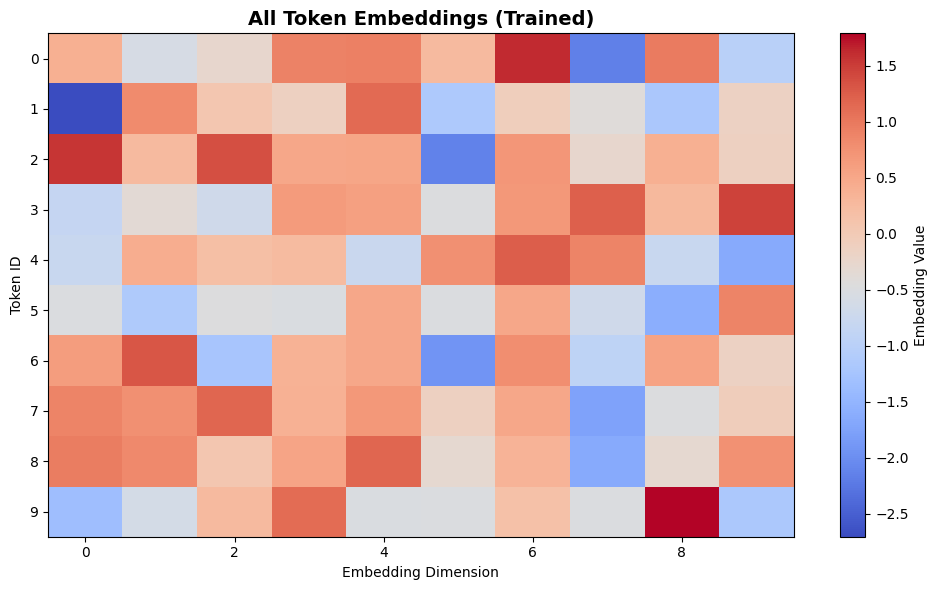


MODEL LOADING DEMONSTRATION

Loading model from ./sudoku2vec_trained_model.pt...
Model loaded from ./sudoku2vec_trained_model.pt
Configuration: vocab_size=10, embedding_dim=10, attention_dim=9, num_heads=1

Verifying loaded model...
✓ Outputs match: False
  Maximum difference: 0.001881

USAGE EXAMPLE: Load model in a different program

To load this model in another Python program, simply use:

```python
import torch
from your_module import Sudoku2Vec  # Import the class definition

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Sudoku2Vec.load_model('sudoku2vec_trained_model.pt', device=device)

# Get embeddings
embeddings = model.get_embeddings()  # Get all embeddings
token_embedding = model.get_embedding_for_token(5)  # Get embedding for token 5

# Use the model for inference
output, attention, target_with_pos, grid_emb = model.forward(target, position, puzzle)
```

Note: Make sure the Sudoku2Vec class definition is available in your program

In [45]:
# Save the trained model using the new save_model method
model_save_path = "./sudoku2vec_trained_model.pt"
model.save_model(model_save_path)

# Demonstrate getting embeddings
print("\n" + "="*80)
print("EMBEDDING EXTRACTION DEMONSTRATION")
print("="*80)

# Get all embeddings
all_embeddings = model.get_embeddings()
print(f"\n1. All Token Embeddings:")
print(f"   Shape: {all_embeddings.shape}")
print(f"   Description: [vocab_size={all_embeddings.shape[0]}, embedding_dim={all_embeddings.shape[1]}]")

# Get embedding for a specific token (e.g., token 5)
token_5_embedding = model.get_embedding_for_token(5)
print(f"\n2. Embedding for Token 5:")
print(f"   Shape: {token_5_embedding.shape}")
print(f"   Values: {token_5_embedding.squeeze()}")

# Get embeddings for multiple tokens
multiple_tokens = [1, 3, 5, 7, 9]
multiple_embeddings = model.get_embedding_for_token(multiple_tokens)
print(f"\n3. Embeddings for Tokens {multiple_tokens}:")
print(f"   Shape: {multiple_embeddings.shape}")
print(f"   Description: [num_tokens={len(multiple_tokens)}, embedding_dim={multiple_embeddings.shape[-1]}]")

# Visualize all embeddings as a heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
embeddings_np = all_embeddings.cpu().float().numpy()
im = ax.imshow(embeddings_np, cmap='coolwarm', aspect='auto', interpolation='nearest')
ax.set_title('All Token Embeddings (Trained)', fontweight='bold', fontsize=14)
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Token ID')
ax.set_yticks(range(all_embeddings.shape[0]))
plt.colorbar(im, ax=ax, label='Embedding Value')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("MODEL LOADING DEMONSTRATION")
print("="*80)

# Demonstrate loading the model in a fresh instance
print(f"\nLoading model from {model_save_path}...")
loaded_model = Sudoku2Vec.load_model(model_save_path, device=device)

# Verify the loaded model works correctly
print("\nVerifying loaded model...")
test_target = target[0:1]
test_position = position[0:1]
test_puzzle = puzzles[0:1]

with torch.no_grad():
    original_output, _, _, _ = model.forward(test_target.long().to(device), 
                                             test_position.long().to(device), 
                                             test_puzzle.long().to(device))
    loaded_output, _, _, _ = loaded_model.forward(test_target.long().to(device), 
                                                   test_position.long().to(device), 
                                                   test_puzzle.long().to(device))
    
    # Check if outputs match
    outputs_match = torch.allclose(original_output.float(), loaded_output.float(), atol=1e-5)
    print(f"✓ Outputs match: {outputs_match}")
    
    if not outputs_match:
        max_diff = (original_output.float() - loaded_output.float()).abs().max()
        print(f"  Maximum difference: {max_diff:.6f}")
    
print("\n" + "="*80)
print("USAGE EXAMPLE: Load model in a different program")
print("="*80)
print("""
To load this model in another Python program, simply use:

```python
import torch
from your_module import Sudoku2Vec  # Import the class definition

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Sudoku2Vec.load_model('sudoku2vec_trained_model.pt', device=device)

# Get embeddings
embeddings = model.get_embeddings()  # Get all embeddings
token_embedding = model.get_embedding_for_token(5)  # Get embedding for token 5

# Use the model for inference
output, attention, target_with_pos, grid_emb = model.forward(target, position, puzzle)
```

Note: Make sure the Sudoku2Vec class definition is available in your program!
""")
